## Imports

In [1]:
import sys
import os
import numpy as np
import numpy.lib.recfunctions as nprf
from sklearn import linear_model
import matplotlib as mpl
import time
import scipy

from scipy.stats import gaussian_kde
from importlib import reload
import pandas as pd

mpl.use('Agg')

mpl.rcParams['figure.figsize'] = (7,7)
mpl.rcParams['figure.facecolor'] = (1,1,1,1)
mpl.rcParams.update({'font.size':22})

from mpl_toolkits.mplot3d import Axes3D

% matplotlib inline

import matplotlib.pyplot as plt

In [2]:
import tools.matt_tools as matt

reload(matt)

<module 'tools.matt_tools' from '/home/mho1/halo_cnn/notebooks/tools/matt_tools.py'>

In [3]:
from tools.catalog import Catalog

In [4]:
wdir = '/home/mho1/scratch/halo_cnn'

# Load Raw Data

In [5]:
data_file = os.path.join(wdir,
                         'data_query',
                         'MDPL2_Rockstar_snap:120_v2_reduced.csv')
dat_MD = pd.read_csv(data_file, index_col=0)
#                          'sfr_catalog_0.671200.npy')
#                         'MDPL2_Rockstar_z=0.117_Macc=1e11.csv')

dat_MD = dat_MD.reset_index(drop=True)

FileNotFoundError: File b'/home/mho1/scratch/halo_cnn/data_query/MDPL2_Rockstar_snap:120_v2_reduced.csv' does not exist

In [5]:
data_file = os.path.join(wdir,
                         'data_raw',
                         'sfr_catalog_0.895100.npy')
dat_UM = np.load(data_file)
dat_UM = pd.DataFrame(dat_UM)


In [8]:
hmf_M200c = np.loadtxt(os.path.join(wdir, 'data_raw', 'dn_dm_MDPL2_z=0.117_M200c.txt'))

x_hmf_M200c, y_hmf_M200c = hmf_M200c

y_hmf_M200c = x_hmf_M200c*y_hmf_M200c*np.log(10)
x_hmf_M200c = np.log10(x_hmf_M200c)

In [9]:

print(dat_MD.columns)
dat_MD.head(10)

Index(['row_id', 'rockstarId', 'upId', 'pId', 'descId', 'breadthFirstId',
       'M200b', 'Rvir', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'M500c', 'Rs', 'Macc',
       'Vacc', 'Mvir', 'M200c', 'scale'],
      dtype='object')


,row_id,rockstarId,upId,pId,descId,breadthFirstId,M200b,Rvir,x,y,...,vx,vy,vz,M500c,Rs,Macc,Vacc,Mvir,M200c,scale
0,1,11821536357,-1,-1,11972164248,5436700266,1.806500e+11,117.540,6.96556,9.51966,...,-474.57,-86.47,-185.71,1.189300e+11,7.774,1.701100e+11,102.52,1.701100e+11,1.460200e+11,0.8951
1,2,11821538117,-1,-1,11972166001,5409580057,1.746300e+11,117.540,3.61279,2.82443,...,-542.60,-142.91,-76.36,1.219400e+11,13.374,1.701100e+11,100.19,1.701100e+11,1.550600e+11,0.8951
2,3,11821536297,-1,-1,11972164190,6528947610,1.339800e+11,107.729,1.32607,1.75722,...,-652.79,-187.36,-54.90,6.774300e+10,18.702,1.309700e+11,82.89,1.309700e+11,1.174200e+11,0.8951
3,4,11821537517,-1,-1,11972165399,5939824855,1.354900e+11,106.897,2.13282,0.91453,...,-631.40,-151.32,-55.96,8.279800e+10,10.505,1.279600e+11,91.76,1.279600e+11,1.098900e+11,0.8951
4,5,11821542837,-1,-1,11972170721,6628740257,1.174200e+11,102.072,2.54390,1.23761,...,-403.86,-100.01,83.13,3.010800e+10,34.640,1.114000e+11,73.04,1.114000e+11,6.623800e+10,0.8951
5,6,11821539417,-1,-1,11972167296,6092917351,1.234400e+11,104.759,7.76026,5.01127,...,-435.18,-19.32,142.21,7.527100e+10,11.495,1.204300e+11,87.78,1.204300e+11,1.038700e+11,0.8951
6,7,11821534927,-1,-1,11972162822,4395842099,3.929100e+11,153.158,14.02830,6.33010,...,-369.72,-111.84,242.74,2.709700e+11,10.872,3.763500e+11,137.21,3.763500e+11,3.296800e+11,0.8951
7,8,11821530187,-1,-1,11972158142,2940537529,1.707100e+12,245.849,14.01580,6.11362,...,-365.37,-42.83,176.42,8.324900e+11,57.615,1.556600e+12,188.59,1.556600e+12,1.293100e+12,0.8951
8,9,11821542427,-1,-1,11972170310,6140205666,1.129100e+11,102.072,12.96110,4.51725,...,-375.45,-51.82,121.39,9.333500e+10,5.711,1.114000e+11,100.90,1.114000e+11,1.053800e+11,0.8951
9,10,11821535097,-1,-1,11972162991,4317037061,4.230200e+11,156.162,7.39442,10.80980,...,-435.26,-25.31,167.28,2.890400e+11,8.897,3.989300e+11,140.42,3.989300e+11,3.582900e+11,0.8951


In [10]:
dat_UM.head(10)

,x,y,z,vx,vy,vz,upid,id,mvir,mpeak,obs_sm,obs_sfr
0,3.405850,16.637180,91.849060,-208.309998,-186.809998,242.970001,-1,11821561109,1.726200e+14,1.728100e+14,1.194319e+12,1.024768
1,3.719573,16.531027,92.051743,-694.937622,-634.987976,-123.497276,11821561109,53000002900107172,8.393496e+09,2.890400e+11,2.896403e+10,2.837762
2,3.808963,17.124643,91.304192,-75.626617,-400.379150,554.288635,11821561109,41000004879831165,6.404367e+10,1.690600e+12,3.449705e+10,0.054612
3,3.390229,16.690458,91.908661,-655.760315,-340.822113,266.760132,11821561109,44000004360511635,9.074129e+09,2.092500e+11,2.575778e+10,0.082636
4,3.959978,16.360865,91.266914,-223.851639,-93.881302,522.229614,11821561109,36000005764327304,7.386536e+10,1.406100e+12,4.725956e+10,0.291601
5,3.700108,16.225718,91.832970,-658.988281,-31.404678,151.654938,11821561109,35000005942826643,3.324754e+10,2.980700e+11,2.395962e+10,0.068386
6,3.471246,16.180105,91.995720,-532.088745,-598.383484,284.099426,11821561109,25000007722938411,1.520150e+11,1.190800e+12,5.593840e+10,0.401510
7,2.977862,16.408745,91.987038,-236.450409,79.963394,924.542480,11821561109,68000001048741782,5.085003e+09,6.623800e+10,3.207689e+09,0.003328
8,3.137563,16.505594,91.956978,-196.435181,-270.985626,-21.743271,11821561109,54000002750398512,1.033524e+11,2.089500e+12,3.278440e+10,2.158500
9,4.140018,16.731819,92.002434,-575.110413,-390.126129,293.410706,11821561109,48000003689609840,7.068176e+09,1.911900e+11,6.648070e+09,0.002949


(1e-08, 0.001)

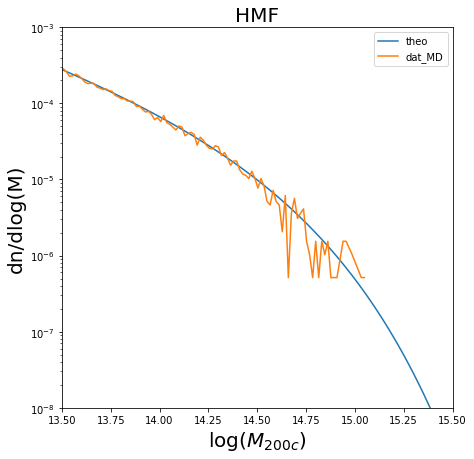

In [13]:
f = plt.figure(figsize=(7,7))
ax = f.add_subplot(111)

ax.semilogy(x_hmf_M200c,y_hmf_M200c, label='theo')

x = dat_MD[['M200c']][(dat_MD['upId']==-1) & (dat_MD['M200c']>=10**13.5)]

matt.histplot(np.log10(x.values), 
          n=100, label='dat_MD', log=1, box=True, ax=ax, func=lambda x:8*x)
    
ax.set_title('HMF', fontsize=20)
ax.set_xlabel(r'$\log(M_{200c}$)', fontsize=20)
ax.set_ylabel(r'dn/dlog(M)', fontsize=20)
ax.legend()

ax.set_xlim(13.5,15.5)
ax.set_ylim(10**-8,10**-3)

# Assign Rotations

In [7]:
x=dat_MD.set_index('rockstarId')

x = np.log10(x[['M200c']][(x['upId']==-1) & (x['M200c']>=10**13.5)])
x = x.sort_values(by='M200c')
x['num_rot']=0

In [8]:
dn_dlogm = 10.**-5
dlogm = 0.01

window = [0,1]

start = np.argwhere(x['M200c']>14).min()
for i in range(start, len(x)):
    if i%100==0: print(i/100)
    while (x['M200c'].iloc[window[0]] < x['M200c'].iloc[i] - dlogm/2.):
        window[0]+=1
    while (x['M200c'].iloc[window[1]] < x['M200c'].iloc[i] + dlogm/2.):
        window[1]+=1
        if window[1]==len(x): break
    
    # print(window)
    i_dn_dlogm = (window[1]-window[0])/1000**3/dlogm
    
    x['num_rot'].iloc[i] = int(dn_dlogm/i_dn_dlogm)+1
    
x['num_rot'][x['num_rot']<3]=3

/home/mho1/.conda/envs/jupy/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


93.0
94.0


KeyboardInterrupt: 

In [115]:
dn_dlogm/i_dn_dlogm

100.0

In [116]:
y=[]
for i in range(len(x)):
    y += [x['M200c'].iloc[i]]*x['num_rot'].iloc[i]

(13.500003068051694, 15.05625673585014)

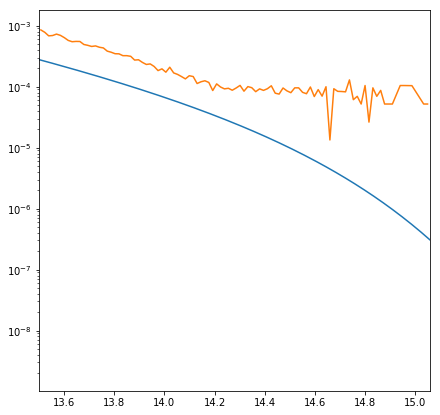

In [117]:

f = plt.figure(figsize=(7,7))
ax = f.add_subplot(111)

ax.semilogy(x_hmf_M200c,y_hmf_M200c, label='theo')


t = matt.histplot(np.array(y), 
              n=100, label='dat_MD', log=1, box=True, ax=ax, func=lambda x:8*x)

ax.set_xlim(min(y), max(y))

In [10]:
def fibonacci_sphere(N=1, randomize=True):
    # Generate a set of N angles, (theta, phi), 'evenly' distributed on the unit sphere. 
    # In truth, it is Fibonacci-sphere distributed. See https://stackoverflow.com/questions/9600801/evenly-distributing-n-points-on-a-sphere
    
    if N<1: return []

    rnd = np.random.rand() * N if randomize else 1.
        
    points = []
    
    dz = 2./N
    dphi = np.pi*(3. - np.sqrt(5)) # Golden angle
    
    for i in range(N):
        z = ((i*dz) - 1) + (dz/2.)
        
        theta = np.arccos(z)
        phi = ((i + rnd) % N) * dphi
        
        points.append((theta, phi))

    if randomize: np.random.shuffle(points)
    
    return points

In [11]:
host_data = dat_MD[(dat_MD['upId']==-1) & (dat_MD['M200c']>=10**13.5)]

par = OrderedDict([ 
    ('catalog_name' ,   'Rockstar_UM_z=0.117'),
    
    ('wdir'         ,   '/home/mho1/scratch/halo_cnn'),
    ('in_folder'    ,   'data_raw'),
    ('out_folder'   ,   'data_mocks'),
    
    ('host_file'    ,   'MDPL2_Rockstar_snap:120_v3.csv'),
    ('gal_file'     ,   'sfr_catalog_0.895100.npy'),
    
    ('z'            ,   0.117),
    
    ('min_mass'     ,   10**(13.5)),
    ('min_richness' ,   10),
    
    ('cut_size'     ,   'large'),

    ('dn_dlogm'		,	10.**-5.5),
    ('dlogm'		,	0.05),
    ('boost_minmass',	10**14),
    ('min_rotations',	3),
    
    ('cosmo' ,   {'H_0': 100, # [km/s/(Mpc/h)]
                  'Omega_m': 0.307115,
                  'Omega_l': 0.692885,
                  'c': 299792.458 # [km/s]
                 })
    ])

print('Calculating boosted rotation angles...')

host_rots = pd.DataFrame(0, index=host_data.index, columns=['M200c','num_rot'])

host_rots.loc[:,'M200c'] = np.log10(host_data['M200c'])
host_rots.loc[:,'num_rot'] = 0

host_rots = host_rots.sort_values(by='M200c')

window = [0,1]

start = np.argwhere(host_rots['M200c']>np.log10(par['boost_minmass'])).min()
print(len(host_rots)/100)
for i in range(start, len(host_rots)):
    if i%100==0: print(i/100)
    while (host_rots['M200c'].iloc[window[0]] < host_rots['M200c'].iloc[i] - par['dlogm']/2.):
        window[0]+=1
    while (window[1]<len(host_rots)):
        if (host_rots['M200c'].iloc[window[1]] >= host_rots['M200c'].iloc[i] + par['dlogm']/2.):
            break
        window[1]+=1
    
    # print(window)
    i_dn_dlogm = (window[1]-window[0])/1000**3/par['dlogm']
    
    host_rots.loc[:,'num_rot'].iloc[i] = int(par['dn_dlogm']/i_dn_dlogm)+1
    
host_rots.loc[:,'num_rot'].iloc[np.argwhere(host_rots['num_rot']<par['min_rotations'])] = par['min_rotations']


rot_assign = pd.DataFrame(True, index=host_rots.index, 
						  columns=[(0,0), (np.pi/2,0), (np.pi/2, np.pi/2)])

for n_rot in host_rots['num_rot'].unique():
	ang_list = fibonacci_sphere(n_rot - par['min_rotations'])

	for ang in ang_list:
		rot_assign[ang] = host_rots['num_rot']==n_rot

print('# Rotations:' + str(host_rots['num_rot'].unique()))

Calculating boosted rotation angles...
114.13


/home/mho1/.conda/envs/jupy/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


93.0
94.0
95.0
96.0
97.0
98.0
99.0
100.0
101.0
102.0
103.0
104.0
105.0
106.0
107.0
108.0
109.0
110.0
111.0
112.0
113.0
114.0
# Rotations:[ 3  4  5  6  7  8  9 10 16 23 27 32 20 18 80 40]


In [14]:
print(np.sum(np.sum(rot_assign,axis=1)))
print(len(rot_assign)*15)

SyntaxError: invalid syntax (<ipython-input-14-223187e57b5e>, line 2)

# Show Clusters

In [5]:
hosts_MD = dat_MD[(dat_MD['pId']==-1) & 
                  (np.log10(dat_MD['M200c'])>14)
                 ]

NameError: name 'dat_MD' is not defined

host: 11824560713.0
# kids: 64


kids_out: 33
non_in: 1


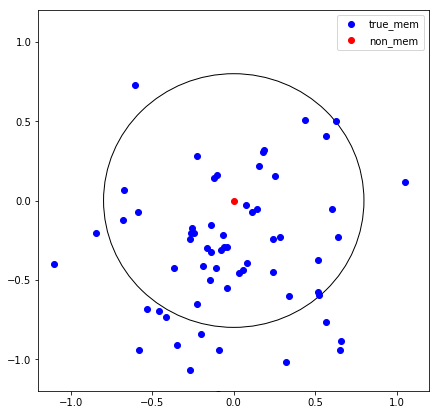

In [8]:
# Get host info
host_MD = hosts_MD.sample().iloc[0]
print('host: ' + str(host_MD['rockstarId']))

host_UM = dat_UM[host_MD['rockstarId']==dat_UM['id']].iloc[0]

radius = host_MD['Rs']/1000.

# Get kid info
kids = dat_UM[dat_UM['upid']==host_UM['id']]
print('# kids: ' + str(len(kids)))

kid_pos = kids[['x','y','z']] - host_UM[['x','y','z']]

# Get non-members
non_mem = dat_UM[
    (dat_UM['upid']==-1) &
    (dat_UM['x'] > (host_UM['x'] - 1.5*radius)) & 
    (dat_UM['x'] < (host_UM['x'] + 1.5*radius))&
    (dat_UM['y'] > (host_UM['y'] - 1.5*radius)) & 
    (dat_UM['y'] < (host_UM['y'] + 1.5*radius))&
    (dat_UM['z'] > (host_UM['z'] - 1.5*radius)) & 
    (dat_UM['z'] < (host_UM['z'] + 1.5*radius))
]
non_mem_pos = non_mem[['x','y','z']] - host_UM[['x','y','z']]


# Plot
f = plt.figure(figsize=[7,7])
ax = f.add_subplot(111)

circle = plt.Circle((0, 0), radius = radius, edgecolor='k', facecolor='none')
ax.add_artist(circle)
ax.plot(kid_pos['x'],kid_pos['y'],'o',c='b',label='true_mem')
ax.plot(non_mem_pos['x'],non_mem_pos['y'],'o',c='r',label='non_mem')

ax.set_xlim(-1.5*radius, 1.5*radius)
ax.set_ylim(-1.5*radius, 1.5*radius)
ax.legend()

# Stats
kids_out = np.sum((kid_pos['x']**2 + kid_pos['y']**2 + kid_pos['z']**2) > radius**2)
non_in = np.sum((non_mem_pos['x']**2 + non_mem_pos['y']**2 + non_mem_pos['z']**2) < radius**2)
print('\n')
print('kids_out: ' +str(kids_out))
print('non_in: ' + str(non_in))

In [65]:
dat_UM.iloc[1]['x']

3.7195727825164795

# Cosmology

In [98]:
import scipy.integrate as integrate
import scipy.interpolate as interpolate

import time

In [99]:
cosmo = {'H_0': 100, # [km/s/(Mpc/h)]
         'Omega_m': 0.307115,
         'Omega_l': 0.692885,
         'c': 299792.458 # [km/s]
         }

Text(0,0.5,'H')

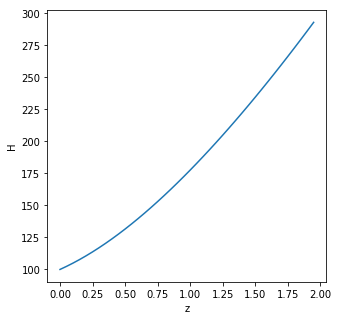

In [100]:
def H_from_z(z, cosmo):
    H = cosmo['H_0'] * (cosmo['Omega_m']*(1 + z)**3 + cosmo['Omega_l'])**0.5
    return H

samp = np.arange(0,2,0.05)

f = plt.figure(figsize=(5,5))
plt.plot(samp,H_from_z(samp, cosmo))
plt.xlabel('z')
plt.ylabel('H')

normal: 0.003621339797973633
interp: 0.0068511962890625
numpy: 9.822845458984375e-05


Text(0,0.5,'H')

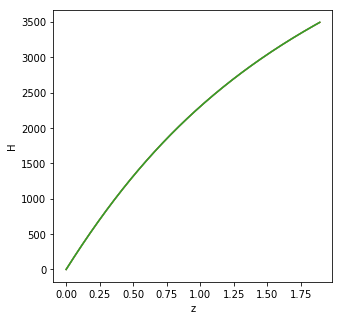

In [54]:
def d_from_z(z, cosmo):
    d = integrate.quad(lambda x: cosmo['c']/H_from_z(x, cosmo), 0, z)
    return d[0]

samp = np.arange(0,2,0.01)
test_samp = np.arange(0.00005,1.9,0.01)

t0 = time.time()
d_norm = [d_from_z(i, cosmo) for i in test_samp]
print('normal: ' + str(time.time()-t0))

d = [d_from_z(i, cosmo) for i in samp]
d_from_z_interp = interpolate.interp1d(samp, d)

t0 = time.time()
d_interp = [d_from_z_interp(i) for i in test_samp]
print('interp: ' + str(time.time()-t0))

def d_from_z_nump(z):
    d_nump = np.interp(z, samp, d)
    return d_nump

t0 = time.time()
d_nump = d_from_z_nump(test_samp)
print('numpy: ' + str(time.time()-t0))

f = plt.figure(figsize=(5,5))



plt.plot(test_samp, d_norm)
plt.plot(test_samp, d_interp)
plt.plot(test_samp, d_nump)
plt.xlabel('z')
plt.ylabel('H')

## Numpy interpolator is a factor of 10 faster than other methods

In [55]:
dat_UM.columns

Index(['x', 'y', 'z', 'vx', 'vy', 'vz', 'upid', 'id', 'mvir', 'mpeak',
       'obs_sm', 'obs_sfr'],
      dtype='object')

# KD Tree

In [6]:
from scipy.spatial import KDTree

In [7]:
kids = dat_UM[dat_UM['upid']!=-1]
hosts = dat_UM[dat_UM['upid']==-1]

In [12]:
tree = KDTree([[0,0,1],[0,0,1]], leafsize=50)

In [13]:
y = tree.query_ball_point(hosts[['x','y']].head(10),100)

ValueError: Searching for a 2-dimensional point in a 3-dimensional KDTree

In [11]:
len(y[0])

871

In [57]:
hosts.index.to_series()

0                  0
17                17
25                25
29                29
35                35
39                39
42                42
44                44
47                47
54                54
56                56
59                59
62                62
67                67
69                69
75                75
83                83
86                86
88                88
93                93
95                95
99                99
100              100
103              103
106              106
109              109
114              114
118              118
122              122
124              124
              ...   
24486883    24486883
24486884    24486884
24486885    24486885
24486891    24486891
24486897    24486897
24486900    24486900
24486903    24486903
24486907    24486907
24486908    24486908
24486915    24486915
24486925    24486925
24486926    24486926
24486934    24486934
24486943    24486943
24486948    24486948
24486950    24486950
24486960    2

In [83]:
in_ball=0
for i,row in kids[['x','y']].head(100000).iterrows():
    if ((row['x']-500)**2 + (row['y']-500)**2 < 500**2):
        in_ball +=1
print(in_ball)

467


In [35]:
w = kids['x'].head(40)+kids['y'].head(40)
w.loc[[3,16,7,60]]

/home/mho1/.conda/envs/jupy/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


3     20.080687
16    19.707470
7     19.386606
60          NaN
dtype: float32

In [83]:
[x in [40,45] for x in dat_UM.iloc[40:50].index.to_series()]

[True, False, False, False, False, True, False, False, False, False]

# Rotations

In [5]:

th = np.pi*np.random.random()

m1 = np.array([[np.cos(th),-np.sin(th)],[np.sin(th),np.cos(th)]])
m2 = 4*np.array([[1],[0]])

np.matmul(m1,m2)

array([[-2.65837818],
       [ 2.98881673]])

In [6]:
dat_MD.head(5)[['x','y','z']]

NameError: name 'dat_MD' is not defined

In [7]:
th_x, th_y, th_z = 2*np.pi*np.random.random(3)

# th_x = np.pi

R_x = np.array([[1,0,0],
                [0, np.cos(th_x), -np.sin(th_x)], 
                [0, np.sin(th_x), np.cos(th_x)]]
              )

R_y = np.array([[np.cos(th_y), 0, np.sin(th_y)],
                [0, 1, 0],
                [-np.sin(th_y), 0, np.cos(th_y)]]
              )

R_z = np.array([[np.cos(th_z), -np.sin(th_z), 0],
                [np.sin(th_z), np.cos(th_z), 0],
                [0,0,1]]
              )
R = np.matmul(R_z, R_y, R_x)



dat_MD.loc[0:5,['x','y','z']] = np.matmul(dat_MD.loc[0:5,['x','y','z']].values, R.T)

NameError: name 'dat_MD' is not defined

In [8]:
from mpl_toolkits.mplot3d import Axes3D

In [9]:
def fibonacci_sphere(N=1, randomize=True):
    # Generate a set of N angles, (theta, phi), 'evenly' distributed on the unit sphere. In truth, it is Fibonacci sphere distributed. See https://stackoverflow.com/questions/9600801/evenly-distributing-n-points-on-a-sphere
    
    rnd = np.random.rand() * N if randomize else 1.
        
    points = []
    
    dz = 2./N
    dphi = np.pi*(3. - np.sqrt(5)) # Golden angle
    
    for i in range(N):
        z = ((i*dz) - 1) + (dz/2.)
        
        theta = np.arccos(z)
        phi = ((i + rnd) % N) * dphi
        
        points.append((theta, phi))
    
    np.random.shuffle(points)
    
    return points

In [10]:
ang = fibonacci_sphere(13, True)

i = np.random.randint(len(ang))


def rot_matrix_LOS(theta, phi):
    old_pos = (np.cos(ang[i][1])*np.sin(ang[i][0]) ,
               np.sin(ang[i][1]) * np.sin(ang[i][0]),
               np.cos(ang[i][0])
              )
    new_pos = (0,0,1)

    u = np.cross(old_pos, new_pos).astype('<f4')
    u /= np.linalg.norm(u)

    th = np.arccos(np.dot(old_pos,new_pos))

    u_cross = np.array([
        [0, -u[2], u[1]],
        [u[2], 0, -u[0]],
        [-u[1], u[0], 0]
    ])

    R = np.cos(th) * np.identity(3) + \
        np.sin(th) * u_cross + \
        (1-np.cos(th))*np.tensordot(u,u, axes=0)
    
    return R

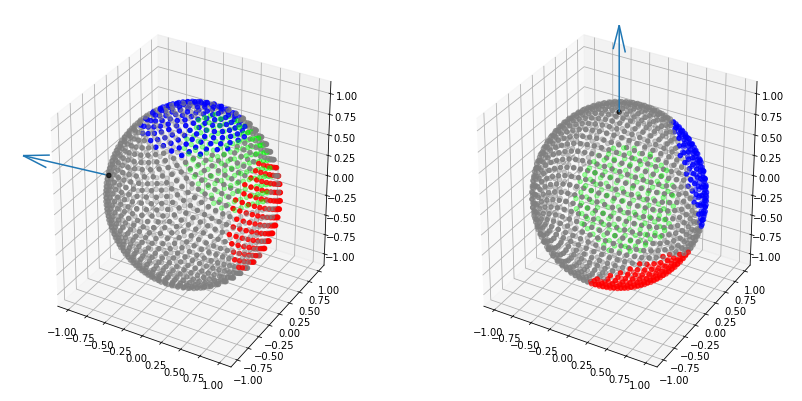

In [12]:
ang = np.array(fibonacci_sphere(1500, False))

x = np.cos(ang[:,1])*np.sin(ang[:,0])
y = np.sin(ang[:,1])*np.sin(ang[:,0])
z = np.cos(ang[:,0])

c = np.array([(0.5,0.5,0.5)]*len(ang))

m = 0.8
c[x>m] = (1,0,0)
c[y>m] = (0,1,0)
c[z>m] = (0,0,1)

i = np.random.randint(len(ang))
c[i] = (0,0,0)


fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(1,2,1, projection='3d')

ax1.scatter(x,y,z,'.', c=c)
ax1.quiver(x[i],y[i],z[i],x[i],y[i],z[i])

ax2 = fig.add_subplot(1,2,2, projection='3d')


x,y,z = np.dot(rot_matrix_LOS(*ang[i]),np.array([x,y,z]))
ax2.scatter(x,y,z,'.', c=c)

ax2.quiver(0,0,1,0,0,1)


# Catalog Class

In [ ]:
import pickle

In [26]:
class Cluster:
    
    def __init__(self, prop=None, gal=None):
        self.prop = prop
        self.gal = gal

class Catalog:
    def __getitem__(self, key):
        return Cluster(prop = self.prop.iloc[key],
                       gal = self.gal[key])
    def __len__(self):
        return len(self.prop)
    
    def __init__(self, prop=None, gal=None):
        self.prop = prop # Properties of host clusters. (# clusters) x (# of properties)
        self.gal = gal # Cluster members. Position, velocities, etc.
    
    def save(self,filename):
        with open(filename, 'wb') as out_file:
            pickle.dump(self, out_file)
    def load(self, filename):
        with open(filename, 'rb') as in_file:
            new_cat = pickle.load(in_file)
        
        self.prop = new_cat.prop
        self.gal = new_cat.gal

In [27]:
c = Catalog(prop = pd.DataFrame(np.random.rand(100,len(dat_MD.columns)),
                                columns=dat_MD.columns
                               ),
            gal = [np.random.rand(5,np.random.randint(15)) for i in range(100)]
           )

In [28]:
file_name = os.path.join(wdir,'data_raw','catalog','temp.p')

c.save(file_name)

In [29]:
c.prop.head()

,row_id,rockstarId,upId,pId,descId,breadthFirstId,M200b,Rvir,x,y,...,vx,vy,vz,M500c,Rs,Macc,Vacc,Mvir,M200c,scale
0,0.081327,0.827463,0.517041,0.783035,0.242950,0.005151,0.059740,0.510258,0.447961,0.118091,...,0.518459,0.759606,0.773318,0.556385,0.712711,0.875113,0.881270,0.528273,0.040974,0.143970
1,0.371553,0.666226,0.103578,0.192403,0.043131,0.962065,0.397233,0.868677,0.789545,0.865311,...,0.490728,0.959442,0.832670,0.384788,0.983948,0.705448,0.443895,0.311246,0.440022,0.109309
2,0.422287,0.866850,0.272102,0.665185,0.691286,0.224001,0.305792,0.992446,0.491964,0.140620,...,0.949099,0.396328,0.157017,0.027252,0.099027,0.541977,0.105500,0.260430,0.105840,0.760412
3,0.386519,0.220909,0.206619,0.632416,0.754664,0.658839,0.369257,0.142260,0.706999,0.946186,...,0.935309,0.489431,0.841294,0.662617,0.496387,0.122466,0.911771,0.441999,0.681289,0.557740
4,0.473522,0.177748,0.145955,0.624807,0.447260,0.704414,0.644913,0.272200,0.472394,0.747422,...,0.811833,0.002548,0.214302,0.707073,0.077141,0.731867,0.814034,0.936873,0.194387,0.969809


In [30]:
c = Catalog()
c.load(file_name)

In [33]:
c.gal

[array([[0.46430587, 0.4716896 ],
        [0.12582955, 0.15573872],
        [0.93246209, 0.90815433],
        [0.52215271, 0.10213539],
        [0.66252004, 0.90061969]]),
 array([[0.41557278, 0.8173551 , 0.06905902, 0.11268233, 0.71857878,
         0.73231955, 0.99180401, 0.79878689, 0.54294509, 0.49273659,
         0.53542201, 0.7700309 ],
        [0.86077947, 0.86817212, 0.09083004, 0.98759154, 0.82950877,
         0.82474322, 0.91063983, 0.66444724, 0.71418192, 0.40586528,
         0.98706837, 0.04112764],
        [0.0303127 , 0.47878925, 0.79800297, 0.17411533, 0.1350514 ,
         0.19228943, 0.58539521, 0.91978918, 0.71443392, 0.28963039,
         0.63082044, 0.28927007],
        [0.11950601, 0.09098574, 0.98676758, 0.025804  , 0.21746572,
         0.04974628, 0.20674756, 0.74912753, 0.68862535, 0.24840318,
         0.52530351, 0.37581537],
        [0.62074571, 0.57516691, 0.76128065, 0.63485085, 0.57237388,
         0.69240922, 0.17357863, 0.26924819, 0.05595954, 0.23905739,
  

In [18]:
p = pd.DataFrame.from_csv(os.path.join(wdir,'data_raw','catalog','Rockstar_UM_z=0.117_pure_prop.csv'))
g = np.load(os.path.join(wdir,'data_raw','catalog','Rockstar_UM_z=0.117_pure_gal.npy'))

/home/mho1/.conda/envs/jupy/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


In [22]:
c = Catalog(prop=p,
            gal=g
           )

# Load catalogs

In [5]:
# pure_cat = Catalog().load(os.path.join(wdir,'data_mocks','Rockstar_UM_z=0.117_pure.p'))

# contam_cat = Catalog().load(os.path.join(wdir,'data_mocks','Rockstar_UM_z=0.117_contam_med.p'))

contam_cat = Catalog().load(os.path.join(wdir,'data_mocks','Rockstar_UM_z=0.194_contam.p'))

Loading catalog from: /home/mho1/scratch/halo_cnn/data_mocks/Rockstar_UM_z=0.194_contam.p


In [6]:
pure_cat.gal[0].dtype.names

('xproj', 'yproj', 'Rproj', 'vlos', 'true_memb', 'mvir')

# Catalog characteristics

In [6]:
cat = pure_cat[pure_cat.prop.index[pure_cat.prop['rotation'] == 0].values]

In [7]:
hmf_Macc = np.loadtxt(os.path.join(wdir, 'data_raw', 'dn_dlogm_MDPL2_z=0.117_Macc.txt'))

x_hmf_Macc, y_hmf_Macc = zip(*hmf_Macc)

x_hmf_Macc = np.log10(x_hmf_Macc)

In [8]:
hmf_M200c = np.loadtxt(os.path.join(wdir, 'data_raw', 'dn_dm_MDPL2_z=0.117_M200c.txt'))

x_hmf_M200c, y_hmf_M200c = hmf_M200c

y_hmf_M200c = x_hmf_M200c*y_hmf_M200c*np.log(10)
x_hmf_M200c = np.log10(x_hmf_M200c)

In [5]:
dat_mich = np.load(os.path.join(wdir,'data_mocks','mich','UM_z=0.117_large_reduced.npy'))
print(sys.getsizeof(dat_mich)/10.**9, ' GB')
print(dat_mich.dtype.names)

0.88386974  GB
('Mtot', 'hostid', 'R200', 'rotation', 'fold', 'Ngal', 'vlos', 'sigmav', 'Rproj', 'xyproj', 'name', 'truememb', 'intest', 'intrain', 'redshift', 'Rs')


In [10]:
print('pure_len: ', len(pure_cat))
print('contam_len: ', len(contam_cat))
print('mich_len: ', len(dat_mich))

pure_len:  208798
contam_len:  263217
mich_len:  43183


[]

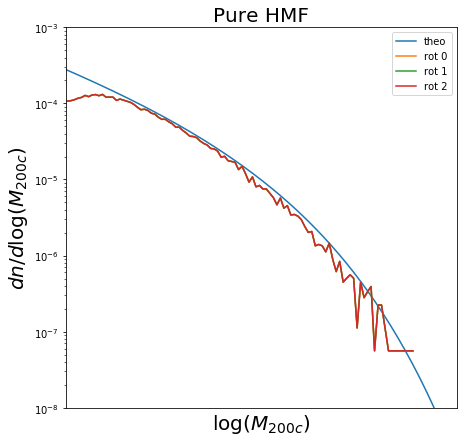

In [13]:
f = plt.figure(figsize=(7,7))
ax = f.add_subplot(111)


ax.plot(x_hmf_M200c,y_hmf_M200c, label='theo')

for r in [0,1,2]:#range(int(pure_cat.prop['rotation'].max()+1)):
    
    matt.histplot(np.log10(pure_cat.prop['M200c'][pure_cat.prop['rotation']==r].values), 
              n=100, label='rot ' + str(r), log=1, box=True, ax=ax)
    
ax.set_title('Pure HMF', fontsize=20)
ax.set_xlabel(r'$\log(M_{200c}$)', fontsize=20)
ax.set_ylabel(r'$dn/d\log(M_{200c})$', fontsize=20)
ax.legend()

ax.set_xlim(13.5,15.5)
ax.set_ylim(10**-8,10**-3)


ax.set_xticks([])

(1e-08, 0.001)

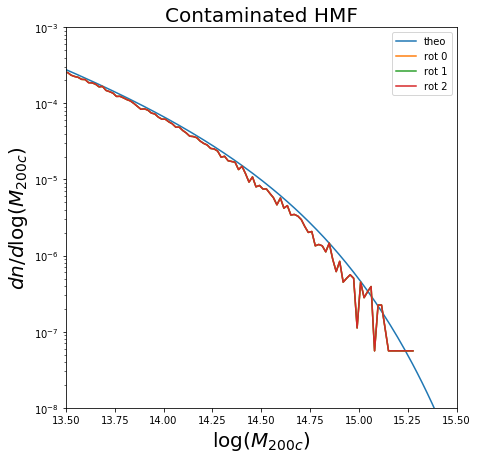

In [14]:
f = plt.figure(figsize=(7,7))
ax = f.add_subplot(111)

ax.plot(x_hmf_M200c,y_hmf_M200c, label='theo')

for r in [0,1,2]:#range(int(contam_cat.prop['rotation'].max()+1)):
    
    matt.histplot(np.log10(contam_cat.prop['M200c'][contam_cat.prop['rotation']==r].values), 
              n=100, label='rot ' + str(r), log=1, box=True, ax=ax)
    
ax.set_title('Contaminated HMF', fontsize=20)
ax.set_xlabel(r'$\log(M_{200c}$)', fontsize=20)
ax.set_ylabel(r'$dn/d\log(M_{200c})$', fontsize=20)
ax.legend()

ax.set_xlim(13.5,15.5)
ax.set_ylim(10**-8,10**-3)

(1e-08, 0.001)

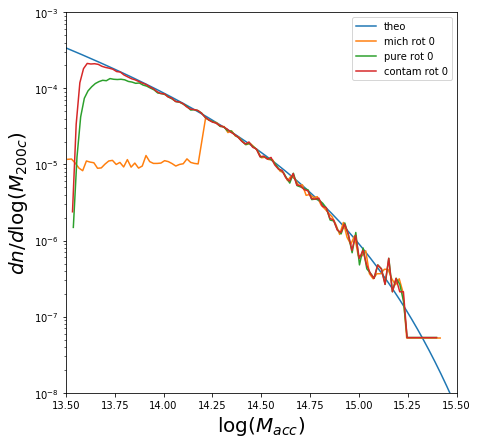

In [12]:

rot = 0#np.random.choice(c.prop['rotation'])

f = plt.figure(figsize=(7,7))
ax = f.add_subplot(111)

ax.plot(x_hmf_Macc, y_hmf_Macc, label='theo')


matt.histplot(np.log10(dat_mich['Mtot'][dat_mich['rotation']==rot]), 
              n=100, label='mich rot '+ str(rot),log=1, box=True, ax=ax)

matt.histplot(np.log10(pure_cat.prop['Macc'][pure_cat.prop['rotation']==rot]), 
              n=100, label='pure rot ' + str(rot), log=1, box=True, ax=ax)
matt.histplot(np.log10(contam_cat.prop['Macc'][contam_cat.prop['rotation']==rot]), 
              n=100, label='contam rot ' + str(rot), log=1, box=True, ax=ax)

ax.set_xlabel(r'$\log(M_{acc}$)', fontsize=20)
ax.set_ylabel(r'$dn/d\log(M_{200c})$', fontsize=20)
ax.legend()

ax.set_xlim(13.5,15.5)
ax.set_ylim(10**-8,10**-3)

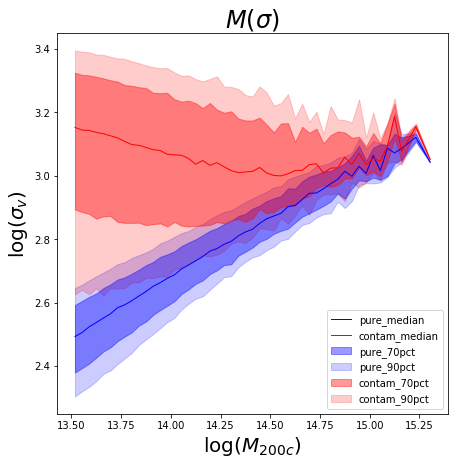

In [15]:
rot = 0

f = plt.figure(figsize=(7,7))
ax = f.add_subplot(111)

matt.binnedplot(np.log10(pure_cat.prop['M200c'][pure_cat.prop['rotation']==rot]),
                np.log10(pure_cat.prop['sigv'][pure_cat.prop['rotation']==rot]), 
                percentiles=[35,45],
                n=50, label='pure_',ax=ax, log=0, c='b', names=True)
matt.binnedplot(np.log10(contam_cat.prop['M200c'][contam_cat.prop['rotation']==rot]),
                np.log10(contam_cat.prop['sigv'][contam_cat.prop['rotation']==rot]), 
                percentiles=[35,45],
                n=50, label='contam_',ax=ax, log=0, c='r', names=True)

# ax.set_xlim(14,15.3)
# ax.set_ylim(2.3,3.3)

plt.xlabel(r'$\log(M_{200c})$', fontsize=20)
plt.ylabel(r'$\log(\sigma_v)$', fontsize=20)
plt.title('$M(\sigma)$', fontsize=24)
ax.legend(loc=4)

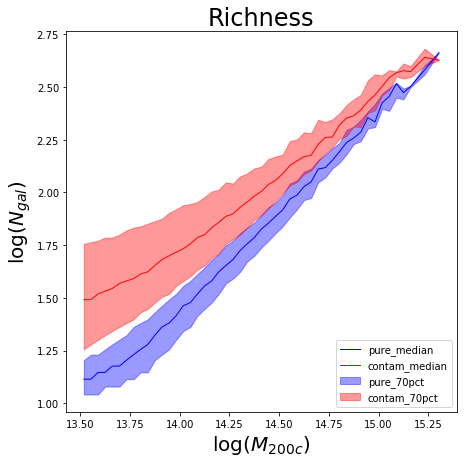

In [16]:
rot = 0

f = plt.figure(figsize=(7,7))
ax = f.add_subplot(111)

matt.binnedplot(np.log10(pure_cat.prop['M200c'][pure_cat.prop['rotation']==rot]),
                np.log10(pure_cat.prop['Ngal'][pure_cat.prop['rotation']==rot]), 
                percentiles=[35],
                n=50, label='pure_',ax=ax, log=0, c='b', names=True)
matt.binnedplot(np.log10(contam_cat.prop['M200c'][contam_cat.prop['rotation']==rot]),
                np.log10(contam_cat.prop['Ngal'][contam_cat.prop['rotation']==rot]), 
                percentiles=[35],
                n=50, label='contam_',ax=ax, log=0, c='r', names=True)

# ax.set_xlim(15,15.3)

plt.xlabel(r'$\log(M_{200c})$', fontsize=20)
plt.ylabel(r'$\log(N_{gal})$', fontsize=20)
plt.title('Richness', fontsize=24)
ax.legend(loc=4)

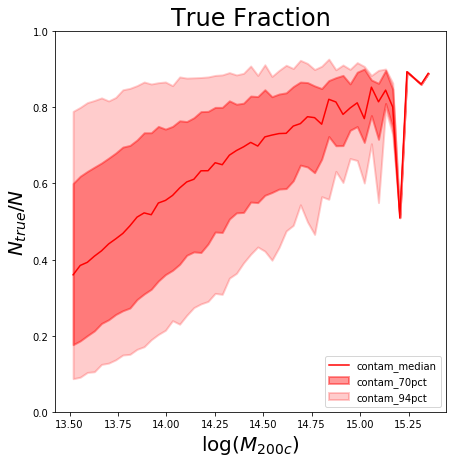

In [15]:
rot = 0

f = plt.figure(figsize=(7,7))
ax = f.add_subplot(111)

frac = pd.Series([np.sum(contam_cat.gal[i]['true_memb'])/contam_cat.prop.loc[i,'Ngal']
                  for i in contam_cat.prop.index[contam_cat.prop['rotation']==rot].values
                 ])

matt.binnedplot(np.log10(contam_cat.prop['M200c'][contam_cat.prop['rotation']==rot]),
                frac, 
                percentiles=[35, 47],
                n=50, label='contam_',ax=ax, log=0, c='r', names=True)

# ax.set_xlim(15,15.3)
ax.set_ylim(0,1)

plt.xlabel(r'$\log(M_{200c})$', fontsize=20)
plt.ylabel(r'$N_{true}/N$', fontsize=20)
plt.title('True Fraction', fontsize=24)
ax.legend(loc=4)

In [16]:
## PROBLEMATIC HIGH MASS CLUSTER

cat = contam_cat[((contam_cat.prop['rotation']==0)& (contam_cat.prop['M200c'] > 10**15.2)).values]

x = cat.prop['M200c'].sort_values().iloc[0]

contam_cat.prop.index[((contam_cat.prop['rotation']==0)& (contam_cat.prop['M200c'] == x)).values]

Int64Index([47804], dtype='int64')

# Random Cluster

In [7]:
rcut = contam_cat.par['aperture'] #Mpc/h
vcut = contam_cat.par['vcut'] #km/s

host id: 11445034438.0
rotation: 2.0
log(M_200c): 13.55146219708474


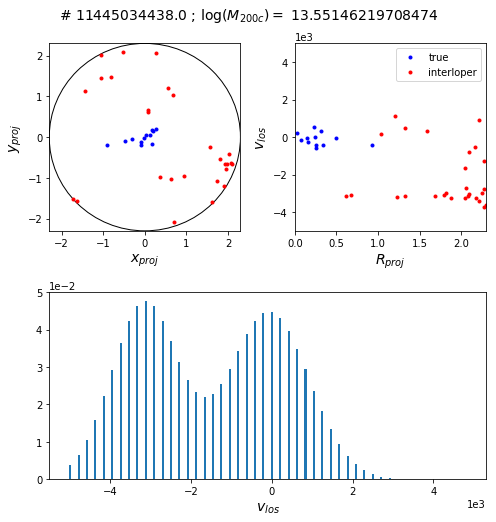

In [8]:
i = np.random.randint(0, len(contam_cat))
# i = np.argwhere(dat_MD['hostid']==3339815782)[0][0]
# i = 47804

print('host id: ' + str(contam_cat.prop['rockstarId'][i]))
print('rotation: ' + str(contam_cat.prop['rotation'][i]))
print('log(M_200c): ' + str(np.log10(contam_cat.prop['M200c'][i])))

f = plt.figure(figsize=[7,7])
gs = mpl.gridspec.GridSpec(2,2)


ax1 = f.add_subplot(gs[0,0])

x = contam_cat.gal[i]['xproj']
y = contam_cat.gal[i]['yproj']

ax1.plot(x[contam_cat.gal[i]['true_memb']==1],
         y[contam_cat.gal[i]['true_memb']==1],
         '.', c='b')
ax1.plot(x[contam_cat.gal[i]['true_memb']!=1],
         y[contam_cat.gal[i]['true_memb']!=1],
         '.', c='r')
circle = plt.Circle((0, 0), radius = rcut, edgecolor='k', facecolor='none')
ax1.add_artist(circle)

ax1.set_xlim(-rcut,rcut)
ax1.set_ylim(-rcut,rcut)
ax1.ticklabel_format(style='sci',axis='both', scilimits=(-1,1))
ax1.set_xlabel('$x_{proj}$', fontsize=14)
ax1.set_ylabel('$y_{proj}$', fontsize=14)


ax2 = f.add_subplot(gs[0,1])
x = np.sqrt(contam_cat.gal[i]['xproj']**2 + contam_cat.gal[i]['yproj']**2)
y = contam_cat.gal[i]['vlos']

# ax2.plot(np.arange(0,6./5*rcut,rcut/5.),[0]*6, c='k', linestyle='dashed')

ax2.plot(x[contam_cat.gal[i]['true_memb']==1],
         y[contam_cat.gal[i]['true_memb']==1],
         '.', c='b',label='true')
ax2.plot(x[contam_cat.gal[i]['true_memb']!=1],
         y[contam_cat.gal[i]['true_memb']!=1],
         '.', c='r',label='interloper')
plt.legend()

ax2.set_xlim(0,rcut)
ax2.set_ylim(-vcut,vcut)
ax2.ticklabel_format(style='sci',axis='both', scilimits=(-1,1))
ax2.set_xlabel('$R_{proj}$', fontsize=14)
ax2.set_ylabel('$v_{los}$', fontsize=14)



ax3 = f.add_subplot(gs[1,:])
kde = gaussian_kde(contam_cat.gal[i]['vlos'])
pos = np.arange(-vcut,vcut, vcut/(48/2.))
y = kde(pos)
y /= np.sum(y)

ax3.bar(pos, y, width=50)

ax3.ticklabel_format(style='sci',axis='both', scilimits=(-1,1))
ax3.set_xlabel('$v_{los}$', fontsize=14)

f.suptitle('# ' + str(contam_cat.prop['rockstarId'][i]) + 
           ' ; $\log(M_{200c}) = $ ' + str(np.log10(contam_cat.prop['M200c'][i])), 
           y=1.03,fontsize=14)

plt.tight_layout()

# f.savefig(os.path.join(img_savedir,'MD_cluster.pdf'))

In [9]:
cat = contam_cat
i_list = np.argwhere(np.abs(np.array([np.mean(cat.gal[i]['vlos'][cat.gal[i]['true_memb']==1]) for i in range(len(cat))]))>1000).flatten()
i_list = np.arange(len(contam_cat))

/home/mho1/.conda/envs/jupy/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/mho1/.conda/envs/jupy/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mho1/.conda/envs/jupy/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


host id: 11414983626.0
rotation: 2.0
log(M_200c): 13.600929355210306


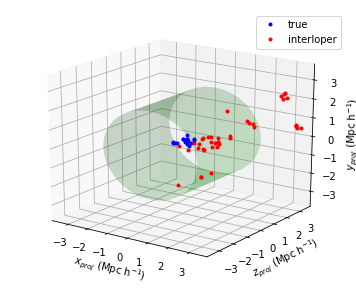

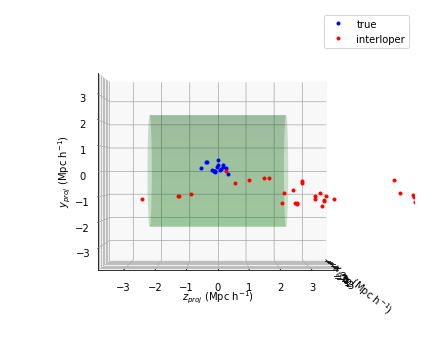

In [124]:
i = np.random.choice(i_list)

print('host id: ' + str(contam_cat.prop['rockstarId'][i]))
print('rotation: ' + str(contam_cat.prop['rotation'][i]))
print('log(M_200c): ' + str(np.log10(contam_cat.prop['M200c'][i])))


rcut = contam_cat.par['aperture'] #Mpc/h
vcut = contam_cat.par['vcut'] #km/s

f = plt.figure(figsize=(6,5))
# gs = mpl.gridspec.GridSpec(2,2, wspace=0.1, height_ratios=[1,1])

ax1 = f.add_subplot(111, projection='3d')

# Scatter graph
x = contam_cat.gal[i]['xproj']
y = contam_cat.gal[i]['zproj']
z = contam_cat.gal[i]['yproj']

ax1.plot(x[contam_cat.gal[i]['true_memb']==1],
        y[contam_cat.gal[i]['true_memb']==1],
        z[contam_cat.gal[i]['true_memb']==1],
        '.', c='b', label='true')
ax1.plot(x[contam_cat.gal[i]['true_memb']!=1],
        y[contam_cat.gal[i]['true_memb']!=1],
        z[contam_cat.gal[i]['true_memb']!=1],
        '.', c='r', label='interloper')

# Cylinder

def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
    z = np.linspace(-height_z, height_z, 50)
    theta = np.linspace(0, 2*np.pi, 50)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid

Xc,Yc,Zc = data_for_cylinder_along_z(0,0,rcut,rcut)

# # Draw parameters
rstride = 50
cstride = 2
ax1.plot_surface(Xc, Zc, Yc, alpha=0.2, rstride=rstride, cstride=cstride, color='g')
# ax.plot_surface(Xc, -Yc, Zc, alpha=0.2, rstride=rstride, cstride=cstride, color='g')

ax1.view_init(20,-55)
# ax1.view_init(0,0)

# ax1.set_xlim(-5,5)

ax1.legend()
ax1.set_xlabel("$x_{proj}$ (Mpc h$^{-1}$)")
ax1.set_ylabel("$z_{proj}$ (Mpc h$^{-1}$)")
ax1.set_zlabel("$y_{proj}$ (Mpc h$^{-1}$)")
ax1.ticklabel_format(style='sci',axis='both', scilimits=(-1,1))

box_max = 1.6*rcut#np.abs(z).max()
ax1.set_xlim(-box_max, box_max)
ax1.set_ylim(-box_max, box_max)
ax1.set_zlim(-box_max, box_max)

f = plt.figure(figsize=(6,5))
# gs = mpl.gridspec.GridSpec(2,2, wspace=0.1, height_ratios=[1,1])

ax1 = f.add_subplot(111, projection='3d')

ax1.plot(x[contam_cat.gal[i]['true_memb']==1],
        y[contam_cat.gal[i]['true_memb']==1],
        z[contam_cat.gal[i]['true_memb']==1],
        '.', c='b', label='true')
ax1.plot(x[contam_cat.gal[i]['true_memb']!=1],
        y[contam_cat.gal[i]['true_memb']!=1],
        z[contam_cat.gal[i]['true_memb']!=1],
        '.', c='r', label='interloper')

ax1.plot_surface(Xc, Zc, Yc, alpha=0.2, rstride=rstride, cstride=cstride, color='g')
# ax.plot_surface(Xc, -Yc, Zc, alpha=0.2, rstride=rstride, cstride=cstride, color='g')

ax1.view_init(0,0)
box_max = 1.6*rcut#np.abs(z).max()
ax1.set_xlim(-box_max, box_max)
ax1.set_ylim(-box_max, box_max)
ax1.set_zlim(-box_max, box_max)


ax1.legend()
ax1.set_xlabel("$x_{proj}$ (Mpc h$^{-1}$)")
ax1.set_ylabel("$z_{proj}$ (Mpc h$^{-1}$)")
ax1.set_zlabel("$y_{proj}$ (Mpc h$^{-1}$)")
ax1.ticklabel_format(style='sci',axis='both', scilimits=(-1,1))


plt.tight_layout()

host id: 11943359783.0
rotation: 1.0
log(M_200c): 14.048713638080969


([], <a list of 0 Text yticklabel objects>)

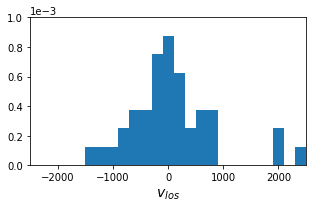

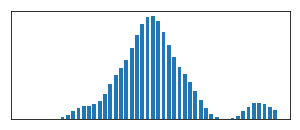

In [53]:
i = np.random.choice(np.argwhere(contam_catdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAagAAAFgCAYAAADuCe0ZAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAIABJREFUeJzsvXmUJFd97/mNyH2trL2yunqpXqq36u7qnRYNFvaAH7aesI2Q0cEsI7DGGGxAB4bl+HkETwf7vQFZ1jE24E3AszXYxmP3A8FjhJChhWi1UJdavUjdavVSVbnvS2RkbHf+yIqoyLVyiazKqr4fjk41VZmRNzIj7zd+9/e9vx9DCAGFQqFQKL0Gu9oDoFAoFAqlFlSgKBQKhdKTUIGiUCgUSk9CBYpCoVAoPQkVKAqFQqH0JFSgKBQKhdKTUIGiUCgUSk9CBYpCoVAoPQkVKAqFQqH0JOYWH0/LTlAoFAqlU5hmHkQjKAqFQqH0JFSgKBQKhdKTUIGiUCgUSk9CBYpCoVAoPUmrJgkKhUJZt4iiiPn5efA8v9pDWRfY7XZMTEzAYrG09XymxX5Q1MVHoVDWLdevX4fH48Hg4CAYpimjGaUOhBDE43Fks1lMTk5W/pm6+CgUCqUVeJ6n4mQQDMNgcHCwo2iUChSFQqHooOJkHJ2+l1SgKBQKhdKTUIGiUCiUHiKVSuEv//IvV3sYPQEVKAqFQumA554D/uRPSj+NoJ5AybJszAusIajNnEKhUNrkueeAX/kVQBAAqxX40Y+AEyc6O+ZnPvMZXLt2DTMzM7BYLHC73fD7/ZidncWTTz6Ju+66CxcuXAAAfOlLX0Iul8NDDz2Ea9eu4SMf+Qii0SicTif++q//Grt27TLgLFcPKlAUCoXSJs88UxInWS79fOaZzgXqT//0T3HhwgXMzs7imWeewa//+q/jwoULmJycxI0bN+o+74EHHsBXv/pV7NixA2fOnMHv//7v4+mnn+5sMKsMFSgKhUJpkzvvLEVOagR1553Gv8axY8dq7SMqI5fL4Wc/+xne9a53ab8rFovGD2aFoQJFoVAobXLiRGlZ75lnSuLUafRUC5fLpf3bbDZDURTt/6t7jBRFgc/nw+zsrPEDWEWoSYJCoVA64MQJ4LOfNU6cPB4Pstlszb+Njo4iEokgHo+jWCziu9/9LgDA6/VicnIS//zP/wygVMXhpZdeMmZAqwiNoCgUCqWHGBwcxBvf+EZMT0/D4XBgdHRU+5vFYsEf//Ef4/jx45icnCwzQfzDP/wDPvzhD+Phhx+GKIp497vfjQMHDqzGKRgGrcVHoVAoi1y+fBm7d+9e7WGsK+q8p7QWH4VCoVDWLlSgKBQKhdKTUIGiUCgUSk9CBYpCoVAoPQkVKAqFQqH0JFSgKBQKhdKTUIGiUCiUHuKOO+5Y9jGPPvooOI5r+dgf+MAH8C//8i/tDGtVoAJFoVAonWBwv42f/exnyz6mHYFaiXYdkiQZejwqUBQKhdIuar+N//JfSj8NECm32w0AeOaZZ3DnnXfinnvuwa5du/Ce97wHhBA89thjCAQCeMtb3oK3vOUtAIAf/vCHOHHiBA4dOoR3vetdyOVyAIAtW7bgC1/4Ak6ePKmVQVL50Y9+hIMHD2Lfvn24//77teKyW7Zswac//WkcO3YMx44dw2uvvQYAiEajeOc734mjR4/i6NGjePbZZwEADz30EB544AG87W1vw/ve976Oz18PFSgKhUJpl1r9Ngzk3LlzePTRR3Hp0iW8/vrrePbZZ/GHf/iHGB8fx49//GP8+Mc/RiwWw8MPP4ynnnoKL774Io4cOYJHHnlEO4bdbsfp06fx7ne/W/sdz/P4wAc+gG9/+9t4+eWXIUkS/uqv/kr7u9frxfPPP4+PfvSj+PjHPw4A+NjHPoZPfOITOHv2LL7zne/gQx/6kPb4X/ziF/j3f/93/OM//qOh509r8VEoFEq7dLnfxrFjxzAxMQEAmJmZwY0bN3Dy5Mmyx/z85z/HpUuX8MY3vhEAIAgCTugq1/72b/921XFfffVVTE5OYmpqCgDw/ve/H1/5ylc0Mbrvvvu0n5/4xCcAAE899RQuXbqkHSOTyWhFbe+++244HA5DzlkPFSgKhUJply7327DZbNq/TSZTzRwPIQRvfetb8cQTT9Q8hr5dh/45jWAYpurfiqLgueeeqylEtV7DCOgSH4VCoXSC0f02mkDfkuMNb3gDnn32WS1XxHEcrly50vD5u3btwo0bN7TnfOtb38Iv/dIvaX//9re/rf1Uo7G3ve1t+Iu/+AvtMSvRe4pGUBQKhbLGeOCBB/D2t78dfr8fP/7xj/H444/jvvvu04wODz/8sLZ8Vwu73Y6///u/x7ve9S5IkoSjR4/i937v97S/F4tFHD9+HIqiaJHZY489ho985CPYv38/JEnCm9/8Znz1q1/t6nnSdhsUCoWyCG23UXLxvfDCCxgaGjLkeLTdBoXSIoQQKIqy7Fo8hUJZPegSH+W2gRACQghkWYYsy+B5HkAp+WwymcCyrPaTZdmyRDGFcrtw48aN1R6CBhUoyrpGjZQURYEsy1rExDAMWLa0gKD/m16UVMHSCxgVrvVP5XVAaZ9OVyioQFHWHaooqZGSil6U9EJVazJS/y5JEkRRLPsbwzAwmUwwm82aaKnCRSe2tY3dbkc8Hsfg4CD9LDuEEIJ4PA673d72MahJgrIu0C/dKYqi/b6RAAmC0PIkpH5f1OVClVu3bmHz5s1a1KUXLypcawdRFDE/P68t/1I6w263Y2JiAhaLpfJPTX0haARFWbOoS3eJRAIejwfAkiB1SxDU41YePxaLYcuWLVrkJghC2d9pnmttYLFYMDk5udrDoCxCBYqyZqg0OagRzMWLF3HixIlVn+wbRWs0z0WhtA4VKEpPU0+UKiOlXp7QaZ6LQmkPKlCUnqNZUVrr1BNX9XxlWYYkSZibm4PX60VfX59m9KB5LsrtABUoSk/QjB38dqFSuNQCoSaTqWy5kOa5KOsdKlCUVaMZOzilfF8OzXNRbieoQFFWlEo7+IsvvohDhw7RJaoO6STPBQBWq5UuF1J6DipQlK5Ta4+SOgmqe5HohNgdmslzvfDCCzh8+HDZc2iei9ILUIGiGI7e5KDmlYDaJgeGYWhpmVWgcslQjaQANJXn0i8V0uVCSregAkUxhHadd6pAUXoHmuei9ApUoChtY4QdnArU8vRKhNlunqtQKMDn89H9XJSWoQJFaQn1LlqSJITDYQwPDwOgzrvbmeXyXBcvXizLcamPpXkuynJQgaIsSy07uCzLuH79OkZHRzs6No2g1i964arMcQGgeS7KslCBotREHynVqw5uhLBQgbr9aFSeiua5KHqoQFE0GtnBKycBo4RlNQSKEIJEIoFYLAaHwwG32w2Hw1F2l99r3C6TcDt5Lp7nYTab4Xa7aZ5rnUEF6jamFTt4JUZ98Y0SqOWMBIqiIJlMIhQKIZlMwufzwev1gud5xONxcBwHQgjsdjtcLpf2n9PpXHXhohFm4zxXNBqF3W6H2Wyueg7Nc61tqEDdZtwuhVgBaL2iQqEQUqkU+vv7MTY2ht27d5dtElYhhIDneeTzeeTzeSQSCXAcB0VRelK4KEs3OOqynwrNc60PqEDdBlSK0muvvQa/3w+Xy7XqomREBKXf7KsoCuLxOMLhMFKpFAYGBjA+Po69e/dWiVGt4zgcDjgcDgwNDZU9djnhEkURmUwGLpeLCtcKUyt6pnmu9QEVqHVKo+rgPM9DUZSe+NIZIVDqMk8kEkE6ncbg4CA2bNhQJUq1XrvZMTYSLo7jEAqFsLCwgHw+D0VRYLPZqiKuyiWoVuiFz6pXaXWfWKM8FyGkZp5LvdnR1yyky4XdhwrUOqLZ6uC95JxrdyyKoiAWiyEUCiGXyyEej2NiYgLT09MrNmHohctqtWL37t0ASp9DsVjUIq5uChfFuI3MjYTrxo0b8Hg8ZY5W9Tk0z9U96DdjjdNIlOp9QViWrfqirRatCJQsy2WiNDg4iE2bNoHjOOzcubNnltYYhoHdbofdbsfg4KD2+1rCxXEcZFmGzWaD0+ksEy9VuHrlZqJX6fZqgHqNqgKkQvNc3YcK1Bqklh0caCxKetZSBCXLMqLRKEKhEPL5PIaGhrBlyxZ4vd6yPEOvnE8jGgmXIAiacAWDQeTzeciyDKvVimKxCIvFAkJImXBRShBCul7FhOa5Vgd6pa8B1LVxURRrClKrF3avT+iSJGmRUj6fx/DwMCYnJ8tESc9a/2IzDAObzQabzYaBgQHt96pwvfLKK1AUpUq4KpcKLRbLKp7F6rEStQpXIs+VzWbh8Xhgt9tpnmsRKlA9Si07+KVLl7Bhwwb4fL6OLtheXOKTJEmLlAqFAoaGhrB161Z4PJ6mzrWXBbdd9MI1NjYGj8cDoDziUg0a+XwekiTBYrGUCZfL5Vr3wtUrxXSboZFwzc3NYevWrTWfc7vmuahA9RDL7VFScyydXpS9EkFJkoRCoYDLly9DlmUMDw9j+/btcLvdLd+t9sL5dIvKc6sXcQEoWyoMh8OrLlwr8bmshECtxPEVRYHZbKb7uXRQgVplGolS5bq6UZHPak7ooigiEokgHA6D53kAwJYtWzA+Pr4q41lvWK1WWK1W9Pf3l/2+nnCZzWbwPI/5+XlNuKxWq2Hj6cXlt16lltmj0zzX1atX0dfXh8nJye4OvktQgVoFGu1RapTsVe+yOoVl2RUVKFWUQqEQBEHAyMgIpqam4Ha7cenSJTgcjo6Ov94jKCOoJ1zFYhEvvvgiGIZBNBrFjRs3IIoizGZzVcTVjnCtxOeyEnv6VioSbMXssVyeSxRFfOc738GePXuoQFEa0+wepUYYJSxGCV0jBEHQREkURYyMjGDXrl1wuVyGv1a7k9N6ufPuBIvFAovFgg0bNpT9XhRFLeJaTrgsFsuK1G2sx0q4+FYCRVEMOQ+9cAmCALvd3vExVwsqUF1EXbpLpVJlE3O7yU2jhMXIiEM/yQuCgHA4jFAoBFmWMTIygj179sDpdHZ9LOs5gloNIbVYLPD5fPD5fGW/F0URHMchl8shFotpwmUymWpGXOtliW8l3v9unAfP81SgKEvol+5UMTl//jzuuOOOji8+o3JQRkZiPM8jGo0iHA5DlmWMjo5i7969DUWp8hhG1OKjtEerk6LFYkFfXx/6+vrKfi9JkhZxxeNx3Lp1C4IggGVZ8DyPubm5MuEy8jNbT5Gw0edRLBY7XkJfTahAdUgz1cGNsoMaFW10GokVi0Ut0f7SSy9hbGwM09PTbX0RaAS1PjCbzTWFi+M4XLp0CSaTqUy4TCYTnE4n3G639rNd4eq2QK3la4tGULchq9WywkgXX6vH4Xke4XAY4XAYhBCMjo7C5XLhyJEjHRdBNaqaOaV1uj25m0wmWCyWKpemJEngOA75fB7JZBLz8/MoFotgWbZqqdBmszUc40oI1FqN0IrFIhWo24Fe6KNk5BJf5S72WvA8j1AohHA4DIZhMDo6iv3792sXfCQS6QlxWauTx+2M2WyG1+uF1+st+307wtVtFx8VqNWDClQD2rWDd4uVMEkUCgWEQiFEIhGwLIvR0VHMzMzAZrO1dJyVplfG0Q26OUH2WvRRT7hkWdZyXMlkEgsLC+B5HizLguO4sn1cdrvd0HMyyl23GvA8T3NQ6wlVlNLpNKxWa1n1hnYvUnUiN8IkYVQOSn8cjuO05TuTydRQlIweD13iW98YJYAmk6mucJ09exZWqxXpdBqBQEATrsrq8O0KF42gVg8qUKhdHfzq1ata2Z1OUSOfTttBGLlRt1gs4vXXX0c4HIbFYsHo6CgOHTrU0mbMtSwu6oSzlicfI+i1CKpV1DI/fr+/7PeyLGtLhbWES2/QcDgcDcdoRATFnjkD8+nTkE6ehHL8eNXfu/UdKBQKNIJai9QSJX0+yWQyGbaZVc0ddSpQneag8vk8QqEQAoEAFEXBtm3bcPjw4bZL2xghmKslcmrUaLPZ4Ha7l03EU9pjtW4ATCYTPB6PVmBXRZZlFAoF5HI5ZDIZBINBFAoFMAxTFXGpwtXpObBnzsB5992AIMBqtYI7dapKpLr1PtEIao2gNzmoeSWgvsnByIrfq1lDL5fLIRwOIxKJwGq1YmxsDDt27EA6ncbExMSKj6cbx2gW1fQRCoVgNpvR39+PVCqFhYUFFIvFss2mbrfb8Lp0vchaj6BaxWQywe12V62MKIqiRVzZbBahUEirFan25IpGo2XC1Szm06cBQQAjyyCCAPPp0xAqBKpbeS5Zltd0/7C1O/Im6MR514sC1exxstmsJkp2ux1jY2M4cuSIVr06Ho/3XEWKbo1DEARNlABgbGxMW8oUBKFsAtVvNtWX91ErgauitdJNA3ttkm+FXrg+moFl2brCFYvFMDc3VyVc6lKhPuKqJTLSyZOlqhqCAJhMYObmwJ45UxZFddOIsVavHWAdC5QsyxBFsW07eK8KVK0vPCEEuVwOoVAI0WgUDocDo6OjOHbsWM2JtFtmi9U8hh5RFBEOhxEMBiHLMsbGxsrs8fWot9m0Xrdbm82mCZcama81t9d6KRPULViWhd1uh8vlKuvVpCgKCoWCdl1EIhEUCgUAgMPhKF8qPHoU3KlTsDzxBCz/8A+wfOMbsDzxRNlS31q8dlaCdStQKu1+6L0oUPqcDyFEu6OLxWJwOBwYGxvD5OTksnf3Rlak6AWBAkrRTyAQQCgUQrFYbLnkUiNqVQInhKBYLCKfzyOXy0EQBLz44otQFAUOh0OLttxud8tLQuuJtRz9qdQ6B/2+LD11hYtlsc1qxSZRBKMoIIIA009/WiZQRr9P+pvztcq6FahOm3YZaZIwUhCKxSJeffVVxGIxuFwujI2NYevWrS0tOa0XgZJlGdFoFPF4HMlkEn6/X2vj0W0YhoHdbofdbsfg4CAikQiOHDkCQoiWhFcnKI7jwDBM2V11rxgzbrccVDu0Et3UEy7m5z8Hk8+DmM2ALEMxm3FhaAiZs2dht9u1JedcLgen00mjqUXWrUB1Sq9EUIQQZDIZbfOsoigYHx/H9u3b23YF9lLjw1aPoSgK4vE4gsEgstkshoaG4PV6sWXLlqpeR6uB6garjNzUJHwul0M6nb5tjBnrQaAMcfG94x3AYg5KfP/7Id53H3YePw5FUcDzPGKxGDKZDG7evAmO40AIqVoqvB2FiwpUHViWLevb1OmxWhEEQgjS6TRCoRDi8Tg8Hg9GR0cxPj6Oa9euYWxsrKPx9FoEtdx7QwhBIpFAMBhEKpXC4OAgNm3ahL6+PjAMg0uXLnU0hpWgXhK+GWOGIAhd699FI6jl6TQ/VObiA0A2btSW9tR9WX19fSgUCti5cycAaJG4em3EYrEq4VL3cjkcjpo3q7Isr3lBowJVh5UWKEIIUqmUJkperxdjY2OYmprSLjL1Au2UXhIooLbTS30/gsEgEokE+vv7MT4+jr179675CU9PM8YMnudx+fJlEELKjBnqnXUvT0JrxcXXiE5FtszFZ7VCOnmy6jGVIqiPxIeHh8vGwvO8dm0kEglwHAdFUTQzh8vlAsdxWvWMtQwVqDo0W1C12WPVEihCCJLJJEKhEBKJBPr6+jA2NoadO3fWnHRW2q6+HEY78NTlzGAwqIm03+/Hrl27Gk7CvWJ3NxK9MSOZTGL79u2w2+1lxgz95NSuMWOtu/hW4nPvNIJSjh8Hd+pUw0oSzZokGIaBw+GAw+HA0NCQ9vtK4frmN7+JJ598EuFwGO94xzuwd+9eHDp0CPfcc0/L4+d5Hm9+85tRLBYhSRLuuecefP7zn2/5OO2wbgXKiLp33chBqctV4XAYiUQCPp8Po6Ojy07C6nF6KfIxSqB4nseVK1cQjUbhdrs1s0MvRwarQaUxQ6WXjRnrYQnRiNdQjh+v2pxb9vcORbBSuB566CF86EMfwoMPPog///M/x6VLlxCLxdo6ts1mw9NPPw232w1RFHHy5Em8/e1vxxve8Ia2x9ss61agOsVIgWIYBplMRnOb+Xw+jI2NNSVKlcfplcin0+OoZZfm5+dhMpmwfft2bNu2rS3jx3qMoFqhE2OGyWTq6nu3HgRqJfYoEUIMfw21m+6WLVuwZcuWto/DMIyWOxVFEaIorthNzroWqE4mrk4FSlEUJBIJbfOsy+XCtm3bsHv37o72ZhkxmazWEp/ayiMUCmlll7Zv3w6e5zsyfqynnFQt2p2EmzFmJJNJpFIpPP/8812pmLEeBGqtiqCR3XRlWcbhw4fx2muv4SMf+QiON4gGjWRdC1QntLMPSrVAh8NhpFIpDAwMYHx8HB6PByzLli3LtEOvRVDNCGaxWNREiWVZjI2NlRWoVUsQdcrtHEG1it6YoV6bu3fvbqpiRqvGjG5/LislHt0ubdUNgSoWi8u2zGkWk8mE2dlZpFIp/OZv/iYuXLiA6elpQ47dCCpQdWg2ylBFKRQKIZ1OY3BwEBs2bChzm3EcZ4gjsBeW5po5jiAICIfDCIVCUBQFY2NjXW16eLsv8RlFMxUz2jFm0AhqebohUIVCwXAXn8/nw5133okf/OAHVKBWk0Y2c7WAZCgUQjabxcDAACYmJjA9PV3zQjbKEWjUl6QbpZckSdJESRRFjI6OYnp6etleNN2oxUdpnuUm306NGcVicVXHbwQrkYMyoh1PJUYt8UWjUVgsFvh8PhQKBTz11FP49Kc/bcAIl4cKVB0qJ3FZljVRyuVyVZtFWznWamPUF1q1yYfDYRQKBc2NWFnmZbmxdGsv1Xqim5NwO8du1pgRj8chCALi8XhXKmaslIFhLYqgUQIVDAbx/ve/XyuIfO+99+Kuu+4yYITLs64FqlOThCzLWv4kn89jaGgIW7ZsgdfrbemC7TWB6gQ1elQ30Hq9XkxNTVU1hmsWGkEtT7PvjyzLUIiyVLkfy1fwN1rYK40ZTqcTkiTB7/eXVUUwqpXJWhWPSrrp4uuU/fv349y5cwaMqHXWtUC1gyRJiMViCAQCSCQS8Hg8mJycbFmU9Kz1HIk+z5bJZDA4OIgtW7bA5/OBZdm2xQmgEVQrEEJQEArgihxESYQgCRBlEaIsQpIlSIpU97kMw8DMmmGz2Er/mUs/eYEHQfdt5p20MmlkzKA5qPoY6eJbLahAoSRK0WgUoVAIhUJBi5REUcTU1FTHx1+LEZS6fBcMBpFMJrU8m8/n076smUymJ8Rlrd8A1IMQAq7IIZ6L4/Xw6xAVEbKymBclAMMyi/9c/twJIZqY5fic9nu1XI7iUuBxeEr/2T0wscbkQ5ab3Ds1ZnSjTUWr52AE3XLxUYFao0iShEgkonXIHB4exvbt2+F2u7Xkv1GT3loRKLVIrVpqyOfzwe/3Y8+ePXXdWZ2e13pfnmsVWZaRzqeRzCeR43NQiIJYNgY354bFYimJEoOO3ncGpWMQEChEARigKBVRzBYRy5aqDbhsLrjtbngcHris7df7a2dyX86YoQpXJBJBLpeDKIq4dOlS1ypmrJRJohsRlM/nM/SYK826FqjKC1QURUQiEYTDYfA8j5GRkbr9g4zacwT0tkCpjQ+DwSBisRg8Hg/8fn/deoB6esUivh4iqHg2jlQ2hWwhC8JUnAsDsCYWDMuUoiXSurAzYLTnN/Ne5Yt55It5hNNhmFgT+l39GHQPwmlrvQGkUUJRq4BqJpPBwsICNm7c2LVWJislUEbfrBmVg1pN1rVAAUuiFAqFIAhCQ1HSY+TF0osCJcsyrl69img0CqfTCb/f33KPqV4Rl1Y/K31RWovFoiX1LRZLR+NolQyXQTARRI7PLZkZFk9FjXKApUin1VwRAQHLlCZWBQoYUv0+EUK016mHrMiIZWOIZWNwWp0Y9Ayi39Xf1DLgSlSSMJlMy1bM6MSYsVJ5LrrEV826Fqjr169jYWEBIyMjLdufjcTIaAxo/wvDcRxCoRDC4TCKxSJcLldTLeLr0SsCBTSXx+I4DsFgEOFwGE6nE0NDQxBFEdFoFNevX4ckSWXJebfbbXiTOF7gcTNyE/PxeZhZM7wu79LxW8wr1YNlWG0JT2v7vZwKNQkncODiHBaSC/A5fBjyDMFlr/+96vbk3ijyMMqYsVZzUNQk0eNs3rwZmzZtWu1hGFZDT3+sZr8wPM9rVnmz2YyxsTEcOXIEZ8+exfj4eEdj6ZWltUbvhSAICIVCCAaDYFkW4+PjOHbsGMxmM0RRLJvgKpPz8XgcHMcBQNnE5Xa7YbVam/4MZFnGXGwONyM3EUlH0Ofsw5B3qLTkppQiAAICwpCOhEkdjwIFzR6GENKyeKmvk+ASSBQS6HP0wd/nh8NavZzUi7X4WjVmCIKgbVRtpZVJK1CBqs26Figjmw52Og4jK6MvdzGrk7Ja525sbAyHDh0yvJV4r0ZQsiwjEokgEAhAFMWGpZYqx1IrOa/ffJpMJjE3N6dNWqpoybIMWZbLlkjDyTBuhG9gPj4PURbhsruweWQzLGaLtvRGTKQkKG3CsqwWKXXTLs4wizmsxdchWFoaTBfSSBfS6Hf2w9/nh82y9D73okDVopExY3Z2Fm63u6utTKhA1WZdC1SvOMS61VtKjyiKCIfDCAaDkGUZY2Nj2L9/f1cv0F4RKFW01f1r2WwWIyMj2Llz57K5xmaoVxVcXSpSnWTnzp1DlssizseR4lNQWAUOuwNWqxVDniEM9Q1pk3oroqSfhAkhYNjSJlzNhdcBDSd4ZnFpkC09brnPKcklkSqkMOAawJh3DFazdc0IVD3U3ODQ0FDZDV4zrUxaMWZQk0Rt1rVA9QpGC5Q6Ueit8sViEaOjo9i7d29V+Zl6dPrlXm2BUs0OoVAIHMdhdHS06fJTRqAuFTlcDpy5eAYehwcJkoAIEWABvsAjk8qg39kPJacgl85pTeWcTmdrhhQw2mevRTBdQr2TV4hSchS28FKEEMRzcSTyCYx5x7puDlqtjbrNtDJpxZjRjkmCPXOmYZdeGkHdBhjxBTDaxad24+U4rmlXYr0xdVKg0ojcWjsCxXEcAoEAIpGI9qX3+/0rmm+UZRlz8TncDN9EKBnCteA1bHNuA8uwsFqtsNltpcr2QxtgMVsgyzIJwz01AAAgAElEQVQKhQIKXAGJRALz8/NQFKUkcIuC5XA4YLfZNaMEUHqPGYYBYTqPlmpBQJZKIy0u4WnRXQeXPSEEwXQQ8UQcu5y7jBlsndfpJQNDu8aMYrEIjuOabmXCnjkD5913A4IAq9UK7tSpKpGiEdQ6x4hJHOg80lBLDalVHex2O7Zu3QqPx7Oq5ZeM2qjbzDgEQUAwGEQoFILJZCozO9y6dWvFlnPDyTCuh69jIb4AURaxWPEOgG6yZAGnw4nxgXFtsqllhSaEQBAETbiSySQKfAFmkxk2u00TLpl0KY+6uISnCmA3DC8FsYBrsWswO80Y9Y6uCXNBJUaI4HLGjHA4jLm5uWVbmahREzM3BwgCGFkGEQSYT5+uailPI6h1jtq00AiBahVCCBKJBILBIFKplFY9XVEUbN68uePcymovzzWDuoQZDAYbmh26PY50Po3r4euYi84hX8xrosSAgUIUmBiTZusGAKfNiQ2DG5b93BmGgc1mg81mw0D/QKlCBFGgKAp4ngfHcUin0+ALPF555RVYLBYt0lJ/tnNtlS3h6cwO3UDdZxVMB5EupLFpYFNNt18nx1+rpY70xgyr1Yo9e/Zor1dZMYPjOPRduoSDn/oUWFEEMZsBk6l0xVmtkE6erDo+3QfV4/Ta0txyEEKQSqW0SuH9/f0YHx8va35oMpkM64bbC2WKKsVFjRYDgQByuVxTe9i6IVDqfqWb4ZtI5BNLkkQWX4tdem0FijbJ2612bBhaXpzU5zJMSeT01nCWZctaWeTzeezYsQMKUVDgCuA4TmtxAgA2m61MuCxWS5V13OglvKYhS3uwOIHDlfAVjPWNYdQ7aszhV0CggJU1XNWqmAEAlp/8BKwkgVEUQJYRuusu5AcHkTl0CHJfH1xzc1q0ZbfbwfM8XeJbz6yEQOmrGsTjcXi9Xvj9fuzatavm0oVRm357aYlPURSkUimtgvzg4CA2b97cktnBCIHS71cKJUOlxDXDlhxzyqIo6SKlSqxmKzYMbWi45EQIgYk1aUtqrYzbYrbA4rXA6/WWHY8v8ihwpeaB0WgUgiDAZDLB4XTA5XTB4XTAZrfBzFR/3bseQS06DdUqGQoUBDIBFMQCNvVv6nh5bqUEqheQ3/QmwGoFEQTAaoX3ox+F+/hxDFYYM5566il8/etfR7FYxGc/+1ns27cP09PTOHz48IpXS+kUKlAN6OY+KrX+XTQa1ZL8U1NTy35hjRLN1TI46Mnn85ibm0MymcStW7caCnM3x1G5X0mNlsomV3ZJmGpNiCbGhInhCZhNNUSALBkR1EnaKBMewzBw2B1w2B0YGBgAUPpsJVkCx3HgChyisSgKhQIURYHNtpjbcjjhcDq6Wg2cZUoGD9bEVtUXTBaSEGQBk4OTsJjanzS7USKoV1GOHwd36lSVc6/SmLFjxw58+MMfxh133IHf+I3fwMWLF/H4449j165dLRePnZubw/ve9z6EQiGwLIsHHngAH/vYxww/t3pQgWqA0RFUPp/XSg05HA74/X5s27ZtxevfqcdZKYODnmKxqJkdLBYLhoeH0dfXh/3793c0jlbJcBm8OvcqboRvoCAUai/h6Wrh1X3tRZPBsHcYFrOl+m8so7nvVmIjrbpcyJpYuD1uuD3VpgyO41AoFBBPlCplqDkPp9OpCVfb5a/UGoKLQqwQBa9c6MerF/yYOZbC9ExWe2xeyONK5Aq2Dm2Fw9LeUtTtFEEBJZGqNEPUg2VZ3HnnnXjLW97S9uuZzWZ8+ctfxqFDh5DNZnH48GG89a1v1fJl3YYKVAOMEKhCoaB15H3llVcwNjamuc9Wa0zAypokVLNDIBDQNhEfPHgQNpsNgiAgHA53NA6guSU+XuBxI3wDN0I3kMgnIEul6JgFC1mRS1Flk+WGWGapgkO/ux9iRixFRczi+6L+z4gqGagzCTNL41BI7WKwZQ/XmTJUN1ksFoMoivB6veA4DslUEguBBciyDKvFCrvDrgmX3V5uga88Npjq4rNXLw/iv33uOCSRhcWq4JG/O18mUoIs4ErkCjYPbIbP0XpriNtNoJrFqPfF7/fD7/cDADweD3bv3o2FhQUqUEawWiaJYrGolRpiWRZjY2NwOBw4fPhwR+NRx2RUBNVNgdK3hs/n8xgZGcGePXuqNhF3u5q5LMu4FbuFG+EbCCfCUIgClmHBgoVEFjvQ6kSl0fEYZsm5p0ZFVrMVg95BxIIxrVdTNyMlbRyL41UND51c6yzLaptHVQghkEQJXIFbchPyPADAbrdrhgyXywWT2bQkShXDuHx+FJLIQFEYiCKD2ed9ZQIFlNyE1+PXMdE3gWHPMFphJWzm3aabeW4jxfvGjRs4d+4cjjcZwRnBuhaoTmlFoNRIIBQKQVGUKkv03NycIXc1RpkkjHLx6cWl0oWotob3er0NJ/1uVDMPJUO4HrqO+Vgpr8SC1YSDgCwtvymNHW2qKKmGhkrx8Q/6S0u0zNJxuwEBWernZGAliXrXJMMwsFgt6LOWbzpVFAWiICLP5ZHJZRCOhCGKIkxmk7Y86HSUHIWsicWu6TAsFgJRUmCxEMwcS9Udy3x6vlRWyD3U8fjXEmshj5bL5fDOd74Tjz76aJlJp9tQgWrAcpO4JEmaKImiiNHRUUxPT9e0dhq16bcXI6hcLodgMIhIJAKPx4Px8fGmzQ5GjiOdT+P14Ou4Fb1Vvl+JlKIelmWX6so1kVcCULMPkyoU/e5+2G327kVMzJLRYCUis4ZDWRRqmACb0wab04YBDGh/lyRJs8BHohHwBR6KomBkg4T/84s/xPUrm3HkDTnsPVBAI9vgXGoODMNg0DVY9zF61oNAdSMKNHLbhSiKeOc734n3vOc9+K3f+i3DjtsMVKAaUEug1ErZoVAIhUIBo6OjTfWaMrIqRS/koIrFIubn55FIJPDqq69ifHwcW7dubfn8Oh0HL/B4LfgarsxfgX3OXrWJlmUWRUkhy7rn9Et4ZZGh2vhvcSMtAJhYE4b7WluOapbKJby6OSgj0O1TqjcWAMvm5sxmMzxeDzxez9KhCcFrV1/DvoM57N73ErgCh0sXBbAmtsxJ6HQ4S8uEi9xKliqDDDgHar1U+fBXoBhtt+mGQImiaEj3AkIIPvjBD2L37t148MEHDRhZa6xrger0wlUrSejzKerm0e3bt8Pj8Sx/kEWMtIcbJVCtHkeNGAOBABRFwfDwMLxeb0e5tXYEqjKvlEqlwBd5OD1OzeygusmWa5HOMAxYhtVEST8J6xP/qk1aPU6/u9/wiVFrnVG5hLeMiBiNZocnSqNgp6njsCyLPl9fWUUDWZJR4BfrEsYTmC/MQ5EVWG1WTbj4Ao+d4zsx4GosUivREHEl2r0b/RqFQsGQKhLPPvssvvWtb2Hfvn2YmZkBAHzxi1/Er/3ar3V87GZY1wLVCWo5/VAohOvXrzeVT2lEL7nv1PE0cxx9Gwu1YrhaMV0QBMTj8Y7H0iyhZAivh17HQmypDp6Kei56B129SV1dwlNt0JWtL1iW1SIX9ZhlfwcLn7t1x1klBIubdhddeJ30hepkDNrynWqrZ2qfd9vHr/gcTObadQlFQQRX4LS6hK+//jo2eDZgxDeiPV5tFql/XrcjqJUoRmv0a/A8v2z/s2Y4efKkYVFkO+8lFSgdhBAkk0mtKKvVakVfXx927drVM2WTjNo83EjoVLNDIBDQ6gBOTk5WibNRm30boeaVbkZughO4+nkl1dHW4HBqk8DKaEkVClUglhOKPncfTGwHVeB1LdmNcOF1ghYlst1Zymp2UmIYBlabFVabFT6fb2lJVVEw7BqGxEuIx+O4efOm1r7C7XYjl8vB7XZXNYs0irUaQfVKoVj9ubVzja97gVou4iCEIJ1Oa6WGfD4f/H4/9uzZg2AwiGKx2JWac+3CsiwkSTLkOJXjyeVyCAQCiEajWsmlPXv2dN2BVwkv8Lgevo6boYo6eCgtSzIsU5anaSRK2lKfUrtzrRotNRu9MGDQ7+5f/oE1UJfwViNS0lNWA5B0nhdtSIPl1aqH6spAKUTR9pXFhBimRqe0/ThAyTWrNguMRCJYWFgAIUSrAq7+10mXW3VM3b556IaLrxdabajnlcvlcO7cOUQiEciyDJfLhbvuuusEgACAeULql+tf9wJVC0KIVmooFovB4/HA7/dj586dZRfKSnTCbRUjTRJq1Wy1soPNZsP4+HjT1S2MGgtQf7+SZvFetFmrG0UbuvD01vDFHJQqYgwYSJKERCqBVCoFMIDD4dBKAFmt1oaThcfhqaoYUQ+CpYlntZbwVPTLmprhYQWCtsqNu3XHxjKQFbmmkYWXeNxK3cLkwKT2O6vVioGBAYTDYUxMTMDj8UBRFBQKBU24AoEAeJ4va3WitrBodqM8jaDaQxX2U6dO4fLly7h16xauXr0KRVGQz+cB4M8AvArgFMMwzxBCauYKbiuBUu3Q0WgUTqcTfr8f27dvrzsZ96JAGbGsJkmSVqDWYrHA7/fj8OHDLbt+jLizDCVDeHn+ZSzI1XklmcjaUg9Q31GlipHWcbbSRs4AUIBUJoVEMgGiEPT392Pz5s1QiAKBF8AXeSRiCfBCaTOqzWrTWiHY7LZS+3KGwONa3hijX8JbbvNvM7QrJpXuw1pj6ObeLaCBC46gfF/XMpFKqpBCNBfFsLvcOal/nn7D8ejoUrV0URS11hX6ZoF2u71MuGq1L+m1hojNUiwWDclBtYv6nl28eBEDAwN473vfi/Hxcf1D3sAwzB4AHwWwkWGYrxNCuMrjrHuB4jgOwWAQ4XAYNpsNY2NjmJycbOoOqhcFqt2oRVEURKNRBINBcBwHm82GiYkJbNmypaPxtCOWlXmlUCqEvpE+sIQt6yArK/Kyxy/bs6R7X9Tkfz6fRyKZQKFQgNfrxYbxDbDZS19cWZLBEAZOtxNO91KFC6KUatbxPI9cLodYLAZJkkouM8UBwSXA4Sy1NNCaFapCxDKrv4SnqwFopOGh7fGoVnVd0dxmS0rpWcgswGFxwG0rN1csd24WiwU+n6+sUCohRPt8c7mc1r5EFTm9iYNGUO3z2c9+Vvv3/Pw8hoaGYLVaYTKZGELIJQC/3+j5616g5ufn4XA4cOTIkZZLzfeiQLVyHL3pQzU7qJ14b926taKNGNU6eAuxBfAiD6vZCp/Lh0HPIHJ9OWwd2woTa6p9l0+IZmyQZAmCLECURPAiD0ESqsoUCYKARDKBdCYNh8OB/v5+TExMNJesR6n6tho59aFPG4PNbIPH4UGhUN791uF0QJREZPPZUumfbuZ06qCPlrTIrYmPp+suuMVx6XOG7W44JoTgRvIGdg7v1Cqgtzt+hmHgcDjgcDjKei7JsqxFW9FoFOl0GoVCAbOzs2XRltPpNExUuuXiW22BevrppxGJRGC1WjE4OIivfe1r+MpXvgK73Q6yeOfJMAxDGtyFrnuB2rlzZ9vCoO6DMoKVXOLTt/Lwer0YHx+vMjt0y+CgR1EUhFNhRFIRpHIp2C12DHoGtSUdFavZWrNNhX6sZsZcKr9jssCO8i9ev7UfYSYMk2TCQngBvMTD6/Ni+7btYE31JxGGYZaaBIJt2KOJYRj4PD743L5S99vFihSyIpdq1WXSiMfjWFhY0NpaqE3nnE4nLBaL4ZOQPrmu36vVE+jMEe1ES/UQZRHz6XktH2X05G4ymeD1erVyPplMBoFAAJOTk1q0FY+XqsADgNPprLLAtzqebi3xrbZAfelLX8Lx48dhNptBCMGZM2dqLaE2vDDWvUB1gtERVDfbZLRqduhmM8ZCsYBYJoZ4Jq7lPvqcfWVFVptFS+5XVHcAyu3wHMdhfHwcJw6cgNVmRVEsIl/MI1/MgxO4mhOkuklXc9Yt8/F4nJ6lJTxd91u32w2LxYLNmzdrn3OxWFxqIhiJQhBLTQTVBoJOpxMOu6NudfBaY106cWiGkY5zXC247JpB/bxUUdIbRYwiVUghw2fgtXu7XsdOFQ+1Cvzg4GDZ3ziOQy6XQzKZxPz8PIrFIsxmc5Upo1FU3Y1zMGqjbifcc889uP/++7X/PzY2tmzFnUqoQDXAyIaFRjne9EIniiLC4TCCwSAIIfD7/U0vZRrpwANKX9ZkLol4Jo4cnwNDShOo2l+plTtorZWFQrSoRg+XLzXhSyaT8Hq9GBoaQj6fx4YNG7TH2Cw22Cw2DLgHoBAF+WIeaS6t1ejTNsfWMQ8ASxMHIQQWs6V0J9jEeTAMoxks+geWLOmiKKJQWGzZHgqjwJdatjvsDk20nE5nzfwoAYGJKW3qJaxxEYkRaPbwGlUwuhWlz6fnscu6a1UrSag3J/oNx0Dpc1ajrYWFBeTzeSiKUmWBt9vt2vdwPUZQ733ve7VzUxQFH/rQh1o+BhWoBhgV9ajHMkIQCCHI5/M4d+4ceJ5vWKC2EUYt8UmyhLnoHBLZBGRZ1lpZKFBKbdJbGI/qxtOiLN28I4oiotEoYrEYrFYrRoZHsHHjRrAsi0wmo1pXa8IyLPocfehz9KEoFZHiUkhz6bo3H5rtmchaLsdh73xPicVigcVS0bJdISjwJdFSo0G1F5PTVRIsdRJWGOMjXtUGfmHWg9nnfVVNBRtRVpFjhY0hRamISD7Sk5UkLBYL+vv7tZ5b6nFUC3w2m9VqeZpMJm3/lupANKItey/koNTz+Nd//de2i8yue4Hq5OI1MoLqRKBUs0MgEEAikQDDMNi9e3dLtQBrjacTgSKEIJKK4Eb0Brx+r3bX3MoSnrYcVKeVhaIoSCaTiEajEEURQ0ND2L17d9UXuNFGYnWs6rgsJguGPcMYcg8hzaWRyCbAieXuVjVq09uvG+XIOoFhGS1y0l6fEMiSjByXA8dxEEQBFy9eBGti4XSUHqsWWW2UY2uWVy704//62H6IQu2mglVjVt/XJs0Y3RKQUDaEomTMRvp6GCWADLP0OY+MjGi/lyQJ165dg6IoiEQiyOVykCQJNputygLfSpTF83yZQK4WkiTh0UcfpQLVDYzOQbUqdtlsFoFAALFYDH19fRgfH8fk5CSuXr3akTgBnS3xZbgMFmILKArFUjHdFvNKWskhRanah6O274hGo8hkMujv78emjZvgdDnrHW7xiaUfavRDlNpmBxWGYeCxe+C0OCHKImL5GLJ8/UnZau68MnQjCCltRFYL15ptZvhsPvj6fUilUtizdw/O/8KFp55yYWpvABu3zqPAFaAoCux2uzb53bg6hpfPDWLmWLqpSIgQgovnhiAKbMOmgmUbfXtkeZEQgggXWdPFYs1mM6xWK1wulyZcag5TXSaMxWKaKUNvga+sS6inF5b4gJJA6fektQoVqAYYLVCiKC77uEKhoO3bstvtGB8fx44dO7QvSaFQWLWis4IoYD42j3Q+vfTcJueGWtGM/rnFYhHRaBSJeAJ2hx0jIyOYnJxs2hoOYKkqeQtLi0BJfMb7xsE7ecRyMeSF6uVC1dZsNFqR1sX/6tUTPPVPo3j04R1QFAZW6w4tyiEKAV/kweU5/OKMFV/89EFIEguzWcHn/tuPcOAwB6ezcbv26YNxWKwKRJEpbypYuZm2B4TJc+4CfGdnkTo6g+zBaeSlPLJCtq128c2wEpUkKk0S+hzm0NBS80a1CkMul0MikcCtW7cgCIJWl1BvyFjtjboqxWIRmUym7edTgWrASu2DEkURoVAIwWAQDMM0NDusVsPCLJfF9dB1SHLzdQArl/AqkWUZ8XgcBb6A1157DcNDw9g7vbfpfUQsU7KGq/trXjrnxLkXvDh4JIN9M7mmx6lit9gx0T8BTuAQyUVQFIva35otb9QsWpHWJib9118tiZMslVRMFFgtymHYpf08gZsbIUsmEIWBLANn/mMnXr2QwbZdc5jYcrk08TnsZcuEBAS796XwyN+d13JQ+2fyAMNCYXonWgJK4rT//gfBCiIUqwXn//4RKDYW0Xy0awLVS5UkWJaFx+OpWj1R6xLmcjm88sor+IM/+APk83k899xzeOWVV7B//36cOHGizIG4UjAMgxMnTgBoT+ypQDXAyAuzUlhkWdYqO/A8j7GxMezfv3/ZsNxIN2Czx4mmopiPzTctaCzDAqQUDdSyhmcyGUQiEXAch4GBAdhsNuzdu7epY+tFT19Q9MrlQfz3z+/R8iiP/fWltkQKAJxWJ7YMbEGWzyKai0JSJFjMlpKR4KwPM0ebNxLoYbG4kbbFfUFXLo1DkdUwi4Bha7dOnzmW0iIhk4ngR09ugiwxsFj34pG/O489+0qbTrkCV7JFL8yD53lkM1n0D+Xwn+91w+F0QIalYfmjyihmpeg/+xJYQQSjKGBEEb6zs8DJQ8iJOeSFPFzW1izMzdBLAlUPtS7hwMAANm3ahDNnzuCTn/wk7rjjDjgcDvz85z/H0NBQywJ1//3347vf/S5GRkZw4cKFtsbm9XrxyU9+EkB7FTnWvUCtZokXPQzDaBFDMBhEOp3G0NDQqjU+bCaCIoRgLjqHWDq2/Lh01vBajq5CoYBoJIpkKgm3243R0VF4PB4wDINkItn44GTp4q61H4phGFy+MKrLo7A494K3aYG68JIHs7/wYeZwCtMHloTHY/fAbXcjw2dwYdaDBz+kMxL8TbWRoN77yTKLFdPbdOFN7QnAalMgCAxYFvj4H12tKZDTM1ktEgoHbfjuP/ur8koutwsu99JEPj83D6fTCcbEIMflEIlFIAiCVvLH4Vjcs7WYpK+KYv7uka6LlPr+JY8fwEarBYwoglgsSB2b0R4TyUcwaZ1scJT2WKvFYovFIqampnDixAnce++9bR3jAx/4AD760Y/ife97X0djUW344XAYPM/DbDZjYmJiDABPCKm+09Kx7gVqtVErpy8sLCAej0OSJIyPj2Pv3r1tiedKLfFJsoTrwevIFhq4ufRtMGrklSRJQiwWQywWg8lkwvDwMCYmJpp2numrOyxnxNg9HVqMHlhYLAoOHmlu3fvieS8e/L392vMe+ep57DuQK+VeFt+fYc8wnru8rdxIcLbcSKD/LAkh2jkSQjq2h2/dGS5bgmsUvU3PZDE9k8WFWQ/+17+PVueVAE3w1crmZqsZXq+3zPUlSZK2ZysSiYDneRBCcPR/PQ2mIooxWqDU/lwggMIsWdizB6dx/vFH4Ht+Fqlji9HbxUsAgBSfQlEqwmY2Nu+yUhGU0a9hhEnizW9+M27cuNHxWAqFAr73ve/h2Wef1QvxHwG4DuDLjcodUYHqEoVCAYFAAOFwGE6nEx6PBxaLpemlrHqsxBKfoii4FriGPF9tFijLK2FJPPQFW1OpFKLRKIrFIoYGhzC1YwpWW2MXnL6QqLYfCktLeMuxbSqKx/76Uss5qNkX+iCKi8IjMXjpRR+mD2SrxPuX7zTh0UcAQSAwWwhmjlbf+KlVE8oMBQbNO6rwtPL4MlE7kNUMGZX7lmpNjmazuSrfQQiBmClA+X/+JyBKUEwmnBvqQ+LKFW0fj8Ph0DagtgPLskutSWocIntwuq4gRvIRbOzb2Nbr1mM1TBJG0AsuPvW9O3/+PD73uc/hU5/6FAYHB9V+dmcBRIDG5Y6oQBmIIAgIhUIIhUKa2eHo0aOwWCxIp9OYm5vr+DWMutOqF0ERQnA9dL1KnFh2Ma+kVCTOF4eTz+cRiUSQTqfR19eHiYmJ0tJRM+NllprotVp1Qs++mVzLeaeZI2lYLApEiYHFTODpE/A//m4jZo6UL/cdP67g1CkOp0+bcehoBsPbeIiLuwZYhtWaKK52JXM90zPZ0vvBAEDnZZEYhoHwhsN4+e//TMtBDc7sRZ8kgeM4cFwpt8XzPFiWhcPhgCiKyGazcDqddc0vesPIcl2RG5HgEvB7/DCzxk1rayEHVQue58v21q0G6jl5PB788i//Mn73d39X+9u99977jWaOse4FqtsXl2p2CAQCKBaLdc0O3ax91w71BGouOod0Pg1gMa+0KBja2HVvpyAIEEURL59/GTa7DcPDw1o9umZQ81adlntpd6lUlmXs3Z/BI187j9kXfPD6BPzF/719abnva+erROr4cQGAHZK8C3PJOaQKqZ5zu5UVkV1mXO0sF+ujGAaligF9fX3o6+vTHqPWqUun00gkEpifn68qout2uWGymAyLMhUoSBaSGHYNL//gZo+5hnNQqx1B3bx5E9///veRyWRw69YtPPbYY5ienobVasWb3vSmYwBChJBbjY6x7gXKCCrvogghSCQSCAQCyGQyGB4extTUVFVNLj1G177rlFqCGUqEEM/ENWGqlfdRZAWJZALRaBSyLINhGOzctbPpPRfaEiGWjt9p2aVmBUpNtoOUV7yYPpDF9IEs/sffbixb7pt9wVcmUHrMJjMmhyaxkFpAJBdpabztlBVqBnUJT99+pKnndeEmrrKILlD63giCUCr5w+UQjUUhCAJMZl0RXUfJkNFsEd1KUoWUoQK1liOo1W75nkgkcOrUKYyOjsJms+Hxxx/HwMCA+l3/WwDfA/AZhmFMpE7bdypQy6BO5CzLllV2UHsM+Xy+pi5gI+v6GUGlKCQzSQQTwZpLbKrRIxqNIpfLod9X6kbrdDpx8eLFZfct1cpbGU29Y2o5LejchXU+rpkjqbLlvpkjqYbHBoANvg2wW+x4Fa82Nc4Lsx48eH/zZYWaQRXedqK4lbgm1e8HwzCwOWywOWzwDSztW5IkCVyeA1fgtMaBAEr7u1TRcjqaqlGXE3MQZdGwjdUrFUH1oknivvvuwzPPPINYLIaJiQl8/vOfxwc/+MGmn3/w4EE8+eSTVb9XFAUmk+kQFuu/1BMngArUshBCcO3aNcRiMTidToyPj2Nqaqrli7aXl/gkWcJcbK5qsuJ5vlTdIZHQaoht3bq1vK8U6kc/mvW8zkbdWmNp91xqvTaAlibu6QNZbblPn4OSZKnhnfSgaxATnomS82wZZp/3QSiyIIRBscjgL/9H2JEAACAASURBVP5kG3bszuFXfyNcU6guzHrww+8ehCJay/6u7alCbVt/K3QjQlCXGdW8XKPXMJvN8PZ54e2rKKK7uGcrnU4jEAyUatRZbXA4HVrEVeu6yRQzGHQasyl1JSKobpgkJElqqmt4I5544gmDRlP+Pi7erC9fVgdUoGqimh3U9uh+vx/Hjh3r6APvNYHSR3Tz0XmtQoQsy4jH4ojGomDAYGh4CNPT0/WjJKb8Llzfv6nZGn1GVFbXfwE0B2ADXj7nwrM/sWLvgSgOHxO0u3N1ua/s2CAQJRFWS8mJeOYMi9OnzTh5UsLx46XXcVqc2DG8A7dSt1CUi6iH1yegdKoEIAwuv+zB5Zc9+P6/jeLRx8ujKTXaEgQGP/hXgkf+9jz2H8q3LUoXzuk2Gh8svU43IijN9LC4IbmdCZ5hmVI1d1d5EV1REMEVOHB5DvFEHDzP4/Lly2XVMeLmuGECtVIuvm6IYC/sAdW7c9th3QtUs2+MLMuIRCIIBAIQRRFjY2M4cOAALl++jNHR0Y7vRnpNoNScWJbLIp6JI51Ol/a7FHgMDA5g+/btTeWVtLsinaGinUmv3YmSAaNFLs1YuwuFAp79DwX/9XNHIEsmmM3b8Yk/+h42bw3AarVqCXyX0wWLdakLblEqwmqx4swZFnff7YQglHbwnzrFaSJlt9gxNTKF1+Ov16znBwCZlBUMCxClVBVCHayk20yr5qjCARtEgQVRGIiiUsqJHSoXz1pVHWr97sK5GkuLB7OGTI76CKATF95yMAwDq80Kq80Kn88HQgguX7qMqR1TpZYleQ6xWAxzt+YQd8fhcXm0GnUej6etbrcrEUEBxotJr6QTGIbB3NwcBEHAtm3b9L/vByARQhqub697gWoEIQTxeByBQADZbBYjIyPYuXNnmdnBqJYbvShQgijgP878ByKxCLweL/x+P9xud0umAxNrKlWPaLGieeVYWkW1vctELlWXaLCMJ0sy4ok4opEoGJbB1VfvgCyZoSgMJBlIRPbj7Xf5IAiCZpeORWMQRAFmsxlOpxM2YsNm/2b89Kc+CAIgywwEgeD0afOis6+E2WTGtqFteC36WlUbD6BUjshqLVWFWBIplPZWHUuV5ahMZgKTWQGkxc22FXuvalV1AFCz0sPsWV/1RuODneW+ykwZi+3mKyvTd5XFbsAms6mqceAm7ybYYUcul0M6ncb8/HxVYVWPxwOn09kwQlqJCMpoekWc1Pfu29/+NgRBwOc+9zn90uMDAFIAvsYwDEtI7QnkthMotRac2lupv78fGzdurGt2WK3irN1CEAQEg0EEAgHMR+YxMDaA/fv3N/0lVE0H6hKeEVWumxUotZWGvsWHtpxUo+ZfLpdDJFzqsaNFhXYbZEHCP31rsXr3ohmCYRitrbe+ooIoiuA4DtlcFtevX8fQkBlm8yEALCwWgkOHMlAUa9nna2JNmkgVpELZuPQbaL0+AVcvewACLQf15c9v13JUkAnuuicMxjyHt/26tUpQfGdnq2vTAVW/yx6cxszRVHnFcp3YtXqDoO8H1TBaMridfNXhSfXrsyjlPTmJw2DfIFwuV1m7B7Wwajabxc2bN8vaWHg8SxGXuuS7UhGU0XSyrGYU6vchEAhgy5YtAKBfifJCa5JT/yq6bQSK4zgEAgFEIhG4XC74/X7s3Llz2YnZqAjKyItFnQybPaaiKIhGo1hYWECxWITf78f0vmlcDV5tqoCk3hpe6fIzSnjruvDU/k765cOK09a/D4IgIBYtlVeyO+zYGUnAf/lVZI4eQm5jqcrAvpkcHvubS/jFGQ8OHEpi+kC2VI+vwhwBAK9eGsDsC1vxpjfJ+I23j2J6GpiayuPppxU4nRx+8AMZN2/exORkBleuXIHX69Umum3D23A1clXLSXlmL8D3/Cw8x2Yw/YBaDSEMhjAAC1w458X3/99RLUdlMgG/+o4wWNs57Nmzp3QM3fJd6ugMJLMFrChBZiz4duBXsWN3Fpus31yqV3e0VK9u+uCiMFbkoFpBvVlTo6Xl6PYNWVniHSxkyFpZqcobAxV9YVUVWZa1NhbRaBTXr1+HJEmw2+3I5/NIJpNaC4zVnvTXEup7tX37dpw/fx7nzp3DyMgIcrkcAGwC8MPFh96+lSRkWcaZM2dgMpnaMjv02tIcsJQ/amTvViPFhYUFJBIJDA0NYceOHVrpmmA8uOx5aU64GgVaK1+rE2qJnNpKY7nGg0DJ8SUKIl555RWIoojh4WHs2bsHvguXsefjn9WWuy79zWPIzewDUBKpPdOltu8XXvLiwf9jf9UG3QsvebTff/NvFPj/J4/jxxXccQcDk8mCu+/2L+aiJvClL81i374B8DyPcDiMa9euQZZlWGwWyLOnMfmjn2Lj934EVpZLS29/+whyh0pjUaCAAYNzZ/sgSywABgyj4O2/GcL0wSwulcrNVS3p/dtnvoqP4ym8kfwEP5buxM//6QRMJoI/e78dd3mfrqo2Pn0wWyVMy723F2e9mH2+DweOpUr5r1bn5y7N54SUGl2yDKuVb9IvLxbE2gJVC5PJBK/XC69X5yIkBDzP48KFC+A4DvF4yZBhMpm05UF9/6VeQpblnliWVMfwO7/zO/j85z+PL3zhC9izZw9Onz4NlOrw/RsA1FveA24DgTKbzTh48GDdzpPL0YsC1WjZked5BAIBhEIhOJ1ObNiwAbt27Sq7YAkhiGfiNZ9fuYS3HEbcUeojQq2VRhN1+DiO0yqky5KMHRt3lLm+vGfPactdrCjCe/acJlD6sc++4Ku5QfelX/Qv/V5k8JOfsJoh4vRpc1kuanbWh3e/21N2Z04IgfiTn6D/U/8VTJGHuiLGCCLcT/wrbD99DrkTR1BYjHIql+F+9R3hsvOtXNJj/r+LOC29Hz/BSaiuQFkCPvGNe2H65s62c0zqNXD+nAsP/u/7lowVj59v6ZjdWB7TR/MChLrXhwKlo+KxDFPqs2U2m7FlyxZtyU8URa330sLCAvL5PBRFqep0u5rNAnuhioQer9eLL3/5y3jttddw5coVfPjDH8bExMQfN/PcdS9QANoWJ6A3BaqyKoUsywiHw1hYWICiKBgfH9dqANYilUtBkJYS+42W8JoZS6cRFMuw2mba5Y4lSzJisRiisShMJhNGR0bhH/fj6pWrVW3hM0cPQrFawIoiFIsFmaMHax6zcoPuoaOlSugHjiRhsWxc2rh7NAWglIg/eVKC1WqFIBBYrcDMTApAX9lxGYaB+4UXSmJCSnqrMAyI2YTJ7/8EjCJD/tt/wncf+kPE906hb8iJhx7N4NULfhy9I18lBqmjM1B07SbIW/fC8otKwwUDoqBpE4ReRLSCv4v7lqqMFc+3ZqwgIA37SrWE2t1XvT4XT7eRAHIS13F180qRtVgs6O/vL8tTqmWdcrkcksmk1unWZrOVGTLUliWVxzcanud7opuunlQqBUEQMDk52VJ0d1sIVCeTaC8KlJoXSyQSWFhYQCaTwcjICPbu3dtUgchoKgqg9L5obdLbtXm3+d6WbeJlGrsACSHIZrIIR8IocAUMDg6WVUiXJbmmqOZm9uHS3zwG79lzyBw9WBY96dl3IIdHv34B517ow4EjSexZzEFNH8jika8vbdzdudcKVaD0xWNLYlV74pZOnoTVagURBMBkQug3/xMSMQt2/ejfYIICRZQxfp5H33/eCo7jMDkVwujE64v7e1g4nU6IoogXnrPglfP/Cb/6GScOpX+G1NEZDB/cikemSnmlXIbFP31jI4gCWKxKzWrrdT8LdqmRIrDkxNM3QKxq2dEEHUdQalsQogBstSlDURpb2nmRBzoMJJpx8allnfQuQrWsk2rIiMVi4DhO67OlLhE6HA7Do0ye53sqgrp69Sq++c1v4urVq1AUBU6nE9/4xjf+NwBPN1reA24TgeqEXhOofD4PjuPwwgsvoL+/Hxs2bMD09HTTFznHc8gXS3t09PXw2qUVgSqrw7dM2SEAEIoCItEI4rE4XG5XWZPDyjHUIzezr64wMcyiAQMEew6ksedAuuox+o272UJ5JL5UPBY4d67+eYj33af9TO/cgO9+6hK24kkQCBBhxTO4E3fUKLgqyzI4jsO55+34ysNHIUosHjdvxKf/ZAT7x/NwZrPYvV/WopqTv5Jo2gShLaeCVE382rkfzOKRx3UtOxoc03PuQnmfJqBtF5/aY0yG3HBfFQHR8qS14KRqm3+rtCuyeleo3oikGjKy2SzC4TCy2SxyuRxefvnlsiXCTgwZvSJQsizDZDLhoYce+v/Ze/M4ucoy/ft7Tq1d1VW9d6e37J21k3SHJJ0AQkCQETSAOuLyU2cQZ955RUCcUUedcZkRxndGZBgY9RVRBMVRhyVRQwSGJAZIgOwJARICIb3v3bWfOuc8vz9OndNV1VXdVd3VMUxy+eHTsbvqqVPbuc59P9d9XZSVlfGVr3yFyspKduzYwYMPPngn8NfAPkk6nwc1Zdhstj85QcXjcbq7u+ns7MRms2G321m+fHnKpm6uGAmPFLStkAtBWRvZWeaVktfQdZ2hwSF6envQdZ3qqmrDycI+8UZ0PiRpnvDMSPpcjUkVVSEWj+Fy5NY+kffswbNpEwklBfGPfpT6knpqPiTx3sf+wEXxnTznuIQbrvUC40/+NpsNn8/HydcqUVUbQpfQNGg/uZCWtYdTXMLdbjcVszy8/wZPoooe3961LhAkMSExJSOTsCIdvv1HWPkXSbNXP51Cyq4gRfCQiwPFZOSh6dNX30JhFbjpggxFUTh69CgLFiywqq2uri4reTa5Rej1enNqj50tBJXcOv785z9vDep+9KMf5WMf+9hJQIHzeVDTQqErqFyvyHRdZ2BggI6ODstuadWqVbjdbg4dOjRllU4gXDj3bMhOUMnzSZbgIdsaSIQjYXr7jDypstIy5s6dm3uezWQvZ6JVlKvLRTbJOUAgEsiZoOy7doGiIGkaQlGw79qF3tbG8OkG+pbU8ceqxXz00+2TEsCi5Z0prba1F4Woqhpz7DYVZ+FwmNHRUbq7u1FV1XLG8Hq8eL1e7C77uM9eIYQMpS+mzWO9aMxeZRoJSId5wSCYQvLwJBXadLsDZwKmGtd0MKmurrb+lizIOH36NKGQ0fkwA1BN8krfYz9bRBKmmtBut/P3f//3XH/99cyaNYtjx46B8ckolySpASN2Q820xnmCmgSyLBOP5+RrmNNak8nDzXj4/v5+KioqmDdvHn6/P9WgVZpadIeu6xlTcqeDZIJKn1maTGthRsIPDg0SjUapravNK08qGRlJMlExHDroZd9LPlrXTp60e+Sgj9v/Kkly/v+nZkINBYd441j1OC++jM8vaf9Jtzt56PRlHP1HJ3ffbZ5QfLS9azArQZkzTxuqSpn7wNys7TtTcVZUVGS1k4QQqKpKKBwiFArRN9iHEhuLtvB4Ej53BRimHV6XKt4YXtdiHUO2ta10X6GnVLX5YDICLFQFNZOYaI8rmyDDnNkaGBjg1KlTKIqC2+2muLiYY8eOEQgEpiUMKxRMkdby5cvZunUrP/vZzxBC8Pbbb4OxmfvPQANwKZAxzfWcIKizRSSRjaBisRhdXV10dXXhdrupr6+f0DF9qscUiIyPMp8uzJNLrmILIUSK719lVSVlZWVUV1dPqWUJiROs+bBibP5CR+fQAS+3fHqpJZW+58evTEhSyZLzWEzmkZ828O3vHQMM8tq2pYYnN3uIx0GSnNxyi8I116j86leNfOADNi66aGwtva2N8ObNdD3yHDc9fCW7HtzA2MtjyNB2PlXFpht60g8jZeapwW7jyE/nJg33TvRiGO+FphszWKWuUkrLxqIt4vE4kXCEUDjEcMcwgUCAbb8d5a3X59KybpjWdUaOkGzL/SIh0NrMoZ/eNW4PKl3Fl6IWZXrpvjB59fdOqaDyuSCTZRmfz2fNM4LxOsRiMYLBIEePHuXZZ5/lxIkTHD58mBUrVrBp0yauueaavI/tySef5NZbb0XTNG666Sa+/OUv53X/5557DkVRWL16NW1tbTgcDpxOJ263m+bm5q8Ax43DF1k3C88JgpoOZoKgYCyJt6Ojg3g8Tl1dHRdccEFOVz5TJdxCtvfMTXbLemgSk9BoNEpvby9Dg0P4fD7q6urwer1IksSbb75ZgANKkKSkpzh973/JnySVltn/kn9CgmpZM4wsC8y3fNezlfzg3+cQCjjYunkWalxKkIzxHtx9t5P77nOiaXN56CHYsiWcUlXpbW08vOtd7NKcaNqY9575c8nyKACb/6uGof9+iw9Wb6P20wtTZp5sKpZlUTYk79/o6Bw96M8obnA4HDhKHFa0xZObR7jnG1cTj0s88QudL975B+rnvgoYeUztJxt4/Wg9ay8KsXJN9uo7OWXXhDXbliR6KJjsnMll7Fr2mKGzBoXIgjJdLtxuN1/60pdYsWIFBw4c4Ktf/SqHDx+e0vqapvHZz36Wp556ioaGBtauXcumTZssR5OJYL7vn/jEJ1AUhXXr1lFbW0skEiEQCJjOPP8KfEgIMV6ZlITzBDUJCklQkiQxPDxMf38/w8PDVFVVjTOnncljmi5BZbUdysKVuqZbJq0AVdVVNKxoyHx1PpXCztxbSsijM0VQtK4dTezfGC271sSMUzY0rwrQtCTIsSM+zCf3ywcbQUi0iRfYyA62cym72WD93egAS8Tj481jwZiZstud6LpAlkHXQQgJWRY0VBWz+b9qeO4bAzzD9ThR0Hc4OPxnN9AoJGRAk2yWZVE6zLDC5P2bI/t93P4XK3MasH310CzicQldl1FV6GlfypXXFCN0wb7dLr51+xrUuMwj92vc+o0tLF01nNIinDBEUIwZyRZ0JspcXp84R8n8jJ7N9kQzkQUVi8UoKiqiuLiYDRs2TGmNF198kYULFzJ//nwAPvKRj/DEE0/kRFDm6/2pT32KkydPUl1dbeXoLV++HIfDwWOPPXYzmZRBaThPUJOgEAQViUTo7Oy0PL1mz57NsmXLpvzFmcoxCSGMuZAMv5/sOCayHUqv5oQQhEIhent6CQQClJWXMX/B/Ak3bfOtCK0ZqhxykVa0BLnnx6+w/yV/TntQAFdf35UgKJF4ThLrxW6e4QqcKCg4eTdPs5sNrOcF3i1v51lxKfscF3LxxRn3etE0rPae0wmqagz4Xr7Rxtf/qY6N/DdOFOxoqKpg5W8fxoZRAeia4OTrHqpax6TVEhLeA4fGS7sxQhGTB2y3PV6TVSq+eEUXDqcgHtdTZp0kWeLY4RrUuA1dl0CDkb4W6uuPEwlHGA0YYoy4Gk8JEfR4PLjcrjGF4Axyw0R7UEIIq+1sk84uK6JkzFTc+3QHdTs6OmhMeFcCNDQ0sGfPnrzW+PrXv05HRwdPPvkkBw8eJBwO09XVxdVXX40QIqcI6vMENQmmKjNXVdWShkuSRF1dHRUVFTQ1NeVdMaVjKi2+uBrPeJ9sBGW2ZiwSyGI7ZN4mHo/T19dnmLS63FTXVDNv/rycSNhcY7LbpNggkfl4MmFFS5AVLUGKDxzG/6OJh3YBNn3Q2BPa+XQVC5cEePQXDVymPItTGAQiywrfvPxxtgxp3HXoKmyagio72HfHZpa3rWfPHplHHjEqi49+NM4jjzhQVeOANU3w3veqXHCBboksPnS9zK92bkTFjoQOSNjQradnR0N+6ijSRxYYtCwJivcfzirtTh6wtdkEWx+dhaZKGaup+Yt7+Ncf7+fw3opxBDZuULdtxBJjlFcYlk5CCJSYQjQSJRQO0T/Yb4kxnA4nMSVGJBwx5npylPPnioyfXXO4N9FyziXl+E+JmSKo6ar4sipz80R9fT0f//jHWbt2LY888gjf/e53CYVC3HbbbTYxQdS7iXOCoKZT4udTrQghLHeHYDBITU0NK1asoKioCIDBwcGCtAunUkElWxuZyBgvkkdUuq7rRKIRBgaNTK2qqiqWLl06cdsnA7ISbrLgwZyhmuJbWXzgMMs+fcuYceyP72F0xfKst9/0wR6LqC7eOMjolsWIzXZ0TYBNprnsdd7V8GPsBxQkXcMmQfmhXezZcyHXXGMEGgK8+pOX+XD1s9xEFZUMsJ1L6epal6IAvOnTOhUnRpDuM14DDQkdOw4M9WgcB/pVyxGS0Sbz7T9CxR0PQVRBQqRIuyF1wLan08Vvf1U7oV1Rc0uAVWvG71NPNqgrISHLMi63C1eRi5LysSHjeDzO0OAQ0X7DGzIajSLLckqlla8YIx3pbUOZxB5kQhxhl6Z3ejsT8TgzRVDJA99TQUNDA6dPjwnr2tvbqaury2uN3bt309XVxcDAgLXPvGXLFi666CJuvfXWnDYIzwmCmg5yIYNgMEhnZyd9fX2UlpZmzZcq1H7WVCqoTARlHo/dZrdaeLlEiUciEfp6+xgcGsRut1uZWlNGWp5T8kBpvtWSicMHilPaepmMYyciqGQ0rwrAqiqOvv971Px2G9VP/J7a/96CsNvRZRu6BnHh5K9+cRULZIe1J7WeF3hKXIGzJ4YNHQ0ZBRdX7H2aTZs2pKTx3lC5B7ukYRMCHcH9fJqysjj+8jgnr1zGyhuMvQDf/iM0f/J2JCWOjEBFRsPJvtILqUo+5sSA7ZH9PrY+OgsRB5uNcXZFk12EZBrUNd+fiS4aHA4HHq8Hb8TLnLlzAMOSyky+7e0zVJxCCKMqSyKuyYayrWNP7EGZrbz0z67Dlt+F0rj1z8D+VSFEEukw96Cmg7Vr13L8+HHefPNN6uvr+eUvf8kvfvGLnO+vKAqXXnop8XicSy+9lA996EOsWLECRVHYvn07l1122VohxEuTrXOeoCZBNlJRFMVq4TkcDurr61mwYMGEM06FIqgpVVDxVIIyr34R5OQcrqkaAwMD9Pb1IssyNdU1NDQ20NPTU7A2Snr1lk4yueLwgWJu+fSyFGl58QTGsRMN5sJYpTnaspySvfuRVQ1J1xGayvYFN/LM6/N4lst4SVvPAuLIMmiaYCPbE/tKOgISPxUuZQd7Yht45BEHu3YJLr5YZcPFFyPZnOiqYX/0Mz7JRZ+vYNMNPdiPGnkbvv1HmHPvT7EpcWR0VGSe5gq+pX2dfXe0cdeiQwAZKh7zzc2SuZVLG1YkSAndEj1MdtGQfoK32W3UHn+L0j0HGG4z9s2ELohEDNn70NAQ7R3t6JqOy+0aE2N4PDicY2QjiaS5KSm7nNwuT7+COhMENVMiienAbrdz7733ctVVV6FpGjfeeCPLl+d2QQfGa/exj30Mn89HX18fjz32GA8++KAVAAr8CGiZyOYIzhPUpEgmA13X6e/vp6Ojwxgsra2ltbU15w3JQhLUVCuoZFKaTGQghCAQCNDb20soGKKisoKmhU243GPPd7pu5kcO+tj+1DJa141w0aVjx5KJZDKRlEli/tIeJGH8u7vTOV5a/pkVvPLje4g8cZTtXEopTSwVwxw+WMzf/j/jB3PHDR0nMLymBd1hEJ1A5tdvrOGH/BUANow9p1WrNG67zU2/qECQKizXsLGdSxECHnrIga4bbvv/8i8X8WvxNBezne1cxm6pjWtfeYzGH25joKoUn6Ibe04xBRKVk4KLb/J1dnMhclxn2+M1bHu8JkW9d+DFUjTVSOhdq+5m1r2P47t53tis0iTvndlCE1LuQYUW0oaAffuPsPJTSftmDxr7Zh6vJ8WJ3pzrCYfCKWIMp9NJsacYt8eN1+tF07UJCWS6BHUm4t5nQsVXKKujq6++mquvvnpK93W5XPzkJz+Z6CYtMLHNEZwnqEkhSRKxWIxjx44xMDBAZWUlCxcuTBmUyxWFjI/Pl+hUTR13tSnLMkIffzxKTKGvr4+BgQGKPEXUVNfgWzDepBVyEzhkuo8kSRw64OVzn15KXJH4zSOC/3hgjIRymV9KJjFJrjdc3lUJm11gs+ugpUrLX2ADNz/+adS4hO1Rndu+tpnXX6lDiRtxFfG4xMu7i2leFTBOyBneq8CqZk588Waa7rgbNI27+DwHWclu1qNp8MorMn/5lypv/2oX33ruNuSEEk/C2Fv6Pe9lI9sNtorDRnawM3op//7vbbypb2AXF7Ke5/k+/y83/eYBbLpGg91G3wfea7QohUCXJTqb13Fv9d+zd+d6ZM1Q4AHj4jFMocMFsT08pV+J67kYvJwqqjDf1yP7fcZ91g6zcnVorFKaItJfv9I9aZZIezLPdiXP9ZRXlFsx7jElRigUIhKJMDAwYLmDx+NxioqK8Hq9KSarDvmd0eKbiQrqT211FAwGefDBB7nqqqtYuHDhuL9LkuTDyKcZFUJknf04JwhqKh+yaDRquTtEIhGamppyioif7DgKVUHla7+U0aQ1iVx0XWd4aJie3h40TaOqsorly5dPuh+Qz3NKidhAsO8ln3VCVeN6CgnlMr+UTGKSkNE1CSEMSfSmD/Yyqy5mtQd1Xeex/zIeDyRUVeL40fVcdXUP254wZNZ2h07d7Nd55dhpJEmy2kterzclFmHo1RhCF9gQOFDYyLOJuSjBE084WLZMx/3CH3ESwwZWFaVi52qeZBO/RcUOCOxoKMLJFSef5iQbWM/zPMMVuEQUWRVIgC2hXE+2Exr4yid4X2spc/cftIgIMCqopHiM5tYAN3/lBK5vbMcpFGxCR1fUMVFF4mMxbnbqwfzCCbMi6as33JZmidSWebYLsKovXYzNeDmdTpxOp2X909fXh6qqeL1eQqGQ9V2VJAmvx4ujykGxmHrq7ZmooHRdzyvhOxecDWaxqqpy/PhxhoaGKC8vp6KigpKSEhwOh3nh8ilgNfBrYGu2dc4JgsoVZvBfZ2cnmqZRV1fHmjVrePnll1PMOaeKP6VIIpuUPBwO093dzfDwMKWlpcyZMyd3k1aMeRmhZT+WiSI2LBJSJOwOkUJCucwvJZOYJOmJnCxwOHTee20fK1qChMNh3nqrl+HhYVS1oLfsvAAAIABJREFUZtyxNbcGuOtHh5L2oHzAMivqIhwO09PTY534Ot6ezfbHP8yT4sc4rLiMyzDP9NdeG2fXLjv/o2/kH5ERCbm4hsR+WlnDXuwJnR6ADWHtS+2WNrBRGPtWtsSlgy5JaHYbPdddRc91V1lzTwCNP3yYvtILMazMsqvuRoedHBUbUXAiUBByql/e0YN+fnrvHJSY0QqMxyUO7MkvnDAT0iuQQGszhx68K2UPKh1mS9H8rEx2cWm32y13cNN2Kx6PE41F8dg9VuqtEMIyWTWNVidTm56voKaO0tJS7r77bh5//HF+//vfm/57BINB0y3HDtwqhJjwQ3bOE5QQgqGhITo7OxkZGaG6upqlS5fi9XoL/lh/SpFEshzXNGkdHhkmHo9TW1vL7Nmzp/RFSfHBM5Hmh5etTWSS0I5nJFauHmRFi2Pc3yfad2pdO2qRmL90PwuaFrD/JT8tF4wwq/4tjh7pRbYZgo7Zs2djI8KOpwVqHOwOwZ9d24dApGQ+mTCjLpJbuYf3F/O73zSyX63g3TzDZTzLDvkSduttSJLgM58Z5lOfsvHSS3b+xbWBz8bu4z5uRkYFycYONrJSHEagoGHHbhPoQiOuO/mjfClOB+xSN6JoBpHoko2BG/6MPasWU5E4mQdam429nE/ehhRXqRUPcpf0LD9ztVkzTunE0rJumJ+52rhSeYrL5e20/GM91a0LkICTr9VwzzdXoigyQoAkJwZ221LVfkf2+9j2mEHwV13fk1tabwb3iEyWSIjU4WvIrethEojlA5nYI7M77JS7yplfNd+6rWmyGggE6Ovr4+TJk2iaRlFRkUVYPp8vZT/5TFVQ/5sDC6+77jquu+66TH+6O5f7n7MEFQ6H6ejooLe3F7/fT319PcuXL5/RK6Y/pUhCQmJkeITevl4i4QiVlZWUlpRSX1+Pt3jqZCwhWftalvyY8ZLfbFjREqSiujPR5qie9PaZxBOf/Ewnhw72sGChj+KSw4yOjBKJlLFw4UJD0JEgzFWtYe796VH2v+indd0oy1cGEgO0k+PIQR9f+OuxE/lu1rPX2cbnvnicpr7jVNYeYf06wd695dhsEvfdV8Mjj3yEbx5S+Wb/rdjQud3+H9ys3k2F6Oc5x0b+7d+irBzcydHyS7hi8AI+XB7l85/fwLt5mo1sZ7vYiC80jw8sfoKKpGOpeXybsZcDuFD4P+IhdsfXZ3WMGKus6qhbdw01rUHDF0+SeP1oHXFFRuiG9dIFFw7zF587lXL/I/t93PaJVcQV47ux9dEa7n5o8hbgZBVIcrWU6+cl5b4CJJuU0QfS6/SyZ4+c5DpPRpNV0x9ueHiY9vZ2YrEYLpcLn8+Hw+FA07QZraRmSiQxXRVfoSCEsEjYPP8JIbDb7ROq90ycEwRlfriSg/9kWaa+vp7169dPqT89FZhR7dNFPvs+kUiEjo4ODr1+CE3WUlJp3zjxxrQ2wc1jGedSned3OWMVlgXp4om9e3zU1J4kEonw9um3qa6uZu7cudZxIZEyT5VcleVzrWC6nAuRJNcWggWLwixYBM88OZs5s2Htn1VTUlRCIBDnj38sZq0yDAgkdKS4QgX93MlXsOmC3w0qLPnCWpYAI3tU7rzTha7Dbi5kNxcCAv8f43zgL42HM0UMt/Q7qE05OoEkZXeMOLLfx8EXy1i9boRlq0cTXhXGm5SeNZVOTgAH9pSixsd8i9RcW4CZZq8TFkTJs2/5nPzN25pzTzYyf3dfP1jBJ/7ck8iKdKbMnCWvZe4z1tTUWMdnOoP39/cTDAZ56aWXrPBAk+Q8Hk9BiOVsdZIoFCRJSjm/ms81F3KCc4SgQqEQr7zyCuFwmFmzZlnBf2cahcqWmqyC0jSN3t5e2tvbEUJQX19Pa2srQ6GhlNuZTuRTgXVSkQzX6OkQXT57amP7ThJ2m05J+X6UuIrL7WLJkiXj2ouFQsuaYRwOHUVJCDGQ0HSJbVtq2La5BiUu8bv/FjjvP8qfX+Nj3z4/8bjEdi6z9n7iOOmjki9zB7u4lIoKF8eO6bzxRjU33jibWMw8UY+9Fm3vGgBSRQyv2W/jKXkLNj1OHCcP8UkWLQvx2hFfioJvRWuQowf83P4XzVnFD/OX9HDXg4c4sKfUaus9/INGWtrGqrCWtmHsDoE5SmfP0ALMBitVlbHPSy5ZYSkQY5/55BbgRGax+/f4URTQNAlFyWzim+14TQWhw+FAkiQWL15MPB634tlPnTpFKBRClmWLtMzwwHwvds/WOaizBecEQdnt9ozBf2ca050ZSl4nE7GMjo7S3t7O4OAg1dXVLFu2zNpL6+jvyLhOPieKjHk+cn5rZFs3F4LTVI2qWSe49e/f4I3XG7nwEoX1F9UgSRKDA4MZ4zYKheZVhphi25Yatj4xC00TOOwJaXfcaJHFVZ29L/loW/82F1/chM3mZLe63mrZDVDJv3MbThQ0nMSXPMFI/TJ++UsHsZiUVJ0ZP5csjfKV77zGq6+mGsDu0i7ka5f/Gtf2w/yPvpF9zjZu/tAJTr7uTfLNG0ZIgn17/KnS8wyVT7LrxO2fGq/ka24NcPdDB/PegzJbOxJGGy5fN/NxLeN0270sZrFO2cnGSyTu+jdQFMOUN5uJ72THb5KHw+GgvLyc8vJy6++aplkx7Z2dnYRCIXRdx+v15izGmKkK6mwkqEAgwKlTpygpKWH27NmeiXKgTJwTBOVyuWZ8szMXTLQHJe3ejbxzJ/ollyDWr590HZPoFEWhq6uLzs5O3G43DQ0NLF26dBwRZ4opz5UwrVaZGD8XUwjSnahlKYQgGAzS29NLKBSisrKSqzdV4nQqHN5fzMP3l7J63SjIha2YMsEUU1z1/h5L9QewbXNC2m0XtKwZZjQcYP7SHj75yQZ+8hMHu8WFvChv4MvciVNPGM4KBZ57Dv/69cyda084nadmRV1/XTcnXj9BJBKhpuEYdkcjqirjcAjm3tQINzWy/MVSPr7uECtagyxcHGXfHn9K9XNV2Q5q5F/wP2xkr2P9hJXPgT2lWcksk/giK8wB3URXMN+oDfOzO1nLONveUEVRBcvbdDZvDueUfJz1aUyy92Sz2SgpKUnxvUtOvE0XYyS3CJ1Op/W5L/RFs6Io03Yznwl0dXXx2GOPUVlZCbBBkqRTwCAQEEJkbC2dEwRVCBRiozQbQUm7d+N473tBUbA5ncS3bp2UpMLhMAcOHCASiVBbWztp2KHbOb6lmSxwyPS3cU4KE7iZTxfpJKeqKn19ffT19eF2u6mprmH+gvlWUOKRAz5uuWmJdbV/61eOs3LltA8jJ6Sr/u760SGeeVLl0itgZUsMIUl0DHVw3Qf9/PznFSiKwOGAVX9zIeJeJ7quILmcqBdfDMDgoJzIiRqroC6UnufyPc8wf918trnjXLRR5uv//kcO7Cll3uJTyM5u3G4377nWmPNRNTfLWkdY1jqW/+bbf4QN/3Q716kqX7M5+O1Xv09V63yyoaUt3b08tzaeCcuCSJpCFpPpQi4mNykeu8t44pOQqCgyJCVtbXpObb1smEp1k5x4W1tr7BQmizFGRkZSxBjRaJShoSHDSDdp1m46mAnhxXQhhGDRokX8wz/8A8899xzAeuCDgAv4b+D3mWyPzgmCKhSxTFdMkY2g5J07QVGQNA2hKMg7d6JlIChTedjV1QXAqlWrcm5bZiQoOa36SZeH51JdFaJtmTh801qpp6fHUBpWVY65o5v7EIn/7X2xOEUs8fortTDDFVQykv37VrQEcXuPM2fuHHRprJ3TNdyJEBWJ5wbd89p48JNb2ch2aj96EXpbGzAWaKgoxuu4nud5SlyBe7sCzzuY9fXP4WlezsWXwcWXBZBEBVBBJBohGA4yMDRAqCOE0AVut9swafV4cTz6CpKiYkND1yD069foWbQqayXU3BpI2Y/KtWJKtkNKRi4EZVbnltlrHl/VTOuXuEqmbRI70fpTQTYxhqIoHD58mGg0yhtvvEEkEpkxMcbZgmeeeYaf//znAHXALuA0E3xxzwmCmi5mmqD0Sy7B5nQiDMkR+iWXWH/TNI3u7m46OjqQJIn6+npWrVrFW2+9lZelvt1mxybb0PQxFaG5B2VWS1Z0ez6Qxlc/+ULXdUZGRujv6zeslZKUhuZ/6W7VretSnSYWLesCarI/SAFx5KCP225ahRo3Boxv+fJx3nzDzcYrYNWaiHW7l1/0oapG4KGqCr7wBTdCXILTeQn/sirK4C7Zaj99/T1/JPjbXTzLZVzGdlySgqxriDjUHz1O9APGmmaCLhK4PW7cHjdUGn8TuiAajVrGq38caWFVkkDjB4fex75PreSuBxOmsntKKa0aYFmSB2g+rTzTgmiiiifbCT65jQdMLStKjF+/0lOZ/zpZMJNzUJIk4XK5sNvtzJkzx+p+pIsxwuEwkiRZIgxzXyvbuehMRIRMBSbZ9/b2cvnll/PAAw98VpKkjwMLhRA/kSRJFmJ8O+c8QeWAmR6wFevXE9+61dqD0tvaGEnMZYyMjFBTU0Nzc7Pl8BAOh6d0PG6Hm1AslHhQI8zNNAGdKJ10IuQrtDAhhGB0ZJSenh6CoSAej4dly5cZ81Bp1VKmL92KliD3PPCKNdMk5B7OBEFJksQftsxKzARJxBX43rebEAJ+9xvBXfcforkloX5bY7TM1LiMJBmydl2XiMUEv759P5fo2/lnx0b+9V+jfOmp9yESab1/a78bbE6EalywDK1ahdeMdp+gypBkiSKPEV1BJYz+pY/3/s8fuEjZybNsNExlFZ1fPuBg97NL0FQZm72BxjkHM+ZBZUQGC6KsN02rQMYp+aYJIUQKsbltbnzO/D0yJ1z/DDtJTCbG6OrqIhgMpogxTOIyxRhnY8y9+RznzZvHnj17kCRpMVAK9CZukvEDcZ6gcsBUU3XTMRHRifXrCbe20tnZSdcLL+D1emloaMg4PDxV01mnw0k4FgbZuNpGYtrPK98Wn6Io9PUaRrRer5e6+jqi0SjRaHTsCybllkuVPNN06NDUjj9XpBBmWitL1xJkpeoceLnUIqjmljEbpdpqB//6z/UoimADL7BNS8THK06O/uzjyKqChIYkKdz+yS6iH92Mfdcu1IsvJqSOUpRHZXtkv89q093wkJdtj/0Fex+tsUxly8rK0FQZXZdBhd/8zMPTv1NpXt3PygtCeL1ePF5PikdcvhZEyUjOj5rKRVA26EIfG9iVJKq9kw9657X+WeIkkU2MEQ6HCQQC9Pf389Zbb/H444+zb98+YrEYv/vd72htbaW2tvasIqsVK1aY55y/BN4GnoLsc1HnCSoHFMrkNdPJ3IzwaG9vR1EU6urqWLt27YTS1Kkej8flMWahTCVzAdpzuYgkhBAMDw/T29OLEleorqpOMaI1Z8MKcVVdSJjtxfRYkqve38PvHp2FpoJsE9hsoKnCUvElo7klYBHW0qUarx6cxXv2Po3zt4aaT6BQWyvgFaPFKzud1v6Uktijcu3emfMxZ5KKf+FbJ7jq+p6UWadtj88irhiE+/zTS9B1iW2/0fnGPbtoXNBOZ1cnqqricXso8hQZkRgeT85pyUIIa7M+1/yofCF0gU22GeawDq8ljijY+megEpmqoMGcwSouLrbEGKtWreKVV17hxhtv5LnnnuPee+9F0zT+8Ic/TOsYf/3rX/ONb3yDY8eO8eKLL7JmzZq81zDJ/oEHHqCmpgYhxJdzud85QVA5BbJNIPOeiQoqGAzS0dFBX18fFRUVNDU15RzhMdUKyu/x0zE4Ng9lZkNNBxNVUEpMoae3h8GBQXx+Hw0NDZatUrp0/WwiJ2t/ZIK4CVkW6JKEzSa45csnePONUS59NzS3GHtQRw74UqToxr8HWbxS8MrpS1nrcKKpBiGV3foRwrd+xKqYTPGECZfssi4EkqujDbwwznh1Iqm4iebWADd/9QR3f7MJXZVQdbMClDj52mwuusw4YWq6hqIohMNhRkdH6erqQtM0XC6XUWV5xpNW8uySYIZO8AnvvmTFX4OvoeAPMxNO45lQqNfIZrOxaNEi/H4/d9xxR0HWBGhububRRx/lr//6r6e8hvkcPR4PO3fu5IYbbvgz4A3glBAiq9TynCCoyZBJ5g1YhCX7fEYpnsesUiaYMxJ79uzBbrdTX19PU1NT3ldQU62gilxFOGwO4ppRsUwkM8/9YFKrMF3XGR4epqfHiO2orqqmubnZqpbSTUGTFXx/Sliy+hzI8sDLYyGAmiYxOuJkcXM3B/cuxe4wvlK3f8aoYmx2w1hIUw2vO12A0OfwsONp7v/Lp1LUfEoaMZmQJRm33c1LL9n5r0+EuCi+lSO2cj4j345dTQ3/yyQVz1RVjQ45E7J2Q9ouSWJswDfx/GVZHstlSuyJWGGCCdLq7u5GVVVcTpdVZXmLvVasQqFOvpZFEmMtYPMip8pTRZGj8IOpZ+NezmSYCZujpUuXTnsN83V83/veh9/v57777rsQ+CTwXWBvJok5nEMENdGV/jiZ98MPY/v5zy3CKv7+95E7OnDccENes0ow5pbe0dHByMgIuq5P22ppOqINn8fHYGAQKEzr0qzCYtEYPb09DA0O4S/xM2f2HCsl1apIROa9pUKexPJdyySm4gOHKX35AMNrWgi0jI+BSIYpflAUCUmC4KjMT7//XjRV5uc/Ftxy4e+4PbaVZ8Vl7FbaMPup6/QXDBNYLmNnfAMPNazmXWjs+u7kw6RF9iJGH3uNrconcKKgqzIyKhIiJfwvk1T84R80jquq/GUKxrWJ8Z24+N39fOQz7TS3BvDtP5I1EiPZCqisrMx6/6OxKOFwmGAoSE9PD6qqogsdT5EH2SYbsndn/vLvlKj5tAsHgcBpc1JbXJvl3tPDmdiDKjSi0ehZOaRrvpb/+Z//ydDQEBgB1M8Ax+H8HtSESJd5I0kphOXbtw+Hx5PTrJKJaDRKR0cHPT09+HxGe2vJkiXs27dv2lc405k98hf5xwhqkiynyWBWSyOjI5w4cYLqmmoaVjQg2+SMtkhZ1WcFsoDKB0cP+nl5TzErVw+yQXqBlZ8ZiyJ//Is/YNvIpUY+VMt4yXVzS4Cbv3iCu+9oQtclfvVQI5oGCJkLlOf4px03YBMKOjY+y73cz2esIEJnQql3q7ibFVtP8c//cg27tA1ZDU1NeBweNmJkRdnRUA0ZpnHaTgv/S5eKZ6qqDu4pRZIMCbwk6yxZGbTIKVMsezpMCyNzb8nlduFyuygrN8IEhRCcftsIfjSdQOJxI7bdrLK8Hi92hz3jRUXCghhd0rPuXwkhaPA1WJVVoXEuVVBXXHEF3d3d437/7W9/m2uvvXbKx5P+GsqyzIc//GHuueeer0qS9C1gDnD4nK+gJkK6zBvA9vDDFmGF165FLi7Gn2VWyYSu6/T29tLR0YGqqtTX17Nu3Tqrj63resHEFlOF3+NPWSdT5PtkiEQi9Pb0MjQ8hN/np6ioiOXNxjCNLMmWbD3XfaVCEdSk8Q4J0cPBfR5uuTHhQuFo4NGLHmJlLI4kdCRF5cAdHfxYn2u0w350aBxJ+Q4c4cKnt/CCdj3PiwsRgCzrgM7l0nYcWiwxIaRzH5/lqLScP6/+A84eg1wgxn18FvklwdV8j3fzDC8p6yc0NC1yFOG6finiUTtaHITDzhv/cDPOodGs4X8mkquq1W2jLG81lI9OlxEW6XCOuUZMFMuerMabTPQgSRJ2u50iT5GVgCuEIK7ECYVDGUnL4/VQ7CnG6XTmFDdf4aygrKhswttMB+/ECmqqYYVPP/10wY8l+ftovpaxWIxf/OIXvOtd77oBqACKE7c9X0FNBLF+fUpFlExYsaoq7F5vyu+S23uBQID29nYGBgaoqqpi8eLFFBcXj3uMP0WlkA67zY7H6SGshPOyKdJ1ncHBQXp7jLGFmpoaGmc3oqoqb7zxhrW3pKNPeS5qppC87yWEGBfZcceOD7JR/AAHCrrk4H+0y9DNZNkk2TgY5LTyM7ezSonzZ+I+rpSfYq9zPR/+ixdY0tfFpqH9sMOoTCVARudyeQez/3oe+h0O4ioIZGQ07OgIFC6TnuWAY71laGrmGF1T/hwrB3fir6jAuXoVgdZmjjw0cSJtJkhCYuXqECtag1Y9a5LWH7YovOf9TqviGhfLvq7FmnXLV403bg5KknC6nDhdzhTSUmIKkUiEUChEf18/SlzBYXcYjhher9UeTF6rzF2G5JBmtMJ5J1ZQkUjkrIra2Lp1K2vWrLESye+44w6OHz/O97//fS8QAG6TJKldCHE60xrnCSoLkglLfvNNI2gr6XfxeNwyaXW5XNTX17N48eIJr7jOlg97aXEp4cHweKujDAiHw/T2GpHp5WXlzF8w3/oCyJKhJkx3ecgXhbKTSf//mRwoAFrWjmB36EbGkSR4Tt9gJORKzxJ/13L27m5DjieSZdNk46Uvj1UYblnhC+sfp/tvPDS2/56rf3IXcjyOkGV0GYQOCi52SJdQ1+Tl2E+/R2TzUV7vr+Wju76FrsXBZsd/3WLuuvYgC5aVsGdPNZs2eVgde4Ev6u/DISu0OuyElyyGue7MibTZXpMkCyIhUhWAZhtQdr3CsmXLrPuMxbIfZHR9K8GW5VOWiE9qEivAJtlwuYz2YGlZqfFrIVDjKsFQkHA4PI60qvxVVPuqGdQH39EENRMXZabHXyHx2GOP8bnPfY6+vj6uueYaWlpa2LZt24T3MV+7HTt2sHPnTq666io2btwIQFNTE0KIB3J57HOGoKZTvSQnQQ4ODtLe3k4oFKK2tpbW1tazclNyIlT4Kuga7Mra4tM1nf6Bfnp7e7HZbFZkuizLKSayE8W554tCOKILxpwFzDmcZMRiMXp6etClQb56Zw+nTs6jtEzjvv9vIS/G29hnX8ttV/yWDy78IwdfbuKijZ3MXdiHrhkb/QDDa5IrDDvz/mYelS0BPNteQ1KMNqFA4o/LP8IfjiynT1TyLm0ngS2LGfnHZRyhjW2bazhycTMfqHwK16alXNhSBYxyemiULduKUBQP79J34MSwO9LjAudzzyPNfXdOr3cmC6JsURqZEFy9gtFWc0B86u/LRCd4M4IjkzOGJEk4nA7KnGVWpQUQV+LEo3Eq5ApOnDjB6Ogohw8fpqSkxPKuc7vdBSOVmW7xzQQBzoSK7/rrr+f666/P6z7m8/r2t7/NnXfeyf3338/Jkye58soraWxsNG8jY3T3sn7IzhmCmg40TaO/v59Tp05RWlrKnDlzKCkpOWsqonzhsDso8ZYwNDyUchIPh8J093QTGA1QXlFO08ImIzKd8W0yE4WK25ju/S0JctqxCIwh4e7ubjRVo2ZWDSsbVyK3yOiiBzWusmBROGlmaQ7//k8ricclXj86i+OvnWDthceY19RNkaeI4roaovfcQc2RVxlZayj+jhzwEdq3kpViCzKg6E6OrN3Ec6/Vs1V5D06hIB63s3npD7jtzk8QV2Tg/dztfB93bzoIB+DAS6W0rB1mcUsXdkcVfxSXouhOZFlBOOyoF1+MTbKhitRcI6sqWjfMygtCaLqW0YJosvko8/Ur6PxSkleeEAKbZBv7DOX7GAJ8RT7mzZqH22GcgPfu3cvSpUsJhUIEAgG6u7stRxKTsHw+35RdwmeaoM6FLCibzcbXvvY1Ojo6uOmmm3jkkUe45ZZb2LRpU4kQYmSy+58nqCzQNI2enh46OjqIxWL4fL4zGg8/06gqqeJUxyk0XaO3p5fevl7sdjs1NTXMmzfPUmllclJIRqEIKu81RMJg1Bz2TbMfUuIKvT29DAwM4PP7DNl7wsswHcluDw/f30g8bpzIdV2w/clFPP/sQr77w4NUz+khFArxek0FB/2rkSSJjidDbP+KxJPx7yCjoSNzm/Q98K3jO9fdhevXMWxCR9cEoUdfS5CTcbJU40aW1LbNNWOVzf2HuOv+Qxx8uY4Xah/hotA+jlRWsritDVvfK6jaGEHlUxVlUvJJSEZEBjOTpWW+pzJTD5I01Xxup5v5JfNTnMqFELhcLoqKisyMIcCw0woEAgQCAXp7ey2XcL/fnxdpnYkWX6HXn6pIYqawefNmenp6kGWZD33oQ/zwhz/kC1/4AsDtkiT9pxCiZ6L7nyeoJAghGB0dpaOjg6GhIaqrDUue0dFRQqHQ/xpyAtAVnf6+fgaGBnA6nSxqWoTTZTgqp1RLObR4ziRBjcupSrqbLnRCoyHjSjoWpabaMNnN532zZpxiMkIYMux4XOLgvjJWrA5aThhgJPw+/2wtF6uPJuTfOnEkquV+ihe9jbRqAWx2oMfjaDYHPzr2vsQ9jYO2O4yfKZXNS6X8n88Y+8X/9dJK3trQxKzSN1mMsV8DY7NBubhGmEhW8rWuH2FFawhN6Aaxz8A52Ly4gamRn+X9J3TK3GXMKZkzTk6e7QTvdDqpqKigomLM+igbaSVXWh6PJ2W9mSaomaqgziaC2rJlC93d3cyZM4fly5fzwAMPsHTpUux2+yjwc0mS3ieEiGa7/3mCwvjwdnZ20tXVRVFR0bhUWtM9+J0OVVXp7Oyko6ODoqIi5jfMBwkaGhpyqpYyYSYEDtluY0mcM4QbxpQYrxx9Ba/XS21dLcXFxXmluJowDV63ba5h6xM1aJqUUSyBMJyn118c5Rf3X4KijsValH2kkYZF3RwN+en46udoePUNNg9dy/NPbgAMYcbS5gA3f+kNICmR1yFoWTvMkQM+br/JqIx+9kOdW772GnOXvA0YFw+a0JCQ8g4YXNEaNJR8kkBnBkQ7YoyYdHTDzDWPGI0Ut4jEezzLO4s6X13W++T6HDKRlhltMTo6Sl9f3zjSUhTlHUdQZ1sFde+992bcoxdCfFeSpPcD2vh7jeGcIaj0D5oQwjJpjUaj1NXVZU2lLVTcRqGRyxWeEIKRkRFOnz5NIBCgtraW1atX43K5GBgc4K2ut/JOMk1GIV2Q14xBAAAgAElEQVQgxq2dVi2l3yYYDNLd3W1l5ixavIgid/7992TfPLPd19wS4KpNRrS7v0ThwMuGwmxFSzBFJLK8ZZTyDyzk3b96mo3sYKd8Ccsr61hbm1DNLlxIIB6n5EUX9md01DjY7BrXfmw7ZVUhPB4P//oDlcP7K2lZazz+wz9KdX54/WgdA8EBOoOdeNweSj3GseQaMDjOXir9+aep+/KFNVSLnjK/lHMFIpKOMfEe22Qb9b76ghvAJiNTtIVJWoFAgFAoxOHDh1NIy+/3j6u0popzoYJyuVwpju1JPyXgfSJL1LuJc4agTIRCITo6Oujt7aW8vJwFCxbg9/snvE++BDWZZ18hWgdmWyzbOvF43Erf9Xg8NDY2UlZWlnJ7p8OJv8g/fT++AiCZfGRJxkxZTSclTdMYGBigp7cHl9NFTU0N/hI/x44dm1ILdst/zzIcITQJpyt1MNf8afrqmXtE6YO7V23q4bbH1/Gith6HQ/DxtanZHw6Hg7aLdL7348OGGGLNMIubvQSDglAoRJH/IC0bFFwuF52dXpqWyTgcs4mrRmW0aHknEpXERZzeQC9DkSHKPeX43f6sAYOT2UuZOPlqDfd8I+n5/Sz7Pta4xxCJoMssg7tCTCwzTya25M9geVE59b567PKZPz0lk9bQ0BDLli1DkiSLtN58803C4TA2m21cezBfspkpgsonyPRMINNzTCj3gpPd95whqP7+fo4fP44sy9TX17NgwYKcT2j5EFQm49lkkip0Om/ym2/6/rW3txMMBiesCsE4iZV7y8cl7Z5pmK1F04VCF+OHfcORMN3dhsKwoqKCxYsX43Q4U9bIF0cO+Lj7jiY01fDKU5TUwVwJiYMvl43bI0onqOaWAH/7ra10n17Cmg3BjPZI5u3G/uagrKwsdWBVUQiFQtTNPsWt/9jPq4dn0dzaT21jB6NBJzE1hpAEiqbQHehmMDxImaeMEveYolSWDG88i5QmGkMSgteP1OW8j2XeR0Y2MsUyVLWpN878vpjEpOlayt9dNheNJY0FDR2cDswLwEyVlqqqFmmdOnXK2qM2AwTNSmsiAjoXKqjp4pwhKJfLxYoVK6YkwcwnbmOc8WyaZ18hCco8OSiKYlVLPp+PxsZGSktLJz1pS5KETbJRXVJN11DXtI5nqpAl2Xot0l0odKEzODBoqIBs8pjCMNtZN88O5f4X/SmO3rJsiCSS91FWrR3CZp+NiIPNBi1rJ97nmSokyYgAd7lclJeXM2eOzDXXKYTDdk6cgKGhId7sNwbGTeWau8hNVIkyaB+korgCn9tn5XzlikXNnTntY0nCUEyaFxO5vNYp5CXGBrvTZeayJFPtrabGWzNjvnpTwUQEYrfbUy4wYDxpma3n5ErL6/Vaa+YSVpgvZmJQ90+Jc4ag/H4/qqpOfsMMyMf1O914Nt2zb6pZTpnQ399PT08PkUiE+vr6SYMO02EeS01JDf2j/VYMx5mAJElWGy+9xRiNRunp6WFoaMhqw052VSiRv1S9dd0oTqdOXJGRZMHtX32DFauDGXwEzYTHLHs4B3z82z9eiKbK/OLHImMbMBeYQhBLqCJBUVERDoeDhtkNRHwRhG7EXUSiEUaGR+iN9aLrOu4iN94iL1WlVVSXVuN1eyd/QAELlvZy18+y72OZbTxTmDGl58TYe50Mh+ygylNFpacSm3z2KWTzbcVnIy0zrv306dOEQiGLtGRZNlzfC1hJRaPRrOMU70ScMwQ1HeRSQSXvO2Xz7IPpR1zEYjHa29sZGRnB6XQyb948/H7/lK7EzGORZZlZZbM43Z/RDqtgSNlbSroKN9V5g0NGtaRruuX1l+sV9VSev6nYO7i3jFVrhmhuCZDOcQdeSs1+ytTiO/BSKaoqI3SZeFzPeJtJj11iQiGD1YJNkJa7yA2J86AQgmg0SiQS4a2ut3j1zVexy3YqSyqpLq2m3F9uOCxkUdRl2scyKybTJinv11eMVVDpFw4eh4cqT5Xhp3cWD7sXYq/YbrdTWlpKaWmp9TtN06zB4kAgwN69e5EkieLiYqvSKi4unhJpnW0qvuniPEHlgMn2oDLtO2lf/OKU1sqEZMVhLBajvr6esrIympqapnW1lDx/VOmrpHekl1g8NuX1smEiI1klrtDV1cXoyChut5s5c+bgKZrac8qngpJkCVnILG8ZnXDPpWVtmpQ7Q4uvZe0wdrsRuZHtNplgKdekyY9b1VVLYp5OYpIkUVRUlNK+1nWdaDTK20Nvc7L7JDbdRpGjiDJfGb5iHx6vx9jDSzv/yiQUnYljmigbKhMs/z/GiE0giKkxyovKqfPVnTV7TLlgJgjUZrNRWlqKoii43W7mzp2LpmlWpWVaqU2FtM7vQZ2DkGUZTcsuIphs3yl9rVwJKhqN0t7eTk9PD2VlZSmKw8HBwYKEDZondUmSqC+v52TPyWmtaWIis1aBYHTESGNV4goVFRX4fD7mzZ03rcfL6ZiSZOu5qBebWwLcdf8hy4ooWz7U3/3Tk3S9vXhCkQSMSed1oWe0JMoGRVeMuaIcT5iyLBtO4MVe6z3WNI2h6BD9g/2IbgEqoEL76XYrwt3pclqP4dt/hJWfTMqG+lnmbChI8v8z90U1hVFllL5IH7Nds1lZvRKvM4e24zmE5NaezWajpKQkRYGXTFodHR0Eg4bozSQtv9+P1+tN2c8+X0Gdg5iMVCbbd8prLV2nv7+f06dPo6oqDQ0NGS2WCmUxlHwspd5SyorLGAoOTW1BAZItu1lrXI3T19dHf18/Xq+X+vp6iouLiatxhoemLz4QCA7vL2b/S35a146yIpF7ZLUWGS9bzwWp6rvMWLikj0vf7cx6cpDlNHeOPCIrkCCqZh22z/5YIlXMYLPZrJRjAKELTp06hVNz0t3XTTwWR4trFLmK8Bf7Wfc/zxkGuIlsKP/u/QyvWmodl0Cg6iqKqqBoCnEtjqqrxEWcIlsRla5KLp9zOd6i88SUCZOJJLKRVigUshxvQqEQQhj7ks8//zyBQP57n2czzhmCmk6pPhmppAceThQFn22tcDhsJfCaMupMmVK5HlMuyERysytnE4wE8xZMyLKckQAEwhqojYQjVFVXsWzZMivEEaYmcBgHCY4e8PF3f7PMmun5j58cY8Xq4Iz4zOV2SImKLU93jkyIqJHJH8sUWExUGZp6j8SeFxK4PW7cnjFiVVWV0cgo++b6WGyXsakCzSazq8bG4KkDuIvcOGyOlFaj2a6s9FSyqGIRjf5GDkYOpnjnFRJ/6ly1QkAIkfc+k81mw+/3p8xu6rrO6dOncTgcvP3229x4443YbDaam5u54447qKvL7sQxGf7u7/6OLVu24HQ6WbBgAT/5yU9S9tNmGucMQU0HuZBbeuBhNiQTi5nA297ejhCC+vp6NmzYkJMEvRBqwExr2GQbs6tm80b3GxPfWQByqhovGaYDfE9vD263m1k1s/D5fRmVYIWoBgEO7C1LCSLc95KP5tVTv6I8csA3YWsvG8aJQaYJXejEtMx7gzJJ1eEkj2WatgKWiCH9sy1LMg6HA7vTjnLpBWy9t5Tafa/x9or59M+vIxoK09/fj66Nyd2LPEUsqlnE0qqllBeNzQqdje4rZxN0XU+5UJsqZFlmzpw5fP7zn2fHjh38/Oc/p7y8nCNHjkybTK688kruvPNO7HY7X/rSl7jzzjv5zne+M+1jzhXnCeoMQ5ZlIpEIr732Gn19fVRVVbF06VK83vzaINNVA5prZCKGEk8JFb4KBgIDGe9j3i/ToGY4PBbZUVlZyZIlS1IGamcKkizRsmYoIWiQcTh0WteNZr29edyqqmKz2aznZSLZDy+bg0TqgmN7XLkMyeYDRVewJ39VxVgbb7LKzJR4C11MuOeVbb2e5vkAzN73Og67g94VC4zXSYDQBNX2aiqlSuJ9cU50n8Dr9Vqu4TNptvpOjGNPx0zGbTidTlavXj3t9d7znvdY/16/fj2/+c1vpr1mPjhPUGcIZnxHd3c3DoeD+fPn09TUNOUPaCHnqTKhoaKBQCSAoirAxGatQgj6+vvo6e4xIjtmTTJQmwZr+DNPJM8NASxbNco9P32F/S/6aV03tgeVfqzJ/9lsNsMOKI3s979YMqmDRPIxIJPiQ1coCASKUPDgMWaSbGM+gFnvk2y6asr5M7wVZgvSrMDSISNTcfh1rrnle8hxFd1h5/f/8QWia1ppqmhifsn8lM+vruuEw2FGR0fp6ekhEAiwf//+FB+7qcqnMz3Hs1mingveaWaxDzzwADfccMOMrJ0N5wlqhhEMBjl9+jQDAwPU1NRQXV1NeXk5NTU101q3EBXURLDJNuZWz+VE94ms1ZI5UBuJRIiEIzQ1NU1til3Kb0/BmsRPamuZVZ3p2J2M5Hkc8zWTJAlZllOm+s2fQghWXjCIwzHH8MOzG//f3NQ2KyWJ7D50hURMj40Z+k7wOpkn7ckI3zK7lcZXepZMPEGC9fuPI8dVZF2AqrHhpIL7I+/NuK4syxQXF1t7p8FgkJUrVxKJRKxN/WAwmOKukIsl0ETP9Z2MmXCSUFU1r2F9gCuuuILu7u5xv//2t7/Ntddea/3bbrfz8Y9/vCDHmSvOGYI6kx9mTdPo7u6mvb0du91OY2MjixcvRpZlTp48WRBimekKCqDYXUxdeR3tA+3W73ShMzw0THdPNwioqanB4/HQ0NgwZZsas2U08Y3S5qkyrZGG9GrJvF2m25onSPPn6nUxvvfAYfa/WELLmmGWrhxF143KREdH6MYJ0vS+KzgEyDaZqBolokcmFT7IkowmTeynmKwkTDfGMIUqJrGZe1vdFyxBOJ2IuIrkdOJ593tzlnuYFWr6pr45qJrJx85sD07mGH4mwgRnGlMRSeSCfF+Xp59+esK/P/jgg/z2t7/lmWeeOeMXBecMQZ0JjI6O0t7eztDQEDU1NaxatWpcuV2o6I6ZrqBMVPuricajdPZ30tPbw+DAICUlJcydO9caqO3s6szaRpourH2dDPNU6UiulNKrpWzENBFWrg6xcnUosYbLUsgJIRC68RiarhGPx4lFY4ZtjaZbxzwVmNZCpmnuSGziVGyJxG3RswpQzOoyI7GT2E8yiSlxEeByuGgqa2LhB68jOvdy7Lt2oV58MXpbW87PJdtJ3hxUTd7AV1WV0dFRAoFASjaTSW4+n89ww0hyaX+nZTX9KR5junjyySf5zne+w44dO/4kFkrnCSoPZPpSqKpKV1cXHR0duFyucWGH6SgUQZ2JjCohBAMDA/S/3U9HXwfeMi8rVqwY96Warkx83IlVSrL/yTBPNdHx6ro+jpimfFzJx5B0AkcC5LE8qmg0SlV1FUVFRQaJ6TrJXCBL8qSkZanxpLG2pRCCUSVV6GHuL5nzUdlaeePskzI4Rgh9zMXCJKZSdymLKhYx2z97rP3Z1oaSBzGNO44cYLfbxzmGmym4o6PGUHckEsHlcuH3+3G73TP6+T8TLcRCE9RMVH0333wzsViMK6+8EjCEEj/4wQ8K/jjZcJ6gckSyC7kQRjT86dOnGRkZoba2ltbW1pz2XyZzpcgVhZJmZ4Lpjt7Z2UlpaSkLFy5kVcsqXut8jWh8/MBooY4lef8kH8dsIQQOh4M333zTsoQpLi6e0n6YEAKbbBvb30o7Bl3oDPQn5VHNqsFX7Es5mZntOF0zqi0rPkQfa+uY6jq7zT4WMZKGUDxEXIuPhbwxRjrZqtWUNl7a8zJJ0KqmJCNGXpIkan21LKlYQpW3Ku/XbCJM5ySfKQU3FosxOjrK4OAgoVCIPXv2UFRUlNIezBYvkw/eiQRlopDHfeLEiYKtNRWcMwQ13TdNlmUURaGvr8+KTG9sbGT58uV5rV2ok3mhKyghBMPDw5w+fZpgMEhDQwNtbW0pcxoLahbwWtdrqFqqK/xUVXgmZFkeMybNcZ30Nl59fT01NTUEg0GCwSB9fX2W11lxcbFh++P1Tjh3Ys10ZWiFxZQYvT29DA0PUVZq+CC6nJkJ0NyLk+1JCrek1qAudIsoklWS5snK/DyNxEZSRAvZSMk8bkSGY0/KZDIJ1yQ6h+ygsbiRq5uuptiZfSj8bILL5aKqqgqPx4OqqixbtoxoNEogEGBoaIhTp06hqipFRUUWYfn9/rznjc5Ui6/QJPi/YYA5GecMQU0V5ok7FAqxd+9e6uvrJwwBnAxnW4tPCMHbb79NR0cHXq93wiwpl8PF/Or5nOg5kfLYpiosL6SLHnL4nk4menA4xocARqNRQqEQQ0NDnD59GiEEHo/HqrI8Hg+ybSynKP3xzDZeTIlRU11Dc3PzlMQgsmSE/El2ySIbUzFo/pdcWSu6QlAJWpVVRmFHIjjQqr4ytPE0NKsKNF9vj8PDoopF1LnrOPXmqXcMOSUjWbFoGuVWV1dbfwuHwwQCAfr7+3nzzTfRNC1lRsvn8004EH8mCKrQIglN0876Pa18cZ6gskBRFDo7O+ns7KS4uJiioiJWrlw57Y3Cs0UkYbYoQ6EQmqblTLrF7mIW1iwcR1K5FlDWPBWTix6spacoekg+eVVWVgJjszqhUIjunm7C4TCybUwebVZZg4OD9Pb24na5mTVrFsXFxVO62hWMnYTS94MynUx03cjHGhwdRIkrDA0NGXlMCfKSJMnITkrsVxm/THrOJFqkicFcCckipnJPOYsrFtPobwSMoep3KiZqwUmSZFXMs2bNAsbPaJ04YYxPJBuvJs9ovRNbfP/bjGLhHCOoydprQgjrSjsUCqWEAB44cOCsas1NZZ1k+bvT6aSxsZHh4WHmzcvPRbzYXUzTrCZOdJ9A0zVDej3RsUipbaZc2njZZpeme9Kw2WwU+4op9hVTgzGLpqoqwVCQkZERTr99GiWu4HQ6KS8vx+/3U1RUlPfjCgQ2yZYiesgFsiwzMDzA8dPHiUVjlJWVUV1djUBY5KMK1bIqMslHluSU0QNTmAHQUNLAkoolKTZEJt6ps0T5Ekj6jBYYBBEMBjPOaDmdzoKHCaaj0Gv/b4vagHOMoLIhPTJ9zpw5lJSUpHwBzrbWXD57WaH/y96XhzdVpu3fSZp0S5NuaZs2TdJCy77IUtqCqAPKjDL6MToqOug3Mirufo6iiHUGFBW3cRkd1HEf9TeCg6DiMjJoCwoVAYFhpzRLlzRdsu855/dHfA8nadImaZYWcl8XFxc0PXlPlvd5n+e5n/u2WqHRaNDd3d2P/n7s2LGoTovZ6dm+IKU7MeBJllDEI+0thTO7FO71+mUwAT+32qzo6uqC2+2GTCZDXn4e3G43LBYLDAYD2traQHkpZGZl+ja5bCGysrOCl/pIMKYRkZ0GORx1dnZC59IhNz8Xwmyh73rw7/Exg9OUr6dEUT7rDnZPI52fjsrcSowtHItMfmbI5xypiEWGw+VyQ85o6fV62Gw27N69O+IZrXCRClCD46wNUIRCrdVqGcv0mpqakM3UcFx1w0GiAh0RotVoNOBwOCgvL0d1dXW/LwQ5dUfzhctKz0JVSRWOHjvqx0LzC0wRbILBKOJRbwQ/69WFymC8lE/MVt+lR0ZmBkqlpX6na146DxnpGSgs+Lk0SJ8uDeq6dLBZbeBwOUzAysnJQXpG+qAsu0B4PB7o9Xro9XqIxCLkl+WD6+X6BaXA9RMWIMPEg6+XQtM0hHwhRueNhkKkYGzUXS4XozfYb0RgBGdQ8chsyIwW+X6NGTMGHo+Hobt3d3fDZrMxM1okcLFntMJFrEkSqRLfGQCHw4G2tjZ0dnYiNzcXFRUVfn4roRDLwBIrSnaw69jtdsbkUCLxWVsMJERLelnRftkzBZlQ5itB8Sh/z6Mw7pGdKaWnp+PAgQMMZZj0/SL9ArNnl4L1uBxOnzyT0WhEfn4+xowZE5Y0DJfDhTDbF4yKi34uDXo9sNvsMFvNUGlUcDgcEAgEfv2sUNe22+2MXp1EIsH4CeNBc2iojKp+GZPfvdGsuSxW6bQ4uxhjC8dCmiNlHk8CPiFjUBTlR8Twer0jNouKBwMu1PXT0tL8yDeA/4yWTqdj3nsSsEQiUdhjJ7FCKoMa4Th06BBMJhPKysr6UagHQyznl2KdQdE0zZgcut1ulJeXh23bEQvaewY/A6VFpeh2dsPqtA76+GBlvNGjRzPsK4vFgo6ODtjtdvB4PGRnZw8420T6PTSnv0kfeT6jyQidTgev14vi4mKUl5dHLc1EAkMaJw054hzkiE9bmDudTqav0d7eDq/Xi8zMTIYx6PV6oevSgaZoFBcXQ6FQMBuh1qz19ZcC1s7j8PxYhoQmzuVwoRArMLZwLMQZ/Q9ZbK1B4LTeoMfjQW9vLzQaDXJzc+F2u0/PZ/2ctQ53NlgipI4Guv5AM1rEAdfpdMZlRisUUgFqhKOqqipq/5Xh1oPicrlwu91oaWlBR0cHcnNzUVVVhZycnMF/OeA6Qw1QHA4Hadw0VBdXQ92rRo+lv01HKNIDeyPkcDj9GtlutxtWqzXobBNhYDEWFwG34fF6mDJeVnYWZDIZsrOid3cdTJ0B8M3ppKenMxsXTdMMY1Db5tM0FPB9J22KouB0OpGekQ69XQ+L+7TILZl/IoxH5v84QEZaBkbljUJ1QTXS08IfRqZpmiHJ5OTkYNy4ccjKymLeE/Z7w2YNBuoUDgcMR6kjMqMlkfiGncmYQ6gZLY/HA4/HExNPKMAXIKMSax7GOKsClEAgiDo4DJcARZrpJ0+ehNlshlgsjjgbZCMWGR3JwjgcDhQFCmSnZ0PTq+mXKUVDeuDz+X66bTTts7e2WC3o6e2BWqsGaCArOws5whxkC7PBAQe6Lh1MJhMKCgowduzYiBWeCaJl4wG+DUOn08FgMCC/IB9TJk9h3ieLxQKzxQyNVgO9WQ8TbWIo8VlZWUzPiN1LIzJESrEyos3T5XJBo9Ggq6sLRUVFOOecc/qd5NnZNjtYseezSEkwVD8rkUh2BhUOBpvR8ng8+OmnnyKe0QoFu92eyqDOViQ7QLndbrS3t6OtrQ1CoRClpaXo6emBXC4f0npiUeILvEahsBCZ/Eyc0J2A0+NkHjMkNh6rjJeRmYGMzAxmtslLeWG1WtHd3Q21Ru1ze81IR25uLiNoG/lNne7vRGrXbjabmeHekuISyGQycLgcX6D7+Vo5ohzkiHJg99hBm2iIXCI47A5Y7Vb09vTC4/UgI91nxV4pqcQ02TRIxdJBntkfFosFarUaZrMZMpkMNTU1Ybs1A/2D1kD9LFIeTFTQGo4ZVDhgz2hpNBpMnz494hmtUEiV+M5iJCtAGY1GaDQamEwmSKVSzJgxAwKBAGazGT09/Utp0awnVgGKXIeiKAi4AlQXVUPVq4LF2d84MKLrcznBZXzwcxlP3w29Xo9sYTbGjh2L7KxsuNwuJkvp7OyE2+NGViZLQSIETbxfGS9MUBSF3t5e6HQ6CAQCv+HeUGriLq8L7eZ2UDSFNH4ahHwh08/icXmQpktRxCsC5aCgOaqBmlYjJycHYrGY2bQCN2maptHb2wuVSgUAUCgUA4oXh4tQ/SySVbGDFulnkf+Lx0Y/EjKocDHQjBbpZ5EZLaFQyGRa2dnZfq+t0+lMiuJ4PHFWBaihfOASGaC8Xi86Ojqg1WqRnp4OuVzeT/NvuChSkGt4vV4/VhiHw4GAL0BVcRW6Ld1o62sb2NMo8JosYdRQbEWdTgeT2YTCwkKMGzfOr8wp4AuQn5eP/DzfcCpN07DZfQSMLn0XbK02gAMIs4XIFmYzrCui7h0u3G43urq60NPTwwjrpqen++kTButXOb1OaE1auCk3AH8ZotH5o1GVXwU+z78sSWZ0TCYTWltbYbVakZaWBrFYjJycHDgcDnR2dkIkEqG6utpvw4s1gvWlSIZFCDs5OTnM5wKIbT8r3lJEybbCYM9olZWVAfC9/4SAo1ar/Xy0du/eDb1eH3Upe7jirApQQwGPx4PL5RrydQbKWIj7bm9vL4qLizF16tSQKXu86eqDgZ0tCYVCHD16FOnp6RCLxcwf8mUpFBZCnCmGtk8Lg80w4DX9lMSD/NxgMECn0wFAPxbcYPeZnZXtR5LwUl7YrDaYLCa0qlrhdDohSD9NExdmC0P29mw2Gzo7O2G1WlFUVIQJEyaAy+MyZbyBsi+b24Y2cxu8tJcJZAVZBagqqIJcJA95P8F8lKxWK06dOoX29nbweDw/UWOXyxWVUGo0oCgKnZ2dTGAi4w3x6meN9Awqmu8cj8djvlsEZEbr1KlT+Oabb6DVavHVV19hxowZWLx4MaZNmxb1GhsaGrBp0yZwuVwUFRXhrbfeQmlpadTXiwapABUm4pWxUBQFnU4HjUYDLpcLuVzOuO9Gcp1oEWmgY5dzyO+VlJRAKpXC4XDAaDSit7eXEegkJSmxWAxFvgL52fnQ9Grg9rr73U8oJXEyzNrd3Q2hUAi5Qh59b4n1XDwuz48mTtM0nC7naQUJbRsoikJWVhayhdkQZgvhcrmg0+nA4XJQUlKCioqK02U8BJ+9YsPkNKHD2gHA9/wykQzVBdUozCqM6B4C+0vjxo1jrGDsdjuMRiP0ej1OnjzJvA8ikQhisTisfka4cLvd0Gq16OzshEQiwdSpU/2YZAP1s8jnKJp+1kjtQcX6+mRGa+XKlSgoKIBIJMIVV1yB3bt3Dzmbuu+++/DII48AAF544QWsXr06oV5QQCpAhY1YzkEBvhO4VqtFV1cXJBIJJk6cGFH9mMvlInv/fvC2bgU1dy7o2tqo1xNOoGNvJuT3AkkPGRkZyMjIQHGxb5CV1NGNRiNUKhUsFgvS0tKQI8qBh+OBm+sGP50fVEkcAGx2G3SdOlgsFkgkkn5lvEjAkCxAhyzjcTgcHzGBrSDx8z10dnZCq9H6aN7pGcjJygHtpeHxeMAX8MPqV/U6eqG36cHn8X008fxqZAnCf89Jf0mtVoOm6aD9JQ6Hg6ysLGRlZUEqlfrdg0XgwaQAACAASURBVNFohFqthsViYazYyeEhUiUEu90OtVqN3t7eiAgYQHT9rMD5rHgpSRCMxABI5q4KCgqwYMGCIV+PLQFltVqTojqSClBhIhYZFE3TjMbXwYMHIZPJMHr06Kg+qLzmZky8+25wPR7wBAK4P/88qiA1UImPXcaLRrCVXUcvL/cpaLtcLhiNRt8Jv0cPrUkLD8/DlNUyszJhNBqh6/w5SykugVKpHNKXgyFZRKCNB/hYUZ26TpiMJkgkElRWVjKSV4SAodPr/H2nhL6hYiIzRBx2O22d4ICDadJpqMyrRBo3/K8eRVFMTzInJwdVVVUR9ZeCvQ9utxsmk8nPrTYjI8MvaAU7gZtMJqhUPtUMuVyO6urqmBAw2H+Tex5oPotYS8Qr0xkpGRQb8WDxrVy5Eu+88w7EYjG2bdsW02uHg7MqQCWLJOF0OpkySF5eHtLT01FTUxP1WgAgbft2cN1ucCgKtMsFbmMjvFEGqMD7Ym8MsRBsZUMgEDDDjKPhU4/oNfbiqOYoTraehM1uY2rteXl5yMyKXO6IrNfPrj3MS9A0zWzaXq8XJSUlUMgVjPssBQo8Lg/iXDHEuWLmdxjfqV6fGj6ZzfLwPRDniDG1dCpkYllE9+ByuRjZqlDzS9GCz+f7KSGQeyButa2trfB4PAzVGQD0ej3S0tKgUChCeobFCqFKgw6Hg8nciE4eOWSRflYsPquJyKBiff1oAtT8+fPR2dnZ7//XrFmDyy67DGvWrMGaNWvw+OOP469//StWrVoVq+WGhbMqQA0FkQQozs6d4DQ2wjBlClqKi2G32/0car/77rshr4c+7zxQfD64Hg8gEICaOzeq67B7UOGU8WINi8UCXbsOXCsX9WPrgWyg19Yb0hmXaNyRDIUNGj6ShR9FPMyle71e9PT0oKurC5mZmT7ViZ81DIkhY6j+Ensgk6gIONwOeF1eiGgRaDsNzSENdAKdH4kkVLCJdn5pKGDfAynRejweqNVqqNVqpsxGeqYOhwMikShmyt6DwWq1QqVSwWw2M5kb+U6yP7eB39Fo57PinUHFo0QZjVjs119/HdbjrrnmGlxyySWpADVcEW6A8m7fjoyFCwGXCwU8HrIXL0baDTeA/rm0Ei04O3eC29h4ut9UV4d9Tz+NKX19Q+5Beb1eeDyemGdLoUBRFPR6PbRaLUMMYfdSZB4Zeiw96LH1wOP1MKd7i8WCnu4eqFVqhiIuFPq8nTIzfJYSkQ7VOp1OdHV1oa+vD/n5+aiuroZAIGDWEo7wLXuzSeOlIT8zHwWZBf1kiJxOJ4xGIwwGA9RqNVwuF7Kzs5GbmwuRSAS32+3LvhC7+aVoEEh8mDVrFhNMPR4PUxo8ceIEbDYb0tPT/UqDsdSbMxqNTDYX7DUJzLQG6mcB/oeuM42EEesS3/Hjx1FVVQUA2Lx5M8aOHRuza4eLVIAKEwMFKJqmmYHavP/3/1DpcvlKbxSFzHffBdavH7BH1C/4BPk5/1e/Alwuv36TacIEeOvro7of8sXNzMzEsWPHmM0lNzd3QPXzoYD4bnV2diI/P5/RggtEelo6SnNLIRVLYXaa0WvthYFr8MtQvJQXVovVd7JWq/pTxIVCpPFCf7wJ8cHhdDBW7hzOz+6znDBNFVkySFmCLEiyJMjNCF36Sk9PR1FRkZ/sjdlshlqtRktLC/OYvLw8uFwu2O32qBTdowUhPvT19TH2M4GZW1paGvLz85Gff9r8MFTgJZ+pSKV7aNpnhaNSqZCWlgalUhmW4wAQXT8r2HzWSOxBEZJErPDAAw/g6NGj4HK5UCgUCWfwAakAFTaCBSiPx8M0rzMzM1FeXo6Ca68F3nsPtMMB0DQ4ND1gjyhU8PF77sZGwOUCx+sdUr8pGOlBKpWipKQEZrMZBoMBLS0tsFqtzEwTOd0PhbJK7OUtFkvIjS8YOBwORBkiiDJE8FJe9Nn60Gvrhc31sx9PrgiiXBGkkPajiGu1WtAU3U8Jvc/QB12nDnw+H1Kp1F/tIQL1CA6HAw44yM3MhSRbgix+ZLT3wP5SfX094+JqMpl8RBGdjiEvkM1+qO9FMAyV+BAs8FqtVphMJnR0dDCmmOyRg+zs7H7PQcqHarVPMWPs2LExOSyF6mcFzmeRrIkdxEYSCSPWGdRHH30Us2tFi7MqQA3lJMo2LDSbzdBoNOjr60NJSQmmTZt2evajrg7uzz8H9733wHv7bdBeb9AeEfkyBAYf3rPPAjYbqEWLQC1dCgCg5s4FTyAA7XJF1W8ajPTA4XD6DQCSmabu7m60tLTA6/X6lXGCbTBssA0Tib18Xl5e1O8Bj8tDobAQhcJCeLweWFwWWJwWmJ1mODyOoBRxr9cLm80Go8mIEydOwOFwgM/nIy8vj9HpY3tYDQYOhwM+j4+c9BwIBUKI0kURsfGAwftLgRkKEcc1Go3o6elh3guhUMi8F9HMNbGzFB6PF1PiA1uVngx2EhUMo9GIlpYW2Gw28Pl8RrbHZrNBp9OhsLDQz/E5XggVtOx2O1QqFYxGI2QymZ8SRiz1BuNBkoh1BjUccFYFqKHCbrdj165dSEtL69c3YYOurYW3thbUtdcGLd2RbIzH4/kHHy4X3M2bfY/5+mt4AFBLl4KurfUFvQHKgMEwFNJDsJkmcrIPlmWJxWKkpaXB6XSira2N2WwmTpwY8y9NGi8NuZm5yM30KSqwA5bNbYPT44SH8sDpdEKv1/vUHoqLICmUwOPxMGrS7R0/+zX9bOWek5ODzIxMvw2Iz+Mji5+FnPQc5KTnICMt8o1zKPp4HA5nwPky9lwTm4BB5JYCEUhZj1WWMhiCqWBYLBacOnUKbW1t4PP54HA4sNls6OjoYLLFRKhgAD4SBpGPIu9PYMUh2n5WMMSDJHEmisVyIpTcGJn2mz+Doii43e7BH8iCzWaDRqOBXq+H2+1GbW3tkDfc5uZmTJs2jfnykR4UZ/NmcHfvBge+F5qaPx+eTz8NeZ3vvvsO9QE9qKHOLkUCkmUZDAb09vbC6fQpl0skEpSXl/u8mhLc5Kdpn3mjWq2Gi3KhpLQE2eJsuL1ueCifGSA7WyJyRxaLBQ6rAy67C5mCTBTkFqAwrxC5ublRe+ywg4FQKIRCoYibPp7b7Wbmy0wmExwOB7KyspisNzMzE52dnejs7ERRURHKy8vjap43EEiWYjAYIJPJIJVKGRUMoupN7oOoerMz91hu7ETX0O12Q6lUIj8/f9DKQLB+FkG4eoN6vR4WiwUVFRWxuREAv/71r7FhwwZG5X+YI6yNIZVBBQFhmWk0Pk8jMlC7a9eumGQDgbNHJOPiFhSAu3s3s31SixaFfc14zi6FAvHXMplMyM7OZqi/JpMJp06dYhheJMMiWVY8QPqBbW1tEIvFkWUGBf7/ZA8Ta7VaP7YdafoPtPkE9pcC5X/iAT6fj8LCQmZzIpJHer0eR48ehc1mg0AgQH5+PjIyMuByuZisJVEwm81QqVSw2+2MpFegCgaxomCrYJDSIFEjYWeLIpEoYhUMAOjr68OpU6fA4XBQUVHhl9kNhHD7WUB/vUH278ejB0VINWcSzqoANdiH2OFwMPRaYnQXjxNvKEYgtXQpPAC4Gzf69aAGQrAyXrxVmMngMZFpmjRpkl9pIS8vDwqFAoDvNTUYDOju7sbJkydBURREIhGz2Q91joYtuSOVSjF9+vQhkwjYw8TA6aa/0WhEW1sbTCYTuFyuX0ktIyMDVqs14fNLoWA2m9Ha6hPAraysRFFRkd9mT8q0AoGA2ehJaTCWIAK/ra2toGkaSqUyol4k+3UmICoYRqMR7e3tTGlrMCIJya5bW1uRkZERlQN1qDUCoYMW+/tJgpfH4xny8wbiTHTUPatKfDRN91MkJ81ijUYDp9PpV3IIRLCSWjTYu3cvxowZE7V3C8mSdu3ahfz8fKYPFE+pfTaVngweFxcXR7wBk2a5wWCA0WiEzWbz21zCybLIpqdWq+F2u1FeXg6JRJJQewSPx8OUN7u7uxnrg8LCQkilUojF4oQHJ3Z5k8fjQalUDpoZOJ1OZrM3Go1Dpoiz16LX66FSqZCRkQGlUhmTYBDquUi5mZQG2UQSkUgEq9XKKK0rlcqE+yaRAOXxeBhx6IqKCuTl5QEYWj+LYM6cOdi3b19SZueiQKrENxDITE5HRwdEIhEqKyuDzlqwZ5RihWhlkwKzpSlTpsBgMKCvrw+tra0M0y5W2QngCyg6nc6PSi8Wi6Nn4wU0y9mbC1HfJpTkwPtgryUrKwsVFRV+gpaJBJfLhdPpZBTWx48fDx6Px9DDjx8/DgB+zMd4qS4MhfiQnp4eMltsb2+H2Wz20f1Z9zHQbBZZi0ajQW5ublxIMoFgq2CUlJQw6yAzZidPnmTIJlwuF0ajEQASOmMGAO3t7dBqtSgoKMCMGTOQlpY26HxWJEFrhASmiHBWZVBs6jOZySktLQ2ZebBnlCAQYM+TT2LijTcOeR0HDhyAQqEIa3ONhPRA+kHs7CQzM9Nvninc0zApd+r1ehQVFaGsrCxhDCGv1+t3qrdaraBpn3J4QUEBKisrk+YcGthfkslkIcsqgfcRTbY4ENiKD/EkPrDVI8h9BHp/cTgcaLVadHR0JJ2E4fV6odVq0d7e7rcW9oyZyWTyuw8SgGO9Zq/Xi7a2NrS1taGoqAhyuXzASsdAJIxQ/Szys7lz52Lv3r0jJVClMqhAkA+uTCYLqw4eOKOU+9NPMVlHOBlUNKQHLpcbNDshJn/Hjh3zm3nKzc31Czrs0pnL5YJMJkNlZWXCnUV5PB7y8vLA4/GYpnhxcTH4fD7MZjMOHjwImqaZTSU3Nzfup+Fo9PHIfZAyDjtbjHa+DAhP8SGWCKYewc56Dx06BLfbzcw95eXlJYwezgaRitLpdJBKpZg5c6bfOga6D4PBAJVKxdwHeU+iLXF6vV5oNBp0dHSgpKSk31pCIZp+FpnPAs68LOqsClB8Ph+TJk0K+/GBA7KGKVMQmR51cAxkEhhLwVZ26YOwosgp0mAwoL29HU6nkyk9WSwWpkYfrrRMrMFmUPL5fMjl8qADpOzs5NixY4ziApsxONRNO9B/aaDZt3AwUCkqGHEhUNuOUKKdTicUCkVMrC6iBRHXNZvNqKqqgkQi8Q1Fh5jNipZtFw6cTidUKhXjTTVr1qywD1WBM2ahSpxEBUMkEg14iPB4PNBoNOjs7ERpaWlMDg+h9AbJPuHxePDxxx9DrVYP6XmGI86qEh8AZlYnXLB7UDsoCnV1dUP+kh05cgQSicTP6iDQpTbeFHHAdxInM15kvsRm88kIsQdwE1GqcbvdTE+woKAA5eXlEfUu2Nkie4aG3ZMLN8uiqNP25fGeXwoGohxB/jgcDni9XggEAsjlckil0oRntQREvNXtdkOhUKCwsDDka8pm25H7ICXnWAzi2mw2qFQqmEwmyOVyFBcXx+V1YR+GTCZTUPYjl8uFWq1GV1cXZDIZSktL406S8Xg82LBhA1566SXMnj0bd9xxByPuOgIQ1uaWClARYOfOnaipqRnyl+DYsWPIy8tDYWFhwmeXaJpGX1+fHwOuqKjI757Yc0AGgwEej4c5QRIx2VitkVCzjUYjysrKIJVKY1YeIhsLCVpkToSdnbA3kUj6S/EGm2wgEolQWFjIBC7iTByoHBEvkEyytbXVzw8qmusQO3r2IWIwjb5AEAUKh8MBpVI5YJCMFwj7sbe3F11dXQz7sbi4OOJ+b6TweDz48MMP8fLLL2Pu3Lm4//77mQrJCEIqQAWDy+Ua1D4hFJqbm3HOOecMic5N0zROnDgBPp+P0tLShHguAb7NmgyyCoVClJeXh82AI9I6BoMBBoOBkTmKdgCXUPtJSaK8vDwhm0yoDTIzMxMulwtutzthp99QCJf4wFaOMBqNcDqdfvRwkUg05IMUEW/VaDTIzs6GUqmMuSwSGTsgGYrVamU0+gKDr9FoxKlTp0BRVMTzVLGGw+GASqVCX18fFAoFioqKmH4WIZSQ4EvuhQgTRwu3241//vOf+Nvf/oYLLrgAy5cvZ0rFIxCpABUMQwlQu3fvxqRJk6I6rbJLeEQ9mr3Rk80+1hsjkWrq7e1FSUkJysrKhlSy4+7aBW5jIxy1teiprmayk3DKaV6vF+3t7Whra4NIJIJcLk9o6YwNtj6e2+1GdnY23G63Xxkq3idhNtjyP4RdGqlFBemdGI1GpncSOEwczgZJ3idCiZbL5QnVeGNn8CTzJSXO8vLykHOKiYDdbkdraytMJhOUSiWKiopCvqZer5fRTCTBNy0trV/wHew9cbvd+OCDD7Bu3TrMnz8f9913H9MzG8FIBahgGEqA2rNnD8aNGxdxbySQ9MD+m/RNDAYDTCYTADAbfSDLLpLnJM19iqIgk8liMsjK3bUL6ZdcwtDunZ99BmrWLAD+dXqDwQC73Y6srCwmWBG9vlgEyaFgsP4SO8si7wl7Doi8J7E6uRMJH0J8kEgkMbs2m1ZtMBj69YACD0RsFlxJSQlkMllch78HQuCgb3FxMZM1smezyPsSb2dfm82GU6dOwWq1QqlURv0+uVwuv34W+z0h90KqES6XCx988AFeeeUVXHTRRbj33nsZS5MzAKkAFQxDCVD79u1DVVXVoGUOcn2ixQWE31tis+wMBgOcTieEQiETsAYqE7D16EQiESPYGiukPfUU+I884qPd83hwNzTAc999QR9LykNk8+XxeExjmdxLIvs7Q+kvhdroSbYYaZbFVnwYSk8nUoQqcWZnZ8PpdMLpdKK8vDypJU72AUIsFkOhUAQ9EAabMQuczYpFcCX9LqfTCaVSiYKCgpgGQvKekHvR6/W48847UVRUhJaWFlx44YV47LHHRmKPaTCkAlQwuN3uqFQcAGD//v2oqKgIuenHQ7CVpmmm/0NOjwKBwK8s6HQ6GX8qqVSKsrKyuJx8B8qgCMgGQ5Qn5HI5Q1knrC5yL+zgG62v0WAg80smk2lAGatIQFS32Rt9OFkWm/ggFoshl8sTYnURCmTzNZvNEIlEjH9WLM0qwwW7rFhYWAi5XB7xASZQ7sjj8UTtm2U2m9HS0gKPx8NIEsW73+V0OvHuu+/i9ddfR319PSorK/Hf//4X+/fvx1NPPYV58+bF9fkTjFSACoahBKiDBw8yUj8EibS3IHA6nejr60NnZyf6+vpA0zRyc3MhlUpjXoIKBOlBUXPn+gUnl8sFjUbDCMjKZLJBy5Mk+JLMxGKxgM/n+w0SR7M5BptfivXJNxDszJdQqkmJMzs7GyaTCV1dXUlXWQhHvJW90RuNRni9Xj+m3VCb/Wx4PB5GgSLWZUWKovr15Xg8nl8PKPC7QubRAESkcj4UOBwOvPPOO3jjjTdw6aWX4v/+7/+YEZQzGKkAFQxDCVCHDx9GSUkJ8vLykja75Ha70dHRgfb2dojFYmZeiF0WdDgcEdlDDAVE78xisUAmk6GkpGRIGYrL5WI2eYPBwGyOJGMcqNcQ2F+Sy+VxEygdDITOTzIUUuJkMx/jeZAItp5oxVvZw8Rspl2wYeJw4XK5oFarodfrUVZWhrKysoSUFUPNZgkEAqY6MWrUqIRoPDocDrz11lt46623sGjRItx9992M6shZgFSACoahBKijR4+ioKAAeXl5IUkP4SJUJhIKFosFGo0GRqMRUql0QA1BwuhilwXJhkI2yKFS5fV6PdNDkcvlcSuBkM2R3IvVau2nGEEkrIbD/BIQmvhAFNDZmyPJsnJzc6OW1RkIgeKtoXo6kSJwmDjcchqbni2Xy1FSUpK0oWMy7nDy5EkAQFZWFux2OyiKilvGCPiYgG+++SbefvttXHHFFbjrrrsSkqkNM6QCVDBEE6DIa3Ty5EkYDAZIJBLk5eVFzRwKp5dDnpfI/nA4nCHNC5HMhGz0bOXzcLXs3G432tvb0d7ejvz8fJSXlydFtJXtMdXd3Q2v1wuxWAypVMoY8iXLyVelUoHP54dFfGD3sgwGQz9qeLQsTsC/dCaRSCCXy+NaVmSXa9nlNHaG1d7ezliqD0TPjjfYvlCZmZmoqKjw6wUGyxhjMRhts9nw5ptv4p133sGVV16JO++8M2mSYsMAqQAVDB6PhxFZHAyBpIfAgVVCpSabfLiltMHYcGzZn7y8PJSXl8dtQDKceyFeOgaDAaWlpSgtLU2KGCgQvL+Um5vbj2UXzfsSDbxebz/W2VCCNjvLIixOci/hDOASwgwpnSXzvXK73cxr43Q6wefz/WxU4pExDgSaptHV1QWVSgWhUBiRL1TgbFYkvlk2mw2vv/46/vGPf+Dqq6/G7bfffjYHJoIkBajvvwe++QY4/3ygri6SaycE4QSoUIKtwR5ns9mYTd5sNiMtLQ25ubnIy8sLqbAQKoNiM84SHQiC3QuxrybmdyUlJUk79UbSX2LfC2F0ER+qWEkDsWeG4kl8CHYvxGWW3E9GRgZsNhtaW1thNptRXl6e1NIZAMajDDhNNgiVMcZrxoyApml0dnZCrVZDLBZDqVQOefA4FJMzJycHDoeD+c68+eabeP/993HNNdfgtttuS5p/2TBEEgLU998D8+YxGy+2bh12QSpUgIoV6YGU0vr6+hiFBfbsD/likB6UZ84c6CorodVqweVyUV5eHnfG2UAgkkharZY5ITqdToawwN5M4j0cCcROH48MeZKNntgqkHsJt8/AVnyIFW09UrDp+j09PbBareBwOJBIJCgrK4uJzFE0ID2d1tZWCASCAUcyCNgzZsH0EociKEsONWq1Gvn5+VAoFHHtTZLZrK+//hp//etf0dLSgsLCQlx++eU499xzcdFFFyVtvmwYIgkB6vHHgYYGwOsFeDzgkUeAFSsiuX7cERig4jG7xIbX62U2RvbgLTlp9fb2MurdyTLhA3x9HY1Gg+7u7pBqD8QQkdwPMUQkwTeWG6PVamWUquMRCAgFmbwvFovFb74scP6HEB9cLhfkcnlMFR8iBVu8lcfjQaFQgM/n+53mCZ2anWXFcz06nQ5qtTri0lmwawVTpQ/msBwKFEWhvb0dGo0mIf03ArPZjFdeeQUffvghrr/+etx6660wGAzYtWsX9u3bh1WrVp1xfk1DQCqDCgaPxwOPxwMgsbNLBCaTCS0tLQyzjqKofpt8ok5ZNE0z/j1OpxMymSwiywIyBc+WaiKNcXI/kWwMhJqtUqkSNr/EBmGmsYkkAoGA8ZqqrKxMKg2YOEKr1epBxVuDDUWTjDhWfTk2QzAvLw8KhSIugZD0S9mkhWCqEWz32uLiYpSXlydkyNhkMmHdunX46KOP8L//+7+45ZZbknrYHCFI9aCC4auvvoJMJkN5eXnClMQpioLpyy/h/PJLmGfMQP7FF/vRsgM3eXaPIdJNPtz16HQ6aLVapKenM0SDWIBdSgvXqmM4zS8Bp8ucGo0GWVlZyMrKgs1mYzLGRAvJskV28/PzoxJvZYvJkv4Pm2UXSZYVaGOejMFj9jAxIcZ4vV6mlCcWi+P+vTYajVi3bh3+9a9/YenSpbj55ptjQuE/S5Bi8QXD888/j88//xxarRbjx49HXV0dZs+ejXHjxsV8syH9E/u2bZh+333geDwD0soJgm3ykVLCB1qPTqdDYWEhysvL465SzabsEqsOMsdEFBb0ev2wmF9ivz7FxcWQyWR+G29g+cloNMaMFh4M8RZvDWXZEWrAO9BSXSaTJY0hGLie0tJSiEQi5rPGpobH2njTYDDg5ZdfxqZNm3DjjTfixhtvTAWmyJEKUAPB4/HgwIEDaGxsxPbt23H48GGUl5ejrq4O9fX1mD59etSbpdFohEajgdVqRVlZGRTvvw/Bo4+GJbIaDKT3Ey29na32QEwBk9WsJf2TU6dOMbbgbO23RIvIAj4asFqtjor4EEzcd6gqHuxh1kQSMYINePN4PAiFQjidTthsNsbRN5nNfrYKhUwmQ1lZWdDXOBg1nD1MHOl709fXh5deegmffvopbrrpJvzhD39IqA3JGYZUgIoEFEWhpaUFTU1N2L59O/bs2QOhUIja2lrU19ejtrYWIpFoQJkdUjYjvjWkjBfuYG64CEYJ5/P5/XylyJAvl8uFXC5Hfn5+Uhv7ofpLZPaH3I/L5fKTN4qlgy8b8SA+BNvkwz3JWywWtLa2wmazJX2YFfCVnltaWtDX1wehUAiv18vM/yRCRisQTqcTKpUKvb29jC9UJM892DBxqDJnb28v/vrXv2LLli1YtmwZli5dmtRMnw2Hw4G5c+fC6XTC4/HgiiuuwKpVq5K9rHAwTAPUMO9REZChvu3bt6OpqQk7d+6E1+vF9OnTMXv2bNTX16OkpAQajQbt7e2gaXrAslmk0kaRglDBe3t70d3dDZfLhaysLJSWlqK4uDhpJ71o+ksDOfgO1dgxUPFBqVTGfWiSfZIP1pdzuVxM4E62UyxwOlDa7fZ+luqhNvlYzpgFwuFwoLW1FQaDAQqFIiIiz2AIRibh8XjYsmULpkyZgt27d+M///kPbrnlFvz+978fNoGJgByIhEIh3G435syZg+effx61tbXJXtpgGIYBagSw/AaC2WzGzp070djYiC1btkCj0SAnJweLFy/Gb37zG1RXVydtOJLtnEuCEjvLcjqdCclKCGI1v0QwVGNH9nxXbm4u5HJ50phWpC+n1Wqh1+sZT6bCwkJmk09GbydaS3W32+3Xl2OX0siMWTTfC7vdzpSCE5VR0jSNkydPYs2aNTh06BAsFguKi4tRU1ODW2+9FWPHjo3r8w8FNpsNc+bMwd/+9jfMisMhOMYYhgFqBMxJhYPFixeDpmnccsstEAgE2L59O3bs2IETJ05g1KhRqK2txezZszFlypS40lzZZTOKolBeXh6yTEVOvn19ff3ICrFkpFmtVqjVahiNxrj2T8I1dhyM+JBosIdH2dJIhJVGNnqapv3mmKIlxgwG9kxVWlpaTDLKYDYqwqkYaQAAIABJREFUbC27wZipVqsVp06dCprBxRN6vR4vvPACtm7dittvvx3XXXcdBAIBLBYLfvzxR4waNQoymSzu64gUpLJz4sQJ3HbbbVi7dm2ylxQOhmGAGuEZFIHT6QyaDVAUhaNHjzLEi/3796OgoAD19fWoq6vDzJkzY5K5kGygra0talo2m5HGprezy2jhbuTJnl8ia2AbOxLDOpqmUVJSAqVSmdTyjMfjQVtbG9rb28MaHmU7xrKJMbFSPmfbb2RmZkKpVEIoFEZ9vcEQirDANqu02WxoaWmBy+VCRUVFwnqmOp0Ozz//PL799lvceeed+N3vfpc0q/uhwGAwYNGiRXjxxRcxceLEZC9nMAzDAAWMmB5ULEDTNNra2tDU1ISmpib88MMP4HK5mDVrFhO0IjkdOhwOpiwUj2yAlGrIJj8YvX24zS8BvjJVa2sr3G43SktLweVymU2RyE6RTT4R1GC2eGtpaSnKysqiKt+xh6IDNfnI/YQTgAmZh53BJYMizT5QdHd3w2AwAAAKCwtRXFwcl/m/QHR2duK5555DU1MT7r77blx77bVJpc3HAqtWrUJ2djbuvffeZC9lMAzTAHUWg7iZfv/992hsbMSOHTtgNptxzjnnMPNYCoWiX72eqD3Y7XaUl5fHtEk8EELR24lMk8FgYAY1k5mdsP2pBAIBM6gZCCI7xR7uJIy0ofRKgsFmszFSTfESbw3W4A/MSshzxsJSPdYwGAw4deoUAKCyshKZmZn9sqxAX6ZYvIadnZ149tln8d133+H//u//sHjx4hEbmPR6PcPgtdvtuOiii3D//fdj4cKFyV7aYEgFqJEAh8OB5uZmbN++Hdu3b4darcbYsWNRU1MDi8WCgwcPYvny5ZDL5QmZjh8IFosFLS0tMBgMyMjIYKSA2GXBRH7Rh0p8YFPCAy3nozV2NJlMaG1thcvlgkKhSFj/BAje++HxeOByubDZbJBKpYxuX7LAdhpOS0tDZWVlyKybrZdoNBr9elnRDN92dHTgmWeewa5du3DPPffgqquuGrGBiWD//v24/vrr4fV6QVEUrrzySjz88MPJXlY4SAWokQi9Xo9HH30UGzZsQGlpKQAgPz+fGSCeMWNGQinjgUQMhULh118i9HZ2c18sFjN2I/FYazyJD4F6fBRF9WMLBgYcQjRQqVTgcrlQKpVJd0glw6w6nQ55eXng8XgwmUxJUaQH/JXO09PTUVFREVXPi/Sy2GVoNmMwOzu7X5bV1taGZ555Brt378Yf//hHXHnllcNGVVyj0eC6665DZ2cnuFwubrrpJtx1113JXlYikApQIxHNzc3Yu3cvfve73yE7Oxs0TaO1tZUhXvz444/IyspCbW0t6urqUFtbi9zc3JhvMqS/RGw3wu0vkTIasRuJJb19KIoP0SIUWYGc4O12OzQaDbKzs6FQKOJKNAgHbBWKYMOshOJONng2m5OU0mL5mpLya2tr66ACt9GAzMyRsqDFYoHb7cZHH32ECRMm4Mcff8Thw4dx77334oorrhg2gYmgo6MDHR0dmDZtGsxmM6ZPn46PP/4Y48ePT/bS4o1UgDoTQQZNd+zYgcbGRuzcuRNOpxMzZsxg+lilpaVRBwGXy4W2tjZ0dnZCIpEMub8UbOiWbIh5eXlhsdHYxIdEl80CQdM0zGYzVCoVenp6wOFwkJmZiby8PCYIJ6OEZrVa0draGpWleqgZs6GYCJJB99bWVohEIiiVyoSRMQ4fPownnngCJ06cgMvlQnp6OiZPnox77rkHkydPTsgaosVll12G22+/HRdeeGGylxJvpALU2QKLxYJdu3YxMk06nQ4TJ05kmIJjx44dtLmcqPklNr29r6/Pz+2WvcGHS3xIJEKJt7LLTmxjx3D9i4YCs9mMU6dOweVyQalUxoTeH4xMEq72I2EJqlSquFpwBINKpcLTTz/N9G0XLVoELpcLt9uNAwcOQCqVQiqVJmQt0aC1tRVz587FwYMHzwbn3VSAOlvhdruxb98+hil47NgxVFRUMH2sqVOnQiAQgKIoxh02WH8pkeslmzvbOiEnJwcVFRVJl/5hl83KyspQWlo6YPBmsx+NRmNcjB2DWarHC4G282azmZmZI1lWWloaY1FSUFCQUJZgS0sLnnnmGRw5cgTLly/HZZddllS7+2hgsVhw3nnnYeXKlfjNb36T7OUkAqkAlYIPFEXh+PHjTB9rz5498Hq9cDqdOP/887Fy5UoUFxcnNQgESiOJxWKmNGi32+NGBx8IFosFKpUqqrIZG6GMHdkbfDgkj2gs1eMFYtXR19eHrq4uJsuSSqUoKChglDziiZMnT+Kpp57CiRMn8MADD2DhwoUjLjABvtdy4cKFWLBgAe65555kLydRSAWoFPrjn//8J9asWYN58+Zh7NixOHDgAJqbmwEANTU1TFkwUUraZF7IaDQy80KB2UkgHdxsNseV3k7mc2iahkKhiIuiAVu/ji0gS+6JXRYk/RyVSgWhUAiFQhFTokE08Hq90Gq1aG9vR0lJCUpLS+Fyufx6jWyFfZFIFLPe3PHjx/HUU0+hpaUFDz74IC6++OIRGZgA33t7/fXXIz8/H88991yyl5NIpAJUCv2hVqshkUj8GtY0TcNkMvkNEBuNRkyZMoUpC1ZWVsZ0EzAYDFCpVFETHwLp7QCG5CnFVjkXCARQKpUJ7QOw2XUGgwE2mw0ZGRngcrkwm80oLCyEUqlMuv+Qx+OBRqNBZ2fnoKaFwSj7JAhH05s7duwYnnzySajVajz44IP45S9/OWIDE8H27dtx7rnnYtKkScy9PPbYY7j44ouTvLK4IxWgUogeTqcTP/zwAzNA3NraijFjxjBCuBMnTow4a4kn8SFaTym2XJNIJGLEW5MJkp0Qij+fz4fFYmGkjcgGn0glCLfbDbVaja6uLpSVlaGsrCxiEk2o3hy5p2CCxTRN4+jRo3jyySfR3t6OBx98EBdddNGwCkw33HADPv30UxQVFeHgwYPJXs5IQSpAxQINDQ3YtGkTuFwuioqK8NZbbzEDtGcTvF4vDh06xDAFCSuqrq6OEcINRSMOVHxIhP5bKHo7oYNnZWWho6MjbPHWRGAwS3W2tJHBYIDb7fZTcI+HhQrxqurp6YFMJmP0DWMBNqOTsAY5HA40Gg0MBgOUSiXeffdd6HQ6PPTQQ5g3b96wCkwEjY2NEAqFuO6661IBKnykAlQsYDKZmFLPCy+8gEOHDmHdunVJXlXyQdM0VCoVmpqasGPHDvzwww9IT09nBojr6urgcDiwbds2VFZW+tGyk7Veh8OB7u5utLW1MSaIEokE+fn5SZtfAnzZqlqtRk9PT1gsQYJ4Gjs6nU60trair68Pcrk8LlqCweB2u/HJJ5/gjTfewPHjxyEQCDBz5kzU19fjlltuGbYq462trVi4cGFcAhRN0+BwOMzfZwjCupGRLUSVALD7EFar9Uz6gAwJHA4HSqUSSqUSS5YsYeR+duzYgU2bNuGOO+4Al8tFfX09Lr744gF7FYmA3W5nyBhkw/V6vczm3tra6je/lJeXF9WAaqRram1thclkglwux6hRoyIKAlwuFyKRCCKRCHK5HMDpoduuri6cOHECAPzKgoP1sNivk0KhQHV1dcKkkP773/9i7dq16OvrQ0NDA84//3zQNI0jR46gubl5xOvmRQvy+p+Ne08qgwoDK1euxDvvvAOxWIxt27ZBIpEke0nDFh9//DFefPFF3HPPPTjvvPOwe/duhnjR3t6O8ePHo76+HrNnz8aYMWPiLj0TiXir1+uF2WxmTB3jpXbOtlRXKBQhTSZjAXZvLlDxnG3saLPZcOrUKVitViiVyriuiQ2apnHgwAGsXbsWZrMZDz30EM4777wRtxnHI4P6+uuvUVNTA5FIhNWrVyM7Oxs333wzhELhmZBNpUp84WL+/Pno7Ozs9/9r1qzBZZddxvz78ccfh8PhwKpVqxK5vBEFiqJCbuIejwc//fQT08c6cuQIFAoFwxQ855xzYtL4j5V4a6zp7cRS3ev1Jm0Ame3DRGayPB4PuFwuZDJZwsqwNE3jp59+whNPPAG73Y6Ghgace+65I3bTjWWAcrvdePXVV7Fx40ZccMEFWLlyJY4dO4b169ejt7cXf/rTnyASiQb8ro0ApAJUrKFSqXDJJZekGqExAkVROHnyJDNAvHfvXojFYtTW1qK+vh6zZs1CTk5O2JsWe14oXuKtxJqdyDQBA9PbA+0lYmGpHgsQiSS3242ysjIA6GfsyFZwjxVomsa+ffvw+OOPw+12o6GhAbNnzx6xgYkgFgGKHXBcLhcEAgGuvvpqvPTSSygoKEBfXx/uv/9+pKWl4eWXX04FqCA46wLU8ePHUVVVBQB48cUX8e2332LDhg0xu/59992HTz75BAKBAKNGjcKbb76ZdKuGZIEEmMbGRjQ1NWHXrl2gKIppktfX1wdVvGCzBBOt/zYQvZ1Q2LOysuJuqR4uSBZHURQqKyuDftaIFh8pC8ai1EnTNPbs2YMnnngCFEWhoaEBdXV1Iz4wAcDixYvxzTffoLu7G8XFxVi1ahWWLl0a9u9TFAUOh8O8Fg6Hg/n8vv3229DpdFiyZAmkUik6Ozsxffp0fPfdd1AoFCO51JcKULHA5ZdfjqNHj4LL5UKhUGDdunXMiTMW+Oqrr/CLX/wCaWlpuP/++wEAa9eujdn1RzKIcvjOnTuZPlZvby8mT56M+vp6jB8/Hhs3bsS0adMwbdo0lJeXJ53l5fF4oFarodVqweVyweFw/Db3WOjwRQODwYCWlhZwuVxUVFRElMWFMnZkW3SEet1pmsbu3bvxxBNPgMfjoaGhATU1NcNuU/3iiy9w1113wev14g9/+AMeeOCBhK/h6NGjeOaZZ1BVVYV7770XHA4H7733HpYvX44VK1bgxhtvRHp6Om688UZwOBy8+uqr8Hq9w85CJEykAtRIw8aNG7Fhwwa89957yV7KsIXL5cIXX3zBqFaPHTsWxcXFzADxpEmTkhKkiKV6W1ubn1jqQDp88bbnYJcX+Xx+TLX7Qhk7ZmZmwul0YvTo0UxgEggEePjhhzFjxoxhF5gA33tXXV2Nf//735DJZJg5cyY++OCDhHkydXV1oaGhAb29vbj00kuxZMkSAL7MavPmzRgzZgzGjRvHPF6lUuHiiy/Grl27hkVWHiVSNPORhjfeeANXXXVVspcxrMHn87F+/XrcdtttuPzyy8HlcnH48GE0NTVh3bp1OHDgACQSCUO8mDlzZlyVITweD7RaLTo6OlBcXIzp06f7BRwOh4OsrCxkZWUxA95sew5Cbw/s+QxlIyeyTa2trcjMzMTYsWNjrt2Xnp6OoqIiFBUVATht7HjkyBGsWLECGo0GHA4HixcvxlVXXYWpU6cOy+AE+ExCR48ejcrKSgDA1VdfjU2bNsUtQHm9Xia7Bnz9wAULFvipmJP+0v/8z/8A8L2ngO/zVFJSgl/96lc4duwYpk2bFpc1DhekAlQCEA5LcM2aNUhLS8O1116b6OWNKHA4HLz77rt+/zdhwgRMmDABy5YtA03T0Gq1aGxsxObNm9HQ0AA+n49Zs2YxA8SxsBRxuVzQaDSM9E9NTU3YpRaBQACJRMKMK5DN3WAw4MiRI/16PuESRdjutUKhEBMmTEiYbBOXy8WhQ4ewdu1alJWV4eWXX0ZWVha+//57rFu3Dtdffz3OO++8hKwlUrS1taG8vJz5t0wmw65du2L+PP/5z39wwQUXMJ8TUp6rrKzEqFGjAJwOTIFlYPb7bzAY0N7eDoVCEfM1DjekAlQC8PXXXw/487fffhuffvoptm7dOmxPmSMFHA4H5eXluPbaa3HttdeCpmkYDAbs2LEDTU1NePHFF2G1WjFt2jQmy1IoFBG5z7It1WfNmjXknhKPx0NeXh7y8vIA+Pd81Go1zGbzgAoRNE0zJoFisRiTJk1KmHstTdNoamrCk08+iby8PDz99NOYMmUK83qOHz8+IsJAMhCszRHr76HX60VDQwOWLFmCZcuW4dZbb0VaWhqWL18OmUzGrCOcz1JxcTFmz56Nvr4+FBQUxHSdww2pHlSS8cUXX+Cee+7Bt99+G5cB4PXr1+PPf/4zDh8+jObmZsyYMSPmzzHS4HA4GAfiHTt2QKvVYuzYsQxTcPz48f2yIavVCpVKBYvFMiRvqKGsma3ezuFwGJWT3t5eFBQUQKlUJkxAlqZpNDY2Yu3atZBIJGhoaMCkSZNG5AHr+++/x5///Gd8+eWXAHzzjgCwYsWKmD7Pli1b8PDDD2PatGmQy+VQq9UQCoVYunQpJkyYEBEjz263J+wQEiekSBIjAaNHj4bT6WROQrW1tTHV+jt8+DC4XC5uvvlmPP3006kAFQRerxcHDhxg6O2HDx9GeXk56urqIJFI8PHHH+P222/HlClTkuI4HAiKoqDRaKBWq5Geng4OhwOPxwORSASxWIy8vLy42cxTFMUEppKSEjz00EOYOHFi0l+TocDj8aC6uhpbt25FWVkZZs6ciffffx8TJkyI6noURQFAv2zI6XRi4cKFkEgkeP/993Hy5Em8+eabkEgkuOuuu4Z8HyMMqQCVwmmcf/75qQAVJiiKwvr16/H444/DZDKhtLQUHA6HGSCura2FSCRK+Kbs9XrR1taGtrY2FBUVQS6XM4QM4idFhohjbTNPURS2bduGp556CjKZDCtXrsT48eNHdGBiY8uWLbj77rvh9Xpxww03YOXKlUO+ZltbGxwOB0aNGsX0ltavX4+GhgYcOXIEgK+8v3//flx33XWYMmXKSJ5rihSpAJXCaaQCVPhwu9248847cfPNN2Pq1KkM+WD79u1oamrCzp074Xa7MWPGDMyePRv19fUoKSmJq54eYQqWlJSgvLx8UImlYPT2tLQ0P7ZgOPR2iqKwdetWPPXUU1AqlVi5cqUf5Xm4YTiUtLu7u3HPPffgyJEjuOeee3D11VczP3O73bjssstw6aWXYtmyZThy5AhefPFFjBo16myyewdSAersQTgswVSAii3MZjN27drFDBDr9XpMmjQJ9fX1qKurQ3V19ZDJE2x/qNLSUshksiENZRJLdkJxH4jeTlEU/v3vf+Ppp59GZWUlHnroIYwZM2ZI95MIxLOkHZjdsEt57J89//zzaG9vx+OPPx70M/DJJ59g9erV+OGHHwD4XHUnTJjAkGTOEqTmoM4WDMYSTCH2yMnJwfz58zF//nwAvmCyd+9eNDY2YvXq1Th+/DhGjRqFuro6zJ49G1OmTAl7INflckGtVkOv10Mmk0VEYR8IAoEg6OwSobcfPHgQH330ERQKBZqbmzF58mS8+eabqK6uHvJzJwrxzO7YwcntdjPvZ1dXF/OaAsC2bdvw61//GlwuF06nsx9xZcGCBXjhhRfQ2NiIuXPnYs6cOXFb80hHKkClEBWGgzTMcAKfz0dNTQ1qampw7733gqIoHD16FE1NTXjttdewf/9+FBQUMIoXM2fO7OeAy3avjRWFfSCw6e0URUGr1cLpdEKlUqGiogIHDx7EnXfeiaeffhoTJ06M2zqGO0h29Nprr+HYsWN46qmnwOfzodVq8eSTT2Lbtm345S9/iUsvvRTnnnsuZs6cCafTCY/HwwQnwrqjKAoCgQCffPJJwvQiRzJSJb4zHBs3bsQdd9wBvV6P3NxcTJ06laHTRotkS8OMRNA0jfb2djQ1NaGpqQnNzc3gcrmYNWsWxowZg2+//RbTp0/HFVdcgeLi4oTp9VEUhc8++wzPPvssJk6ciAcffJAZGgV8jf6cnBw/485kI94l7VBEhYkTJ0Kv1+Pdd99FdnY2rrnmGqxcuRKLFi3Cq6++ij179uDvf/87duzYgY8++gizZ8/G0qVL0dDQwMg9sTHC1ciHilQPKoX4IFFzI2cyiFHfihUrsG/fPowZMwZ9fX2YOnUqM0CsVCrjtoFRFIVPPvkEf/nLXzB16lSsWLECFRUVcXmuZCCaABUYmP71r39h0qRJqKqqgtPpxBNPPMFYlKxevRqTJk3Cxo0bsWDBAnR3d+OJJ57A6NGjsWzZMnz++ef4+9//jhMnTmDu3Ll4+OGHU0an/kj1oFKIDxIlDXMmg8PhYMuWLVi2bBkWLlwIDocDp9OJ5uZmNDU14f7774dKpcKYMWMYB+Lx48cP2fbc6/Vi8+bNeO655zB9+nSsX7/+rJDMCQfs4PTmm29i6dKluPLKK/H2228jPT0dGo0Gc+bMwe7du3Ho0CGsWLEC//jHP7BgwQIUFhYiJycHLpcLFEXhV7/6FebMmQOKohjl+LOIQh4znLX55XCGzWYDEFyCZTggEdIwZwMeeOAB/PrXv2Zeu/T0dJx77rl48MEH8dlnn+Gnn37Cn/70J6Snp+P555/HnDlzsGjRIjz55JPYvn077HZ72M/l9XqxYcMGXHDBBUwJat26dWdccNq4cSNkMhm+//57XHLJJViwYEHYv6vT6Rix5t///vcYP348Wlpa8NZbb+HQoUOYP38+mpubMW/ePHzwwQdYsmQJvvnmG3z22WegKAo7duxASUkJk/Xm5ORALBaDoijG8ymFyJAKUMMMx44dw8UXXwydTgcOh4NDhw7BaDQme1l+kMlk0Gg0zL+1Wi2j1J1C7MDj8TB58mTcfvvt+OCDD/DTTz9h3bp1qKysxIYNG3DRRRfhoosuwsMPP4zPP/8cfX19/Q4PHo8HH374Ic4//3w0Nzfj448/xssvvwy5XJ6ku4ovFi1axJA9dDpdRP3WrKwsSKVS5rN96623wmg0Ytq0abjllluQmZmJqVOnYsKECQwJZsmSJbjjjjtw8803Y8KECbj44ov7XTeY+GsK4SHVgxpGICWAhoYGxoX1vffew29/+1tcf/31MSsRDPU6sZaGCcQNN9yATz/9FEVFRUOy0D7TQdM0enp6sGPHDjQ2NuL777+H0+nEjBkzUFNTA5PJhHfffRdz5szB/fffH1OjzXgg2e7Se/fuxV/+8he88cYbTClVIpGgsbER27Ztw9q1a3HJJZfg5ZdfxksvvYQtW7bgpZdewjXXXINXXnkFkyZNSthazwCEtwHRNB3JnxTiCLfbTdM0Tf/5z3+mx44dSz/yyCP0/v374/qcXq+Xpigq4t/77LPP6KqqKrqyspJ+9NFHY7qmb7/9lv7xxx/pCRMmxPS6ZwMsFgu9detW+u6776Z/8Ytf0G1tbcleUtj48ssvme/A8uXL6eXLlyd8DRMmTKD/85//MP9+9NFH6Xnz5jHre//992mapukjR47Q7777Lk1RFL106VL62muvpWna931KISyEFXNSGdQww5dffokHH3wQPT09OHLkCDMrQabWORzOkLKfI0eO4NixY7j00ktDPmY40F9bW1uxcOHCVAZ1liLR7tLEm+nZZ5/FN998g82bNzM/Ky0txfr16zF79uygFusajQYajQb19fUJWesZgrA2sVRhdJigpaUFK1aswDPPPMM0r9mHB1LHJsGJpmkmaA0G8rhDhw7h7bffxtGjRwEAL7zwAs4//3wcO3bM7/HJDk4ppPDGG2/gV7/6VcKejwSd3//+9zh16hQaGxuZn1133XV46KGHmMexv5c0TaO8vDwVnOKE1E40TGA2m1FYWIiPP/4Y06ZNQ1VVFV5//XUAwNatW/Hb3/4WH374IRNcOBxOv0AyWDb8xBNPYPz48bjpppsA+DTAGhsb0dbWxjzmtddewwMPPACdThfL20shBQC+IduJEyf2+7Np0ybmMclyl6ZpGnl5ebjpppuwevVqmM1mAL7vzSeffMI8jl3BSDHz4otUiW+YYufOnaBpGtXV1XjttddQWFiI7u5uUBSFyZMnY926dVizZg2qq6vhdDqZZrLD4YDNZkN+fr7f9Ww2G0aPHo1jx45BKBQCAORyOcaNG4dHH30UM2fOxIEDB7Bs2TIcPHgQO3bswMSJE+HxeJhAmMjMKlXiOzvx9ttvY926ddi6dWtc7erpn4lCbW1tKCsr61fWXr58OXg8HhYuXIjZs2cDGB6l7zMIqRLfSEJgua62thZ1dXX44IMPIJFI8Ic//AHFxcWwWq1obW3FHXfcAY/Hg/Xr1+O+++7DfffdB7VajW+//Rbr168H4J9RffXVV6iurmaCU0tLC6xWK/74xz+isbERNE3jueeeQ21tLebOnQulUgkASEtLi4omG+HBJ+HQaDS44IILMG7cOEyYMAHPP/98spd01uOLL77A2rVrsXnz5rgFJ3Yv12w248knn4TD4WA+3+Tnq1evxrx587Bv3z7md1PBKfFIveLDBKHKdU1NTdizZw8effRRdHR0wGQyoaamBgsWLMBHH32EUaNG4bXXXgOHw0FzczN0Oh2mTJnCXId84Xbs2OEn+/L555/jvPPOQ2FhIQ4cOID9+/fjxIkTqK2tRXFxMY4ePYrKykosX74c999//4CZTLBe2FBKH4sXL0ZdXR2OHj0KmUzGlDpjibS0NDzzzDM4fPgwdu7ciZdeegmHDh2K+fOkED5uv/12mM1mXHjhhZg6dSqWLVsW1u95vd6wn4N8z44fPw6KolBTU4Pm5uZ+P8/IyMD8+fPxu9/9LoI7SCHWSEkdDVNwOBx0dHRg1KhReOyxx9Dc3Izi4mL8/e9/R01NDbxeL9LT05GZmQm32w2tVguJRIJp06Zh6tSpzDVIoNu9ezfuvPNO5vpffPEFLrnkEthsNhw5cgRbt27FkiVLoFarMXHiRGzfvh0cDgdXXXUV3njjDbz44ot45ZVXmN9XqVTg8/koLS3tF1x1Oh3++c9/4rbbbovKJuKDDz6I5iWLCFKpFFKpFIBv4n/cuHFoa2tLCd5GiYaGBmzatAlcLhdFRUV46623Ih7ePnHiRESPJyU38hnbu3cv8vPzB1TH6O7uxjPPPAOTyQQul4uFCxciMzMz5OOJTFEKyUHpmUy3AAAIPklEQVQqgxrGkEqleOyxxwAANTU1UCgUeOSRRwD42ERERXnt2rW48cYb0dnZifr6ej8ZfxI8Kioq/AY1f/zxR8yZMwejRo1CX18fpFIp5s2bhz179uCcc87B7t27cffdd2P69Om44447YDabsXv3bgDAO++8gz/+8Y+48MILce6552Ljxo1+696xYwdef/11ZuMILPcRBmK4LMR4o7W1FXv37sWsWbOSvZQRi/vuuw/79+/Hvn37sHDhQqxevTruz0k+29u2bcNll12G6dOnw2QyAeifVW3fvh1btmyBTqdDZWUlXnrpJbjdbnz00Ufo6+sDELwSkEJyEVmAevxx4Pvv47SUFAIRbGNng5AlrrzySmzduhUKhYLxnAnEpZdeik8//RQA0NfXB6vViokTJ0IikeCVV17B4sWL0dPTA7PZDKVSiR9++AG//OUvAfgyDKfTCZFIhJ9++gkbNmzADTfcgP/+97949dVXMXnyZACnv+DHjx/H+PHjodfr4fF4+hm9EQYiO/M6efIk3n//fZw6dSrk/cYDFosFl19+OZ577rlhZSkx0sB+7axWa8LYbTfeeCNWrVqFCy64AEuWLEFZWRlommYORwcPHoTZbMaqVasY6bCcnBwAwIUXXogrrriCYRCmekzDD5GV+BoaAIEA2LoVqKuL05JSIAj8kgf+m0xbV1VVYenSpcwXL9jmIJPJ0NPTAwDIy8tDb28vAF8v5vzzz4fX68XBgwfh9Xpht9tx/PhxxjH0888/B5/Px+jRo/G3v/0Ns2fPxty5cwH4O5iSL/imTZtQVFSEu+++Gz/88P/bu7uQpt44DuDfs80tUBSCWUbiqA5KaEXDtcDeBI1YBGmEZTHQiEFdRijRxVHwMqIXrIu6SKNYMMJuVm3qRWFkpAhJYjetwGxURqY7zuO6kB0s9f/X9Myz9f1cyrbnzOm+53n7Pd1obW2Fw+FAJBJBc3MzgsEgnE4nCgsLsW/fPmRmZsJqtaKrqwuvXr3CpUuX5n0fyykajaKyshLV1dWoqKjQtK1/wYULF3Dnzh1kZWWho6ND07biq/DOnz8PURTR3d2N3t5edfXqixcv8OjRIwwMDGDnzp2oqqqC3W7H6Ogobt68ifb2dqxbtw7btm3Dhg0bMDo6qi4gIv1Y3DJzQYjBaAQaGwGe/ZNUotEoZFlGRkbGvMtlw+EwPn78iPfv30OSJDgcDgwNDSEtLQ0ejwdlZWVobW1FW1sbvF7vnO2Ew2Fs3boVgUBA3XPldDpRU1OjPmZwcBCvX79GMBiEy+VSD5m7ffs2JiYm4PF4cP/+fWRnZ6O0tFST30csFoPb7cbq1atx+fJlTdqIRCLYvXu3errqkSNHIEmSJm0lwkIOCgSmzweLRCIJfa9nz55FeXm5WiHlypUrCIVCaGpqwokTJ7B9+3ZUVVXBZrPh8+fPkGUZubm5mJycXPIRJvRXNDgPymic7kHt3fs3F0QrKC0tTe0RzTeUYbVaYbVa0dDQgNraWpw+fRoPHjxAQUEB7HY7AEAURYyPj6O/vx+bNm2C2Wz+7TXevHmDvLw8bN68GWNjY8jNzVXH+ONEUYQoiurRBvG74b6+PtTW1gKYLsn048cPlJaWanKOzvPnz9HS0oKioiJ1UUlTU9Oc1aj/lsViQXt7OzIyMhCNRlFSUoIDBw7A6XQuWxuJFAgEFvS448ePw+VyJSygvn37BqPRiEOHDqG3txfDw8Ow2WxYv349zGYz9uzZgw8fPqC/vx82mw3Z2dnqc+P/C1r8jdHSLS6gGhunw4nDeykpFotBURSsXbsWu3btgtlsnrWb3263w+Vywe12Y9WqVZAk6bdezsuXL9Wqzp8+fcLPnz/Vww1nfgnE56sMBgO+fPmCu3fv4tmzZ7h48SIAoLy8HA8fPsTY2Jgme2JKSko0n+MSBEEdNopGo+r8WyoaHByEKIoAgLa2NhQUFCSs7VAoBL/fj5MnT6KnpwfXrl2DIAjw+Xzo6OhAUVERJEmCxWKZ9dx4QKXq55LsFhdQHNZLaYIgwGQyobm5Wf3Zn8OBJpMJHo8HHo8HsiyrQRMPnydPnqjzOaFQCLIsY+PGjbPamvma6enpWLNmDRwOB/x+P6qrq5GZmYnOzk5NqwkkgqIosNvtePfuHc6cOZOyKwXr6uowMDAAg8GAvLw83LhxI2Ft+3w+fP/+Hfv370dLSwsAYGJiAtevX4ckSWoPmZIPSx3RLP9X0kVRlN8K18709u1b5OTkICsrC16vF8FgEPX19WplioW6desWvF4vHj9+nBIlZkZGRnD48GFcvXoVhYWFK305KeXPBQ6yLMNiscDn82HHjh3IyclZ8ikAtOwW9GEwoEhTX79+nVUXcC6KokAQBExNTcFkMuHYsWPYsmUL6lOo1y5JEtLT03Hu3LmVvpSUEu+9c8FDUmEtPkq8P294FhJOwPTGY4PBoH7B9PT0JPS4BS2Ew2GMjIwAAMbHxxEIBBI6N/OviPeM5gonvdeEpP/G2w1aVksdRpmcnMTTp0+Rn5+f9HMHQ0NDcLvdUBQFU1NTOHr0KA4ePLjSl/VP4bBecuMQH+lCfJims7MT9+7dw6lTp1BcXMzlv0SpiXNQlHz8fj+MRiPKyspW+lKISDsMKEo+M/dHEVHKYkAREZEucRUfERElLwYUERHpEgOKiIh0iQFFRES6xIAiIiJdYkAREZEuMaCIiEiXGFBERKRLiy0Wy6JoRESUEOxBERGRLjGgiIhIlxhQRESkSwwoIiLSJQYUERHpEgOKiIh0iQFFRES6xIAiIiJdYkAREZEuMaCIiEiXfgF5vYyZYnidRQAAAABJRU5ErkJggg==.prop['M200c']>10**14).flatten())
# i = np.argwhere(dat_MD['hostid']==3339815782)[0][0]
# i = 47804

print('host id: ' + str(contam_cat.prop['rockstarId'][i]))
print('rotation: ' + str(contam_cat.prop['rotation'][i]))
print('log(M_200c): ' + str(np.log10(contam_cat.prop['M200c'][i])))

f = plt.figure(figsize=[4.5,3])

plt.hist(contam_cat.gal[i]['vlos'], density=True, bins=25, range=(-vcut,vcut))

plt.xlabel('$v_{los}$', fontsize=14)

# plt.title('$\log(M_{200c}) = $ ' + str(np.log10(contam_cat.prop['M200c'][i]))[:6], 
#            y=1.03,fontsize=14)

plt.ticklabel_format(style='sci',axis='y', scilimits=(-1,1))

plt.xlim(-vcut,vcut)
plt.ylim(0,10**-3)

plt.tight_layout()

bandwidth=0.25
f = plt.figure(figsize=[5,2])
kde = gaussian_kde(contam_cat.gal[i]['vlos'], bandwidth)
pos = np.arange(-vcut,vcut, vcut/(48/2.))
y = kde(pos)
y /= np.sum(y)

plt.bar(pos, y, width=75)
plt.xticks([])
plt.yticks([])
# plt.xlabel('$v_{los}$', fontsize=14)
# f.savefig(os.path.join(img_savedir,'MD_cluster.pdf'))

host id: 11917160677.0
rotation: 2.0
log(M_200c): 14.153997686692799


([], <a list of 0 Text yticklabel objects>)

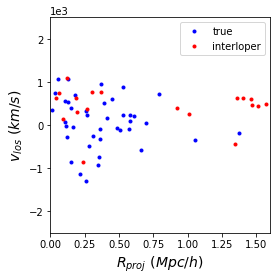

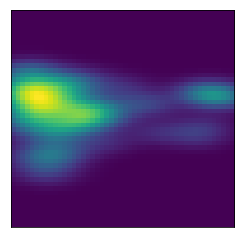

In [61]:



i = np.random.choice(np.argwhere(contam_cat.prop['M200c']>10**14).flatten())
# i = np.argwhere(dat_MD['hostid']==3339815782)[0][0]
# i = 47804

print('host id: ' + str(contam_cat.prop['rockstarId'][i]))
print('rotation: ' + str(contam_cat.prop['rotation'][i]))
print('log(M_200c): ' + str(np.log10(contam_cat.prop['M200c'][i])))

f = plt.figure(figsize=[4,4])

x = np.sqrt(contam_cat.gal[i]['xproj']**2 + contam_cat.gal[i]['yproj']**2)
y = contam_cat.gal[i]['vlos']

# ax2.plot(np.arange(0,6./5*rcut,rcut/5.),[0]*6, c='k', linestyle='dashed')

plt.plot(x[contam_cat.gal[i]['true_memb']==1],
         -y[contam_cat.gal[i]['true_memb']==1],
         '.', c='b',label='true')
plt.plot(x[contam_cat.gal[i]['true_memb']!=1],
         -y[contam_cat.gal[i]['true_memb']!=1],
         '.', c='r',label='interloper')

plt.legend()

plt.xlim(0,rcut)
plt.ylim(-vcut,vcut)

# plt.title('$\log(M_{200c}) = $ ' + str(np.log10(contam_cat.prop['M200c'][i]))[:6], 
#            y=1.03,fontsize=14)
plt.xlabel('$R_{proj}\ (Mpc/h)$', fontsize=14)
plt.ylabel('$v_{los}\ (km/s)$', fontsize=14)

plt.ticklabel_format(style='sci',axis='y', scilimits=(-1,1))

# plt.xlim(-vcut,vcut)
# plt.ylim(0,10**-3)

plt.tight_layout()

cat = contam_cat
bandwidth=0.35
par = {'shape':(48,48)}
mesh = np.mgrid[-cat.par['vcut'] : cat.par['vcut'] : par['shape'][0]*1j,
                0 : cat.par['aperture'] : par['shape'][1]*1j               
                ]
sample = np.vstack([mesh[0].ravel(), mesh[1].ravel()]) # Sample at fixed intervals. Used to sample pdfs
memb = np.ndarray(shape=(2,cat.prop.loc[i, 'Ngal']))
memb[0,:] = contam_cat.gal[i]['vlos']
memb[1,:] = contam_cat.gal[i]['Rproj']
kde = gaussian_kde(memb, bandwidth)

# sample kde at fixed intervals
kdeval = np.reshape(kde(sample).T, mesh[0].shape)

# normalize input
kdeval /= kdeval.sum()


# plot
plt.figure(figsize=(4,4))


plt.imshow(kdeval, aspect='auto',
           extent=[0, cat.par['aperture'], -cat.par['vcut'], cat.par['vcut']])

# plt.plot(memb[1], 
#          -memb[0],'k.',
#           alpha=0.75,label='interloper')
plt.xticks([])
plt.yticks([])
# plt.xlabel('$R_{proj}\ (Mpc/h)$', fontsize=14)
# plt.ylabel('$v_{los}\ (km/s)$', fontsize=14)

# plt.colorbar()

# f.savefig(os.path.join(img_savedir,'MD_cluster.pdf'))

# Folds

In [6]:
# pure_cat = Catalog().load(os.path.join(wdir,'data_mocks','Rockstar_UM_z=0.117_pure.p'))

contam_cat = Catalog().load(os.path.join(wdir,'data_mocks','Rockstar_UM_z=0.117_contam.p'))

Loading catalog from: /home/mho1/scratch/halo_cnn/data_mocks/Rockstar_UM_z=0.117_contam.p


In [8]:
hmf_M200c = np.loadtxt(os.path.join(wdir, 'data_raw', 'dn_dm_MDPL2_z=0.117_M200c.txt'))

x_hmf_M200c, y_hmf_M200c = hmf_M200c

y_hmf_M200c = x_hmf_M200c*y_hmf_M200c*np.log(10)
x_hmf_M200c = np.log10(x_hmf_M200c)

In [9]:
cat = contam_cat

In [20]:
Nfolds=10

m_bin=0.01


fold_ind = pd.Series(np.random.randint(0,Nfolds,len(cat.prop['rockstarId'].unique())), 
                  index = cat.prop['rockstarId'].unique())

fold = fold_ind[cat.prop['rockstarId']]

fold_assign = pd.DataFrame(np.zeros(shape=(len(cat),Nfolds)), 
                           index = cat.prop.index)


for i in range(Nfolds):
    print('fold:',i)
    
    fold_assign.loc[fold_assign.index[fold==i],i] = 2
    
    log_m = np.log10(cat.prop.loc[fold_assign.index[fold!=i],'M200c'])

    bin_edges = np.arange(log_m.min() * 0.9999, (log_m.max() + m_bin)*1.0001, m_bin)
    
    n_per_bin = int(len(log_m)/(10*len(bin_edges)))
    
    for j in range(len(bin_edges)):
        bin_ind = log_m.index[ (log_m >= bin_edges[j])&(log_m < bin_edges[j]+m_bin) ]
        
        if len(bin_ind) <= n_per_bin:
            fold_assign.loc[bin_ind,i] = 1
            
        else:
            fold_assign.loc[np.random.choice(bin_ind, n_per_bin), i] = 1


fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
fold: 5
fold: 6
fold: 7
fold: 8
fold: 9


len_train: 52203
len_test: 88951


(1e-08, 0.001)

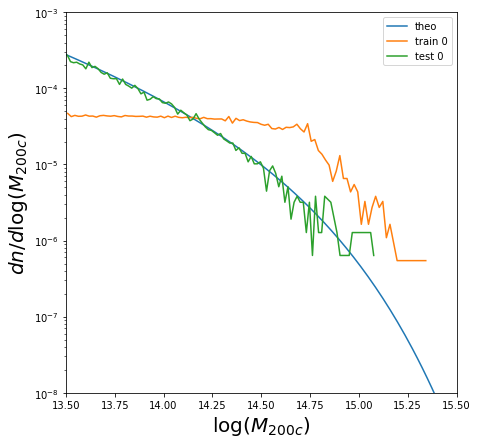

In [21]:
fold=np.random.randint(0,Nfolds)

print('len_train:',np.sum(fold_assign[fold]==1))
print('len_test:',np.sum(fold_assign[fold]==2))

f = plt.figure(figsize=(7,7))
ax = f.add_subplot(111)

ax.plot(x_hmf_M200c, y_hmf_M200c, label='theo')


matt.histplot(np.log10(cat.prop['M200c'][fold_assign[fold]==1]), 
              n=100, label='train ' + str(fold), log=1, box=True, ax=ax)
matt.histplot(np.log10(cat.prop['M200c'][fold_assign[fold]==2]), 
              n=100, label='test ' + str(fold), log=1, box=True, ax=ax)

ax.set_xlabel(r'$\log(M_{200c}$)', fontsize=20)
ax.set_ylabel(r'$dn/d\log(M_{200c})$', fontsize=20)
ax.legend()

ax.set_xlim(13.5,15.5)
ax.set_ylim(10**-8,10**-3)

In [11]:
log_m = np.log10(pure_cat.prop['M200c'])

log_m_min, log_m_max = log_m.min(), log_m.max()

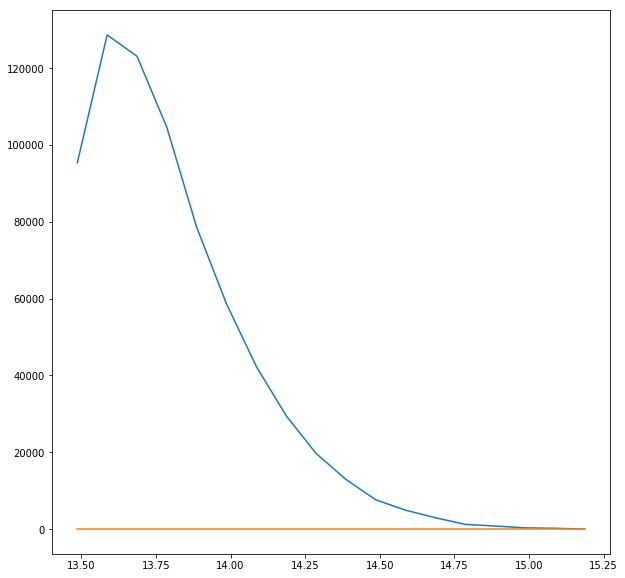

In [66]:
bin_edges = np.arange(log_m_min * 0.999, log_m_max*1.001, 0.1)

num_per_bin = 

len_intrvl = []
for i in range(len(intrvls)-1):
    log_m.index[(log_m>=intrvls[i]) & (log_m<intrvls[i+1])]
    
plt.plot(intrvls[:-1], len_intrvl)
plt.plot(intrvls[:-1], [0]*len(len_intrvl))

In [65]:
np.mean(len_intrvl)

7186.060606060606

In [34]:
i=100

mesh = np.mgrid[-pure_cat.par['vcut'] : pure_cat.par['vcut'] : 48*1j]

sample = np.vstack([mesh.ravel()]) # Velocities at fixed intervals. Used to sample velocity pdfs

# initialize a gaussian kde from galaxy velocities
kde = gaussian_kde(pure_cat.gal[i]['vlos'])

# sample kde at fixed intervals
kdeval = np.reshape(kde(sample).T, mesh.shape)

# normalize input
kdeval /= kdeval.sum()

In [39]:
np.array([kdeval]*100).shape

(100, 48)

# 2D PDF

In [24]:
cat = contam_cat

par = {'shape':(48,48)}

In [25]:
mesh = np.mgrid[-cat.par['vcut'] : cat.par['vcut'] : par['shape'][0]*1j,
                0 : cat.par['aperture'] : par['shape'][1]*1j               
                ]

sample = np.vstack([mesh[0].ravel(), mesh[1].ravel()]) # Sample at fixed intervals. Used to sample pdfs

In [28]:
def scott_bandwidth(N, d):
    return N**(-1./(d+4))
        
bandwidth = scott_bandwidth(cat.prop['Ngal'].mean(), len(par['shape']))
bandwidth=0.15
print('bandwidth:', bandwidth)

bandwidth: 0.15


# 16635


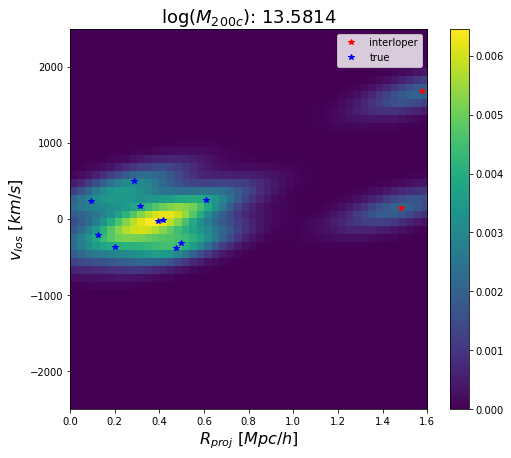

In [29]:

i = np.random.randint(len(cat))
bandwidth=0.35

print('#',i)

memb = np.ndarray(shape=(2,cat.prop.loc[i, 'Ngal']))
memb[0,:] = cat.gal[i]['vlos']
memb[1,:] = cat.gal[i]['Rproj']

# initialize a gaussian kde from galaxies
kde = gaussian_kde(memb, bandwidth)

# sample kde at fixed intervals
kdeval = np.reshape(kde(sample).T, mesh[0].shape)

# normalize input
kdeval /= kdeval.sum()


# plot
plt.figure(figsize=(8,7))


plt.imshow(kdeval, aspect='auto',
           extent=[0, cat.par['aperture'], -cat.par['vcut'], cat.par['vcut']])


plt.plot(memb[1][cat.gal[i]['true_memb']!=1], 
         -memb[0][cat.gal[i]['true_memb']!=1],
         'r*',label='interloper')
plt.plot(memb[1][cat.gal[i]['true_memb']==1], 
         -memb[0][cat.gal[i]['true_memb']==1],
         'b*',label='true')

plt.title('$\log(M_{200c})$: ' + str(np.log10(cat.prop.loc[i,'M200c']))[0:7], fontsize=18)
plt.xlabel('$R_{proj}\ [Mpc/h]$', fontsize=16)
plt.ylabel('$v_{los}\ [km/s]$', fontsize=16)
plt.legend()

plt.colorbar()

## Marginalized over theta

In [24]:
cat = contam_cat

par = {'shape':(48,48)}

mesh = np.mgrid[-cat.par['vcut'] : cat.par['vcut'] : par['shape'][0]*1j,
                0 : cat.par['aperture'] : par['shape'][1]*1j               
                ]

sample = np.vstack([mesh[0].ravel(), mesh[1].ravel()]) # Sample at fixed intervals. Used to sample pdfs

def scott_bandwidth(N, d):
    return N**(-1./(d+4))

Text(0.5,1.05,'$\\log(M_{200c})$: 14.0146')

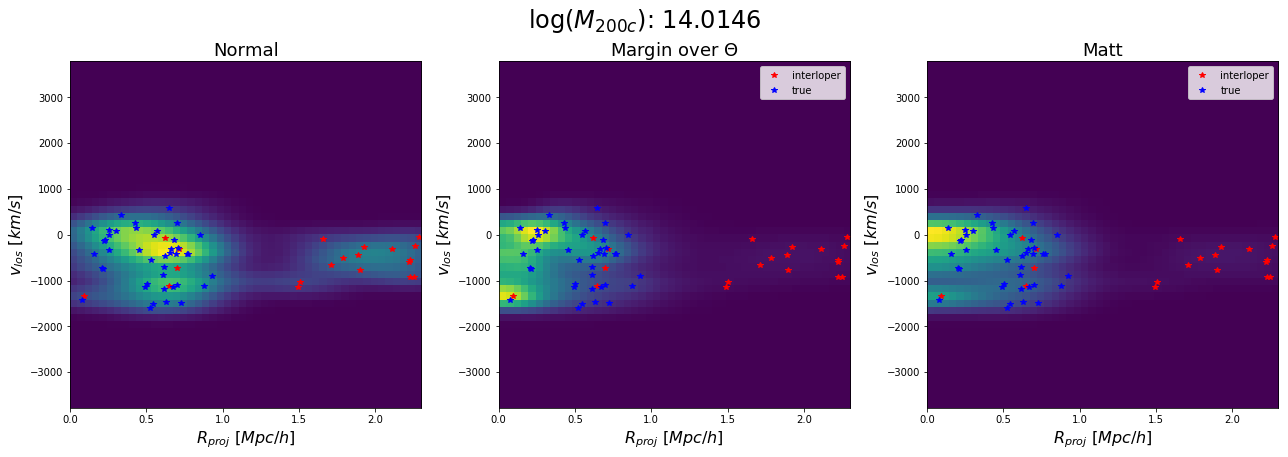

In [29]:
bandwidth=0.35

i = np.random.randint(len(cat))

f = plt.figure(figsize=[18,6])
gs = mpl.gridspec.GridSpec(1,3)


# ORIGINAL
#print('#',i)

memb = np.ndarray(shape=(2,cat.prop.loc[i, 'Ngal']))
memb[0,:] = cat.gal[i]['vlos']
memb[1,:] = cat.gal[i]['Rproj']

# initialize a gaussian kde from galaxies
kde = gaussian_kde(memb, bandwidth)

# sample kde at fixed intervals
kdeval = np.reshape(kde(sample).T, mesh[0].shape)

# normalize input
kdeval /= kdeval.sum()


# plot
ax1 = f.add_subplot(gs[0,0])


ax1.imshow(kdeval, aspect='auto',
           extent=[0, cat.par['aperture'], -cat.par['vcut'], cat.par['vcut']])


ax1.plot(cat.gal[i]['Rproj'][cat.gal[i]['true_memb']!=1], 
         -cat.gal[i]['vlos'][cat.gal[i]['true_memb']!=1],
         'r*',label='interloper')
ax1.plot(cat.gal[i]['Rproj'][cat.gal[i]['true_memb']==1], 
         -cat.gal[i]['vlos'][cat.gal[i]['true_memb']==1],
         'b*',label='true')

ax1.set_title('Normal', fontsize=18)
ax1.set_xlabel('$R_{proj}\ [Mpc/h]$', fontsize=16)
ax1.set_ylabel('$v_{los}\ [km/s]$', fontsize=16)
# plt.legend()

# plt.colorbar()




# MARGINALIZED OVER THETA
memb = np.ndarray(shape=(3,cat.prop.loc[i, 'Ngal']))

memb[0,:] = cat.gal[i]['vlos']
memb[1,:] = cat.gal[i]['xproj']
memb[2,:] = cat.gal[i]['yproj']

kde = gaussian_kde(memb, bandwidth)

def integrand(v,R,theta):
    return kde((v,R*np.cos(theta), R*np.sin(theta)))

def f_hat(v,R):
    return scipy.integrate.quad(lambda x: integrand(v,R,x), 0, 2*np.pi, epsrel=0.01)

f_hat_vec = np.vectorize(f_hat)

# x = np.array([f_hat(*x) for x in sample.T])[:,0]

kdeval = np.reshape(f_hat_vec(*sample)[0], mesh[0].shape)

# normalize input
kdeval /= kdeval.sum()


# plot
ax2 = f.add_subplot(gs[0,1])

ax2.imshow(kdeval, aspect='auto',
           extent=[0, cat.par['aperture'], -cat.par['vcut'], cat.par['vcut']])



ax2.plot(cat.gal[i]['Rproj'][cat.gal[i]['true_memb']!=1], 
         -cat.gal[i]['vlos'][cat.gal[i]['true_memb']!=1],
         'r*',label='interloper')
ax2.plot(cat.gal[i]['Rproj'][cat.gal[i]['true_memb']==1], 
         -cat.gal[i]['vlos'][cat.gal[i]['true_memb']==1],
         'b*',label='true')

ax2.set_title('Margin over $\Theta$', fontsize=18)
ax2.set_xlabel('$R_{proj}\ [Mpc/h]$', fontsize=16)
ax2.set_ylabel('$v_{los}\ [km/s]$', fontsize=16)
ax2.legend()

kdeval2 = kdeval

sig = np.sqrt(memb[1,:].std()*memb[2,:].std())
#sig = min(memb[1,:].std(), memb[2,:].std())
#MATT's
memb = np.ndarray(shape=(cat.prop.loc[i, 'Ngal'],2))

memb[:,0] = cat.gal[i]['vlos']
memb[:,1] = cat.gal[i]['Rproj']


def f_hat(v,R):
    h_v = bandwidth * memb[:,0].std()
    h_xy = bandwidth * sig#np.sqrt((memb[:,1]**2).sum()/len(memb))*0.9
    
    return 1/(len(memb)*h_v*h_xy**2*np.sqrt(2*np.pi))*(np.exp(-(v - memb[:,0])**2 / (2*h_v**2) - (R**2 + memb[:,1]**2)/(2*h_xy**2)) * scipy.special.iv(0, R*memb[:,1]/(h_xy**2) )).sum()

x = np.array([f_hat(*x) for x in sample.T])

kdeval = np.reshape(x, mesh[0].shape)

# normalize input
kdeval /= kdeval.sum()

ax3 = f.add_subplot(gs[0,2])

ax3.imshow(kdeval, aspect='auto',
           extent=[0, cat.par['aperture'], -cat.par['vcut'], cat.par['vcut']])


ax3.plot(cat.gal[i]['Rproj'][cat.gal[i]['true_memb']!=1], 
         -cat.gal[i]['vlos'][cat.gal[i]['true_memb']!=1],
         'r*',label='interloper')
ax3.plot(cat.gal[i]['Rproj'][cat.gal[i]['true_memb']==1], 
         -cat.gal[i]['vlos'][cat.gal[i]['true_memb']==1],
         'b*',label='true')

ax3.set_title('Matt', fontsize=18)
ax3.set_xlabel('$R_{proj}\ [Mpc/h]$', fontsize=16)
ax3.set_ylabel('$v_{los}\ [km/s]$', fontsize=16)
ax3.legend()

plt.tight_layout()
plt.suptitle('$\log(M_{200c})$: ' + str(np.log10(cat.prop.loc[i,'M200c']))[0:7], y=1.05,fontsize=24)


Text(0,0.5,'Integrand')

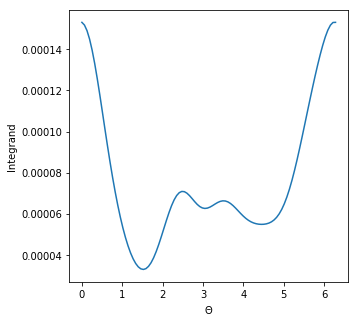

In [10]:
v = 1000
r = 0.5
t = np.linspace(0,2*np.pi,100)

plt.figure(figsize=(5,5))
plt.plot(t, [integrand(v,r,i) for i in t])
plt.xlabel('$\Theta$')
plt.ylabel('Integrand')

## Efficient

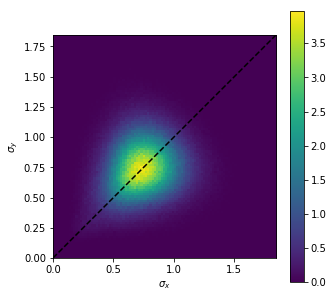

In [16]:
# Cylindrical symmetry

sig_x = [cat.gal[i]['xproj'].std() for i in range(len(cat))]
sig_y = [cat.gal[i]['yproj'].std() for i in range(len(cat))]

max_sig = max(max(sig_x),max(sig_y))

plt.figure(figsize=(5,5))
H, xedges, yedges = np.histogram2d(sig_y, sig_x, normed=True,
                                   bins = [np.linspace(0,max_sig, 101)]*2
                                  )
im = plt.imshow(H, origin='low',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.plot(xedges, xedges, c='k', linestyle='dashed')
plt.xlabel('$\sigma_x$')
plt.ylabel('$\sigma_y$')
plt.colorbar()

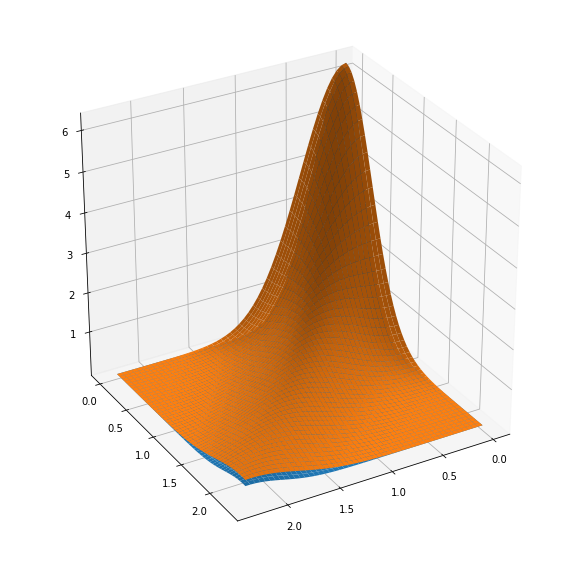

In [24]:
# WRONG

bandwidth=0.4

i = np.random.randint(len(cat))


memb = np.ndarray(shape=(3,cat.prop.loc[i, 'Ngal']))

memb[0,:] = cat.gal[i]['vlos']
memb[1,:] = cat.gal[i]['xproj']
memb[2,:] = cat.gal[i]['yproj']


h = bandwidth*memb[1:,:].std(axis=1)

def integrand(R, th, Ri):
    return np.exp(-1/2. * ((R *np.cos(th) - Ri)**2/(h[0]**2)+ (R*np.sin(th))**2/(h[1]**2)
                 ))

R = np.linspace(0,2.3,50)
Ri = np.linspace(0,2.3,50)
fun_map = np.empty((R.size, Ri.size))

for i in range(R.size):
    for j in range(Ri.size):
        fun_map[i,j] = scipy.integrate.quad(lambda x: integrand(R[i],x,Ri[j]), 0, 2*np.pi)[0]

fig = plt.figure()
ax = fig.gca(projection='3d')

X,Y = np.meshgrid(R,Ri)
Z = fun_map
surf = ax.plot_surface(X,Y,Z)


hxy = np.sqrt(h[0]**2 + h[1]**2)
def fun(R, Ri):
    return 2*np.pi*np.exp( (R**2+ Ri**2)/(-2*hxy**2) ) * scipy.special.iv(0, R*Ri/(hxy**2) )

fun_map = np.empty((R.size, Ri.size))

for i in range(R.size):
    for j in range(Ri.size):
        fun_map[i,j] = fun(R[i],Ri[j])
        
X,Y = np.meshgrid(R,Ri)
Z = fun_map
surf = ax.plot_surface(X,Y,Z)

ax.view_init(azim=60)

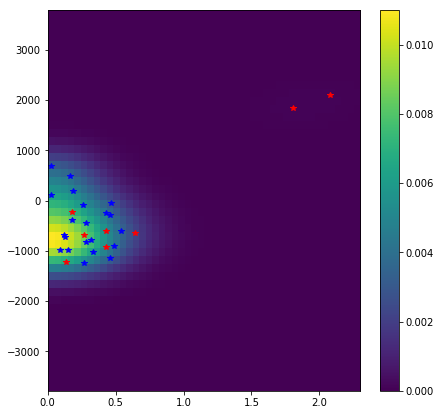

In [191]:
# Assumption under cylindrical symmetry

bwidth=0.35

i = np.random.randint(len(cat))
memb = np.ndarray(shape=(cat.prop.loc[i, 'Ngal'],2))

memb[:,0] = cat.gal[i]['vlos']
memb[:,1] = cat.gal[i]['Rproj']


def f_hat(v,R):
    h_v = bwidth * memb[:,0].std()
    h_xy = bwidth * np.sqrt((memb[:,1]**2).sum()/len(memb))
    
    return 1/(len(memb)*h_v*h_xy**2*np.sqrt(2*np.pi))*(np.exp(-(v - memb[:,0])**2 / (2*h_v**2) - (R**2 + memb[:,1]**2)/(2*h_xy**2)) * scipy.special.iv(0, R*memb[:,1]/(h_xy**2) )).sum()

x = np.array([f_hat(*x) for x in sample.T])

kdeval = np.reshape(x, mesh[0].shape)

# normalize input
kdeval /= kdeval.sum()

# plot
plt.figure(figsize=(7,7))

plt.imshow(kdeval, aspect='auto',
           extent=[0, cat.par['aperture'], -cat.par['vcut'], cat.par['vcut']])


plt.plot(cat.gal[i]['Rproj'][cat.gal[i]['true_memb']!=1], 
         -cat.gal[i]['vlos'][cat.gal[i]['true_memb']!=1],
         'r*',label='interloper')
plt.plot(cat.gal[i]['Rproj'][cat.gal[i]['true_memb']==1], 
         -cat.gal[i]['vlos'][cat.gal[i]['true_memb']==1],
         'b*',label='true')
plt.colorbar()
#plt.title('$\log(M_{200c})$: ' + str(np.log10(cat.prop.loc[i,'M200c']))[0:7], fontsize=18)


In [23]:

bwidth=0.4

i = np.random.randint(len(cat))
memb = np.ndarray(shape=(cat.prop.loc[i, 'Ngal'],2))

memb[:,0] = cat.gal[i]['vlos']
memb[:,1] = cat.gal[i]['Rproj']

R = 1
v = 100

h_v = bwidth * memb[:,0].std()
h_xy = bwidth * np.sqrt((memb[:,1]**2).sum()/len(memb))



array([1.10271323e-03, 1.09080085e-05, 7.64803418e-03, 6.37749414e-03,
       9.47041711e-03, 1.89065300e-03, 6.10136297e-05, 2.72311424e-03,
       2.62461361e-02, 3.96493922e-05, 1.41935221e-05, 1.13808479e-03,
       3.33268709e-03, 7.30962870e-02, 1.82988029e-03, 2.73236351e-02,
       1.66750200e-01, 6.91803269e-02, 1.70228653e-01, 3.55282919e-02,
       1.54863174e-02, 8.15355412e-02, 8.44581595e-02, 1.01712927e-01,
       1.15637173e-01, 8.84872736e-02, 3.63917709e-05, 1.23996984e-01,
       5.35440068e-02, 3.12669987e-20])

# Bandwidth

In [14]:
cat = contam_cat

par = {'shape':(48,48)}

In [15]:
mesh = np.mgrid[-cat.par['vcut'] : cat.par['vcut'] : par['shape'][0]*1j,
                0 : cat.par['aperture'] : par['shape'][1]*1j               
                ]

sample = np.vstack([mesh[0].ravel(), mesh[1].ravel()]) # Sample at fixed intervals. Used to sample pdfs

In [22]:
def scott_bandwidth(N, d):
    return N**(-1./(d+4))
        
bandwidth = scott_bandwidth(cat.prop['Ngal'].mean(), len(par['shape']))
bandwidth=0.15
print('bandwidth:', bandwidth)

bandwidth: 0.15


# 126127


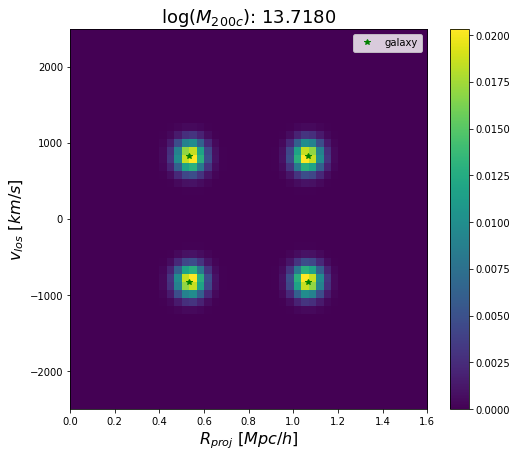

In [23]:

i = np.random.randint(len(cat))

print('#',i)
"""
memb = np.ndarray(shape=(2,cat.prop.loc[i, 'Ngal']))

memb[0,:] = cat.gal[i]['vlos']

memb[1,:] = cat.gal[i]['Rproj']"""

v = cat.par['vcut']/3
r1 = cat.par['aperture']/3
r2 = 2*cat.par['aperture']/3

memb = np.array([
    [-v, v,-v,v], # vlos
    [r1, r1, r2, r2]
])

# initialize a gaussian kde from galaxies
kde = gaussian_kde(memb, bandwidth)

# sample kde at fixed intervals
kdeval = np.reshape(kde(sample).T, mesh[0].shape)

# normalize input
kdeval /= kdeval.sum()

# plot
plt.figure(figsize=(8,7))


plt.imshow(kdeval, aspect='auto',
           extent=[0, cat.par['aperture'], -cat.par['vcut'], cat.par['vcut']])


plt.plot(memb[1], 
         -memb[0],
         'g*',label='galaxy')

plt.title('$\log(M_{200c})$: ' + str(np.log10(cat.prop.loc[i,'M200c']))[0:7], fontsize=18)
plt.xlabel('$R_{proj}\ [Mpc/h]$', fontsize=16)
plt.ylabel('$v_{los}\ [km/s]$', fontsize=16)
plt.legend()

plt.colorbar()

# 174735


"\nplt.title('$\\log(M_{200c})$: ' + str(np.log10(cat.prop.loc[i,'M200c']))[0:7], fontsize=18)\nplt.xlabel('$R_{proj}\\ [Mpc/h]$', fontsize=16)\nplt.ylabel('$v_{los}\\ [km/s]$', fontsize=16)\nplt.legend()\n\nplt.colorbar()\n"

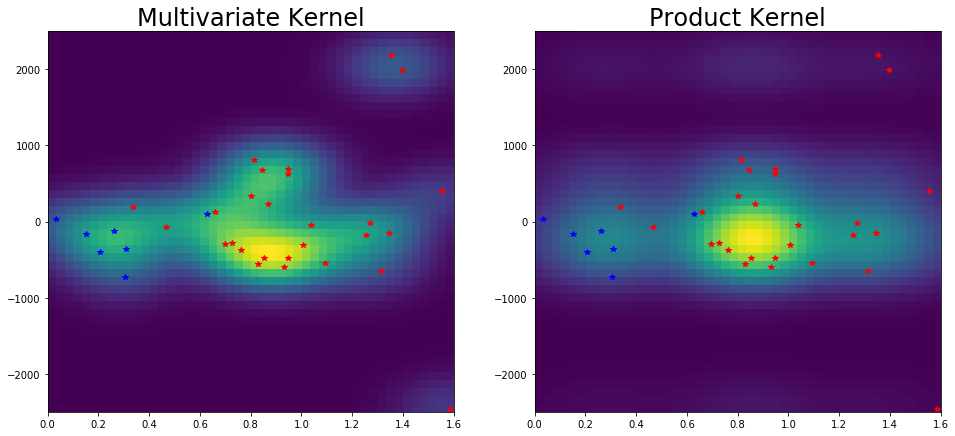

In [18]:

i = np.random.randint(len(cat))
bandwidth=0.35

print('#',i)

memb = np.ndarray(shape=(2,cat.prop.loc[i, 'Ngal']))

memb[0,:] = cat.gal[i]['vlos']

memb[1,:] = cat.gal[i]['Rproj']

# initialize a gaussian kde from galaxies
kde = gaussian_kde(memb, bandwidth)

# sample kde at fixed intervals
kdeval = np.reshape(kde(sample).T, mesh[0].shape)

# normalize input
kdeval /= kdeval.sum()


# plot
f, axs = plt.subplots(1,2,figsize=(16,7))


axs[0].imshow(kdeval, aspect='auto',
           extent=[0, cat.par['aperture'], -cat.par['vcut'], cat.par['vcut']])


axs[0].plot(memb[1][cat.gal[i]['true_memb']!=1], 
         -memb[0][cat.gal[i]['true_memb']!=1],
         'r*',label='interloper')
axs[0].plot(memb[1][cat.gal[i]['true_memb']==1], 
         -memb[0][cat.gal[i]['true_memb']==1],
         'b*',label='true')

axs[0].set_title('Multivariate Kernel', fontsize=24)

vs = np.linspace(-cat.par['vcut'],cat.par['vcut'], par['shape'][0])
rs = np.linspace(0, cat.par['aperture'], par['shape'][1])

kde0 = gaussian_kde(memb[0,:], bandwidth)
kde1 = gaussian_kde(memb[1,:], bandwidth)

samp_v = kde0(vs)
samp_r = kde1(rs)

kdeval = np.array([[i*j for j in samp_r] for i in samp_v])

kdeval /= kdeval.sum()

axs[1].imshow(kdeval, aspect='auto',
           extent=[0, cat.par['aperture'], -cat.par['vcut'], cat.par['vcut']])

axs[1].plot(memb[1][cat.gal[i]['true_memb']!=1], 
         -memb[0][cat.gal[i]['true_memb']!=1],
         'r*',label='interloper')
axs[1].plot(memb[1][cat.gal[i]['true_memb']==1], 
         -memb[0][cat.gal[i]['true_memb']==1],
         'b*',label='true')

axs[1].set_title('Product Kernel', fontsize=24)
"""
plt.title('$\log(M_{200c})$: ' + str(np.log10(cat.prop.loc[i,'M200c']))[0:7], fontsize=18)
plt.xlabel('$R_{proj}\ [Mpc/h]$', fontsize=16)
plt.ylabel('$v_{los}\ [km/s]$', fontsize=16)
plt.legend()

plt.colorbar()
"""

s_avg: 0.5102770006083915
n_avg: 0.4827798443072665


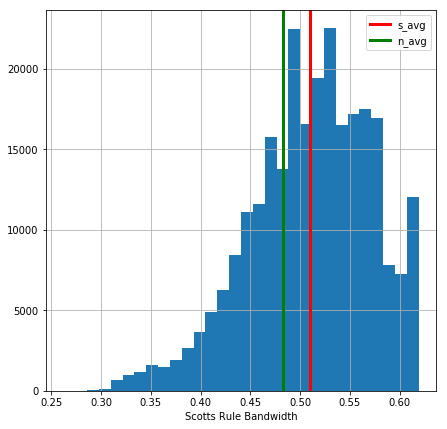

In [21]:
d = 1

scotts = cat.prop['Ngal']**(-1./(d+4))

s_avg = scotts.mean()
n_avg = cat.prop['Ngal'].mean()**(-1./(d+4.))

print('s_avg:', s_avg)
print('n_avg:', n_avg)

plt.figure(figsize=(7,7))
scotts.hist(bins=30)
plt.axvline(x=s_avg, label='s_avg', c='r', linewidth=3)
plt.axvline(x=n_avg, label='n_avg', c='g', linewidth=3)

plt.xlabel('Scotts Rule Bandwidth')

plt.legend()

# 3D

## Cylindrical

In [12]:
cat = contam_cat

par = {'shape':(48,12,48)}

In [13]:
mesh = np.mgrid[-cat.par['vcut'] : cat.par['vcut'] : par['shape'][0]*1j,
                0 : cat.par['aperture'] : par['shape'][1]*1j,
                0 : 2*np.pi : par['shape'][2]*1j
                ]

sample = np.vstack([mesh[0].ravel(), mesh[1].ravel(), mesh[2].ravel()]) # Sample at fixed intervals. Used to sample pdfs


p_mesh = np.mgrid[0 : cat.par['aperture'] : par['shape'][1]*1j,
                0 : 2*np.pi : par['shape'][2]*1j]

In [14]:
def scott_bandwidth(N, d):
    return N**(-1./(d+4))
        
bandwidth = scott_bandwidth(cat.prop['Ngal'].mean(), len(par['shape']))

print('bandwidth:', bandwidth)

bandwidth: 0.5752350920759229


# 1127236


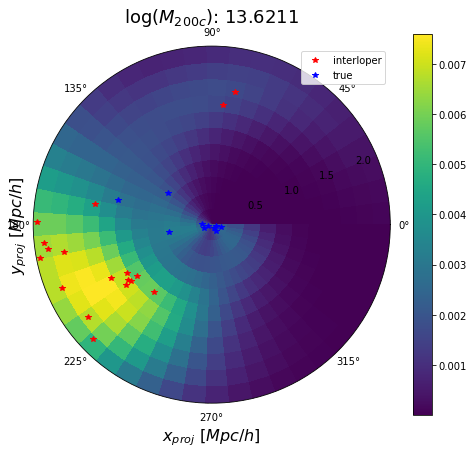

In [15]:
i = np.random.randint(len(cat))
print('#',i)

memb = np.ndarray(shape=(3,cat.prop.loc[i, 'Ngal']))

memb[0,:] = cat.gal[i]['vlos']

memb[1,:] = cat.gal[i]['Rproj']

memb[2,:] = np.arctan2(cat.gal[i]['yproj'],cat.gal[i]['xproj']) + np.pi

# initialize a gaussian kde from galaxies
kde = gaussian_kde(memb, bandwidth)

# sample kde at fixed intervals
kdeval = np.reshape(kde(sample).T, mesh[0].shape)

# normalize input
kdeval /= kdeval.sum()

plt.figure(figsize=(8,7))

plt.subplot(projection="polar")
plt.pcolormesh(p_mesh[1],p_mesh[0],np.sum(kdeval, axis=0))

plt.colorbar()

plt.plot(memb[2][cat.gal[i]['true_memb']!=1], 
         memb[1][cat.gal[i]['true_memb']!=1],
         'r*',label='interloper')
plt.plot(memb[2][cat.gal[i]['true_memb']==1], 
         memb[1][cat.gal[i]['true_memb']==1],
         'b*',label='true')

plt.title('$\log(M_{200c})$: ' + str(np.log10(cat.prop.loc[i,'M200c']))[0:7], fontsize=18)
plt.xlabel('$x_{proj}\ [Mpc/h]$', fontsize=16)
plt.ylabel('$y_{proj}\ [Mpc/h]$', fontsize=16)

plt.legend()

In [16]:
def vonmises_kde(data, kappa, n_bins=100):
    from scipy.special import i0
    bins = np.linspace(-np.pi, np.pi, n_bins)
    x = np.linspace(-np.pi, np.pi, n_bins)
    # integrate vonmises kernels
    kde = np.exp(kappa*np.cos(x[:, None]-data[None, :])).sum(1)/(2*np.pi*i0(kappa))
    kde /= np.trapz(kde, x=bins)
    return bins, kde


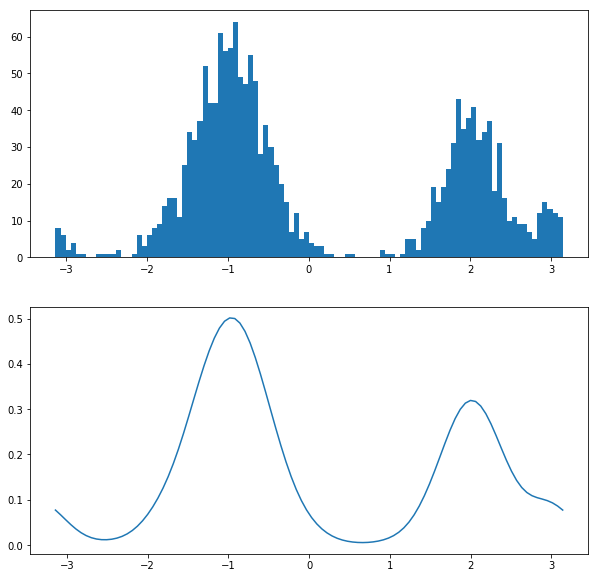

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import vonmises

# generate complex circular distribution
data = np.r_[vonmises(-1, 5, 1000), vonmises(2, 10, 500), vonmises(3, 20, 100)]

# plot data histogram
fig, axes = plt.subplots(2, 1)
axes[0].hist(data, 100)

# plot kernel density estimates
x, kde = vonmises_kde(data, 20)
axes[1].plot(x, kde)

In [129]:
# https://stackoverflow.com/questions/28839246/scipy-gaussian-kde-and-circular-data

## Cartesian

In [11]:
cat = contam_cat

par = {'shape':(48,12,12)}

In [7]:
mesh = np.mgrid[-cat.par['vcut'] : cat.par['vcut'] : par['shape'][0]*1j,
                -cat.par['aperture'] : cat.par['aperture'] : par['shape'][1]*1j,
                -cat.par['aperture'] : cat.par['aperture'] : par['shape'][2]*1j
                ]

sample = np.vstack([mesh[0].ravel(), mesh[1].ravel(), mesh[2].ravel()]) # Sample at fixed intervals. Used to sample pdfs

In [8]:
def scott_bandwidth(N, d):
    return N**(-1./(d+4))
        
bandwidth = scott_bandwidth(cat.prop['Ngal'].mean(), len(par['shape']))

print('bandwidth:', bandwidth)

bandwidth: 0.5752350920759229


# 780312


Text(0.5,0.92,'$\\log(M_{200c})$: 13.8856')

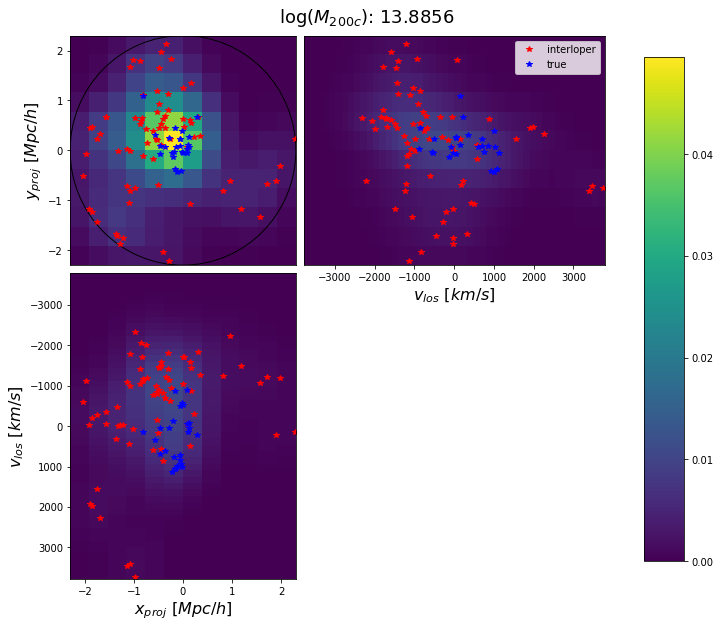

In [9]:
i = np.random.randint(len(cat))
print('#',i)

memb = np.ndarray(shape=(3,cat.prop.loc[i, 'Ngal']))

memb[0,:] = cat.gal[i]['vlos']

memb[1,:] = cat.gal[i]['xproj']

memb[2,:] = cat.gal[i]['yproj']

# initialize a gaussian kde from galaxies
kde = gaussian_kde(memb)

# sample kde at fixed intervals
kdeval = np.reshape(kde(sample).T, mesh[0].shape)

# normalize input
kdeval /= kdeval.sum()

kdeval0 = np.sum(kdeval, axis=0)
kdeval1 = np.sum(kdeval, axis=1)
kdeval2 = np.sum(kdeval, axis=2)

vmax = max(kdeval0.max(),kdeval1.max(),kdeval2.max())
vmin = min(kdeval0.min(),kdeval1.min(),kdeval2.min())



f = plt.figure(figsize=[11,10])
gs = mpl.gridspec.GridSpec(2,2, 
                           width_ratios=[1.5,2],
                           height_ratios=[1.5,2],
                           wspace=0.03,
                           hspace=0.03
                          )


ax1 = f.add_subplot(gs[0,0])

im = ax1.imshow(np.rot90(kdeval0), aspect='auto',
           extent=[-cat.par['aperture'], cat.par['aperture'], 
                   -cat.par['aperture'],  cat.par['aperture']],
           vmin=vmin, vmax=vmax
          )
ax1.plot(memb[1][cat.gal[i]['true_memb']!=1], 
         memb[2][cat.gal[i]['true_memb']!=1],
         'r*',label='interloper')
ax1.plot(memb[1][cat.gal[i]['true_memb']==1], 
         memb[2][cat.gal[i]['true_memb']==1],
         'b*',label='true')

circle = plt.Circle((0, 0), radius = cat.par['aperture'], edgecolor='k', facecolor='none')
ax1.add_artist(circle)
ax1.set_xticks([])

ax1.set_ylabel('$y_{proj}\ [Mpc/h]$', fontsize=16)

ax2 = f.add_subplot(gs[0,1])
ax2.imshow(np.rot90(kdeval1), aspect='auto',
           extent=[-cat.par['vcut'], cat.par['vcut'], 
                   -cat.par['aperture'],  cat.par['aperture']],
           vmin=vmin, vmax=vmax
          )

ax2.plot(memb[0][cat.gal[i]['true_memb']!=1], 
         memb[2][cat.gal[i]['true_memb']!=1],
         'r*',label='interloper')
ax2.plot(memb[0][cat.gal[i]['true_memb']==1], 
         memb[2][cat.gal[i]['true_memb']==1],
         'b*',label='true')
ax2.set_yticks([])


ax2.set_xlabel('$v_{los}\ [km/s]$', fontsize=16)
ax2.legend()



ax3 = f.add_subplot(gs[1,0])
ax3.imshow(kdeval2, aspect='auto',
           extent=[-cat.par['aperture'],  cat.par['aperture'],
                   cat.par['vcut'], -cat.par['vcut']],
           vmin=vmin, vmax=vmax
          )

ax3.plot(memb[1][cat.gal[i]['true_memb']!=1], 
         memb[0][cat.gal[i]['true_memb']!=1],
         'r*',label='interloper')
ax3.plot(memb[1][cat.gal[i]['true_memb']==1], 
         memb[0][cat.gal[i]['true_memb']==1],
         'b*',label='true')


ax3.set_ylabel('$v_{los}\ [km/s]$', fontsize=16)
ax3.set_xlabel('$x_{proj}\ [Mpc/h]$', fontsize=16)


f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
f.colorbar(im, cax=cbar_ax)


plt.suptitle('$\log(M_{200c})$: ' + str(np.log10(cat.prop.loc[i,'M200c']))[0:7], 
             fontsize=18, y=0.92
            )

# plt.colorbar()

## Cartesian KDE, Cylindrical sampling

In [56]:
cat = contam_cat

par = {'shape':(48,24,10)}

In [97]:

mesh_cyl = np.mgrid[-cat.par['vcut'] : cat.par['vcut'] : par['shape'][0]*1j,
                cat.par['aperture']/(2*par['shape'][1]): cat.par['aperture'] * (1+1./(2*par['shape'][1])): par['shape'][1]*1j,
                np.pi/par['shape'][2] : 2*np.pi * (1 - 1./(2*par['shape'][2])) : par['shape'][2]*1j
                ]

sample_cyl = np.vstack([mesh_cyl[0].ravel(), mesh_cyl[1].ravel(), mesh_cyl[2].ravel()]) # Sample at fixed intervals. Used to sample pdfs


sample_cart = np.ndarray(shape=sample_cyl.shape)

sample_cart[0,:] = sample_cyl[0,:]
sample_cart[1,:] = sample_cyl[1,:] * np.cos(sample_cyl[2,:])
sample_cart[2,:] = sample_cyl[1,:] * np.sin(sample_cyl[2,:])


mesh_pol = np.mgrid[0 : cat.par['aperture']*(1 + 1./(par['shape'][2])) : (par['shape'][1]+1)*1j,
                    0 : 2*np.pi : (par['shape'][2]+1)*1j
                   ]

mesh_2d = np.mgrid[0 : cat.par['aperture']*(1 + 1./(par['shape'][2])) : (par['shape'][1]+1)*1j,
                   -cat.par['vcut']*(1+1/(2*par['shape'][0])) : cat.par['vcut']*(1+1/(2*par['shape'][0])) : (par['shape'][0]+1)*1j
                  ]

In [98]:
def scott_bandwidth(N, d):
    return N**(-1./(d+4))
        
bandwidth = scott_bandwidth(cat.prop['Ngal'].mean(), len(par['shape']))

print('bandwidth:', bandwidth)

bandwidth: 0.5752350920759229


# 64861


/home/mho1/.conda/envs/jupy/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


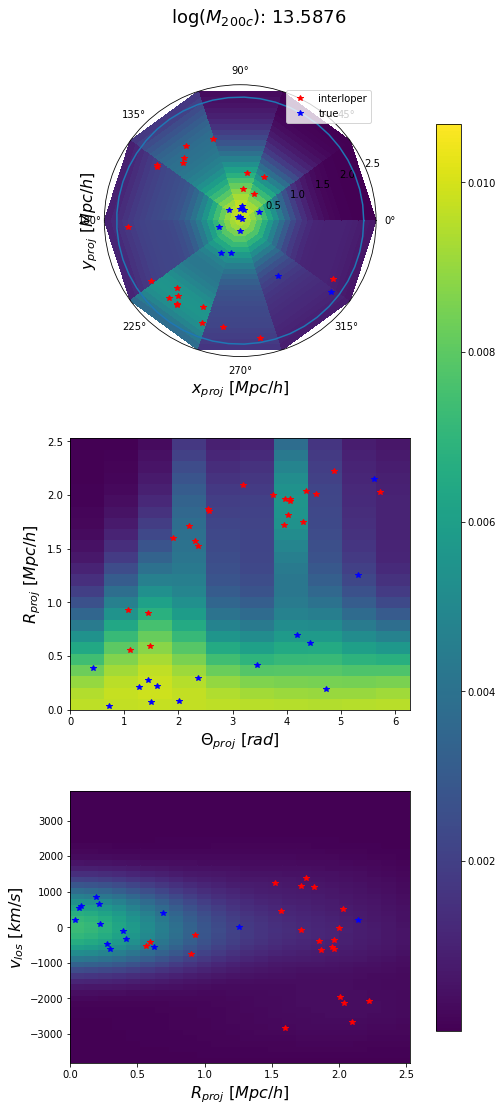

In [116]:
i = np.random.randint(len(cat))
print('#',i)

memb = np.ndarray(shape=(3,cat.prop.loc[i, 'Ngal']))
memb[0,:] = cat.gal[i]['vlos']
memb[1,:] = cat.gal[i]['xproj']
memb[2,:] = cat.gal[i]['yproj']

memb_pol = np.ndarray(shape=memb.shape)
memb_pol[0,:] = cat.gal[i]['vlos']
memb_pol[1,:] = cat.gal[i]['Rproj']
memb_pol[2,:] = np.arctan2(cat.gal[i]['yproj'], cat.gal[i]['xproj'])

memb_pol[2,:] = [i + 2*np.pi if i<0 else i for i in memb_pol[2,:]]

# initialize a gaussian kde from galaxies
kde = gaussian_kde(memb, bandwidth)

# sample kde at fixed intervals
kdeval = np.reshape(kde(sample_cart).T, mesh_cyl[0].shape)

# normalize input
kdeval /= kdeval.sum()

kdeval0 = np.sum(kdeval, axis=0)
kdeval2 = np.sum(kdeval, axis=2)

vmax = max(kdeval0.max(),kdeval1.max(),kdeval2.max())
vmin = min(kdeval0.min(),kdeval1.min(),kdeval2.min())



f = plt.figure(figsize=[7,18])

gs = mpl.gridspec.GridSpec(3,1,
                           hspace=0.3
                          )
ax1 = f.add_subplot(gs[0,0], projection="polar")

im = ax1.pcolormesh(mesh_pol[1], mesh_pol[0], kdeval0, vmin=vmin, vmax=vmax)

ax1.plot(memb_pol[2][cat.gal[i]['true_memb']!=1], 
         memb_pol[1][cat.gal[i]['true_memb']!=1],
         'r*',label='interloper')
ax1.plot(memb_pol[2][cat.gal[i]['true_memb']==1], 
         memb_pol[1][cat.gal[i]['true_memb']==1],
         'b*',label='true')

ax1.plot(np.linspace(0,2*np.pi,50), [cat.par['aperture']]*50)

ax1.set_xlabel('$x_{proj}\ [Mpc/h]$', fontsize=16)
ax1.set_ylabel('$y_{proj}\ [Mpc/h]$', fontsize=16)

ax1.legend()


ax2 = f.add_subplot(gs[1,0])
ax2.pcolormesh(mesh_pol[1], mesh_pol[0], kdeval0, vmin=vmin, vmax=vmax)
ax2.plot(memb_pol[2][cat.gal[i]['true_memb']!=1], 
         memb_pol[1][cat.gal[i]['true_memb']!=1],
         'r*',label='interloper')
ax2.plot(memb_pol[2][cat.gal[i]['true_memb']==1], 
         memb_pol[1][cat.gal[i]['true_memb']==1],
         'b*',label='true')

ax2.set_xlabel('$\Theta_{proj}\ [rad]$', fontsize=16)
ax2.set_ylabel('$R_{proj}\ [Mpc/h]$', fontsize=16)


ax3 = f.add_subplot(gs[2,0])
ax3.pcolormesh(mesh_2d[0], mesh_2d[1], kdeval2.T, vmin=vmin, vmax=vmax)
ax3.plot(memb_pol[1][cat.gal[i]['true_memb']!=1], 
         memb_pol[0][cat.gal[i]['true_memb']!=1],
         'r*',label='interloper')
ax3.plot(memb_pol[1][cat.gal[i]['true_memb']==1], 
         memb_pol[0][cat.gal[i]['true_memb']==1],
         'b*',label='true')

ax3.set_xlabel('$R_{proj}\ [Mpc/h]$', fontsize=16)
ax3.set_ylabel('$v_{los}\ [km/s]$', fontsize=16)


f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
f.colorbar(im, cax=cbar_ax)

plt.suptitle('$\log(M_{200c})$: ' + str(np.log10(cat.prop.loc[i,'M200c']))[0:7], 
             fontsize=18, y=0.94
            )

plt.tight_layout()

In [140]:
fold_ind = pd.Series(np.random.randint(0, 10, len(cat.prop['rockstarId'].unique())), 
                  index = cat.prop['rockstarId'].unique())

fold = fold_ind[cat.prop['rockstarId']]

fold_assign = np.zeros(shape=(len(cat),10))

i = 7
fold_assign[((fold==i).values & (cat.prop['rotation'] < 3).values), i] = 2

In [144]:
fold_assign[:,7][:100]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [139]:
((fold==i).values & (cat.prop['rotation'] < 3).values)

(1174004,)

In [137]:
(cat.prop['rotation'] < 3).shape

(1174004,)

In [9]:
dat_mich['redshift']

array([0.117, 0.117, 0.117, ..., 0.117, 0.117, 0.117], dtype=float32)

# Scratch

In [5]:
from scipy.spatial import KDTree

In [13]:
a = np.random.rand(100000,2)
tr = KDTree(a)

b = np.random.rand(10000,2)

t0 = time.time()
tr.query_ball_point(b,0.001)
print(time.time()-t0)

t0 = time.time()
for i in b:
    tr.query_ball_point(i,0.001)
print(time.time()-t0)

7.396697521209717
7.379993200302124


In [19]:
pd.DataFrame(np.concatenate((dat_UM[['x','y','z']].values,dat_UM[['vx','vy','vz']].values),axis=1), 
             columns=['x','y','z','vx','vy','vz'])

,x,y,z,vx,vy,vz
0,3.405850,16.637180,91.849060,-208.309998,-186.809998,242.970001
1,3.719573,16.531027,92.051743,-694.937622,-634.987976,-123.497276
2,3.808963,17.124643,91.304192,-75.626617,-400.379150,554.288635
3,3.390229,16.690458,91.908661,-655.760315,-340.822113,266.760132
4,3.959978,16.360865,91.266914,-223.851639,-93.881302,522.229614
5,3.700108,16.225718,91.832970,-658.988281,-31.404678,151.654938
6,3.471246,16.180105,91.995720,-532.088745,-598.383484,284.099426
7,2.977862,16.408745,91.987038,-236.450409,79.963394,924.542480
8,3.137563,16.505594,91.956978,-196.435181,-270.985626,-21.743271
9,4.140018,16.731819,92.002434,-575.110413,-390.126129,293.410706


In [12]:
dat_UM.loc[[104,859,23339,102],['x','y','z','vx','vy','vz']]

,x,y,z,vx,vy,vz
104,28.421852,22.260361,39.841347,162.094528,-112.588799,-336.567200
859,29.177971,1.722010,63.524429,-212.919998,-339.350006,-154.149994
23339,30.564091,18.258699,594.862610,202.770004,87.959999,-261.619995
102,25.718100,7.326380,75.269997,-282.214355,-373.578308,449.006287


In [7]:
contam_cat.prop.head()

,rockstarId,Mvir,Rvir,Rs,Macc,Vacc,M500c,M200c,x,y,z,vx,vy,vz,rotation,Ngal,sigv
0,1.143990e+10,3.615400e+13,716.776,106.382,3.615400e+13,567.80,2.308700e+13,3.162300e+13,541.600,299.117,447.561,-673.61,-167.77,323.47,0.0,45,1838.110863
1,1.139574e+10,3.700600e+13,722.363,117.488,3.700600e+13,562.12,2.227700e+13,3.162300e+13,243.567,401.093,668.025,-60.57,-178.27,-15.47,0.0,24,822.121548
2,1.142019e+10,3.861200e+13,732.667,123.559,3.861200e+13,569.19,2.279900e+13,3.162300e+13,467.146,106.532,622.951,218.82,-168.63,-165.70,0.0,29,1348.932538
3,1.137580e+10,3.550500e+13,712.462,109.168,3.550500e+13,560.05,2.204700e+13,3.162300e+13,118.610,194.371,591.888,455.41,45.59,-519.61,0.0,84,900.024745
4,1.142689e+10,3.882800e+13,734.026,116.536,3.882800e+13,575.27,2.314900e+13,3.162300e+13,417.779,866.134,408.386,-107.06,-414.95,99.61,0.0,31,900.316451


In [12]:
contam_cat.prop.loc[[1,2,3],['x','y','z']] - contam_cat.prop.loc[10,['x','y','z']]

,x,y,z
1,-90.912,51.292,105.986
2,132.667,-243.269,60.912
3,-215.869,-155.430,29.849


In [12]:
for i in range(len(cat)):
    if i%int(len(cat)/10)==0: print(i/int(len(cat)/10))
    for f in cat.gal[0].dtype.names:
        out[i]['gal_'+f][:int(out[i]['Ngal'])] = cat.gal[i][f]

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0


In [1]:
out[0]

NameError: name 'out' is not defined

In [52]:
gal_fields = 

In [16]:
out[0][gal_fields[0]].shape

(808,)

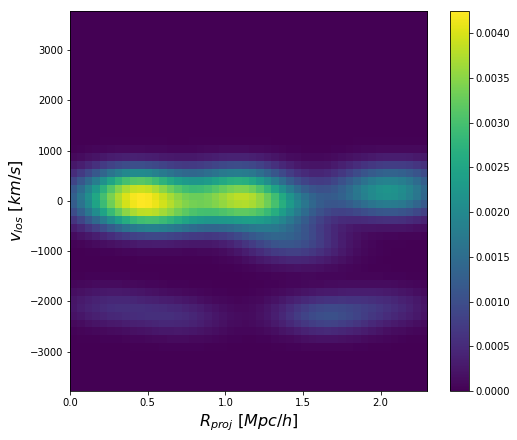

In [200]:
kdeval = dat['pdf'][np.random.randint(len(dat['pdf']))]

plt.figure(figsize=(8,7))


plt.imshow(kdeval, aspect='auto',
           extent=[0, cat.par['aperture'], -cat.par['vcut'], cat.par['vcut']])

plt.xlabel('$R_{proj}\ [Mpc/h]$', fontsize=16)
plt.ylabel('$v_{los}\ [km/s]$', fontsize=16)

plt.colorbar()

In [26]:
dict_rich['pdfs'].shape

(2, 500, 48, 48)

(25,)

In [40]:
meta_dtype = [('log_mass', '<f4',(10,10,10)), ('Ngal','<i8'), ('fold','<i4'), ('true_frac','<f4')]

x = np.ndarray(shape=(1,), dtype=meta_dtype)
y = np.ndarray(shape=(5,), dtype=meta_dtype)

x['log_mass'][0][3]

array([[ 2.0753915e-35,  3.0832770e-41,  2.0754053e-35,  3.0832770e-41,
         3.9236357e-44,  1.5426895e-41,  9.6106179e+26,  1.5425493e-41,
         1.4012985e-45,  1.5426895e-41],
       [ 2.4434635e-24,  1.5426895e-41,  4.2038954e-45,  2.1019477e-44,
         1.4012985e-45,  0.0000000e+00,  2.0753800e-35,  3.0832770e-41,
         2.3822074e-44,  1.5426895e-41],
       [ 1.4707024e-36,  3.0831369e-41,  2.4435393e-24,  1.5426895e-41,
         2.4435519e-24,  1.5426895e-41,  4.2038954e-45,  3.0828566e-44,
         4.2038954e-44,  1.5426895e-41],
       [ 2.0753778e-35,  3.0832770e-41,  1.4012985e-45,  1.5426895e-41,
         6.9278042e-23,  1.5426895e-41,  4.2038954e-45,  3.0828566e-44,
         9.6106179e+26,  1.5425493e-41],
       [ 2.0753858e-35,  3.0832770e-41,  3.9236357e-44,  1.5426895e-41,
         7.1489156e+33,  1.5425493e-41,  1.4012985e-45,  1.5426895e-41,
         6.9280870e-23,  1.5426895e-41],
       [ 4.2038954e-45,  3.7835059e-44,  3.9236357e-44,  1.5426895e-41,
   

In [16]:
main_dtype = [('pdfs','<f8', (10, 10, 10 ) ), ('richs', '<i8', 10)]
main_data = np.ndarray(shape=(5,), dtype=main_dtype)

In [22]:
main_data.view('<f8')

array([2.35151554e-310, 2.35151554e-310, 4.67790754e-310, ...,
       8.23005808e-067, 3.22115469e-057, 1.68899161e-052])

In [12]:
import math, random

def fibonacci_sphere(samples=1,randomize=True):
    rnd = 1.
    if randomize:
        rnd = random.random() * samples

    points = []
    offset = 2./samples
    increment = math.pi * (3. - math.sqrt(5.));

    for i in range(samples):
        y = ((i * offset) - 1) + (offset / 2);
        r = math.sqrt(1 - pow(y,2))

        phi = ((i + rnd) % samples) * increment

        x = math.cos(phi) * r
        z = math.sin(phi) * r

        points.append([x,y,z])

    return points


In [67]:
def fibonacci_sphere(N=1, randomize=True):
    # Generate a set of N angles, (theta, phi), 'evenly' distributed on the unit sphere. In truth, it is Fibonacci sphere distributed. See https://stackoverflow.com/questions/9600801/evenly-distributing-n-points-on-a-sphere
    
    rnd = np.random.rand() * N if randomize else 1.
        
    points = []
    
    dz = 2./N
    dphi = np.pi*(3. - np.sqrt(5)) # Golden angle
    
    for i in range(N):
        z = ((i*dz) - 1) + (dz/2.)
        
        theta = np.arccos(z)
        phi = ((i + rnd) % N) * dphi
        
        points.append((theta, phi))
        
    return points

In [84]:
ang = np.array(fibonacci_sphere(100, False))

x = np.cos(ang[:,1])*np.sin(ang[:,0])
y = np.sin(ang[:,1])*np.sin(ang[:,0])
z = np.cos(ang[:,0])

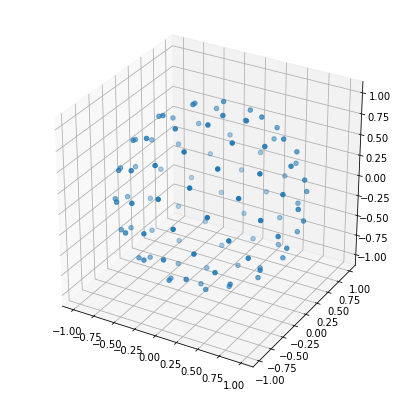

In [85]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x,y,z,'.')

In [95]:
fibonacci_sphere(100, True)

[(3.000053180265366, 178.1740628219015),
 (2.896027136074501, 180.57402605163014),
 (2.824032224298272, 182.9739892813588),
 (2.765209171272065, 185.37395251108745),
 (2.714080388644924, 187.7739157408161),
 (2.6681414963177272, 190.17387897054476),
 (2.6259986473437027, 192.57384220027342),
 (2.5867816206097216, 194.97380543000207),
 (2.549904011163249, 197.37376865973073),
 (2.514948441949053, 199.77373188945938),
 (2.481605324202295, 202.173695119188),
 (2.4496374784634765, 204.57365834891667),
 (2.4188584057763776, 206.97362157864532),
 (2.3891182774264563, 209.37358480837398),
 (2.3602945361410685, 211.77354803810263),
 (2.3322853795425296, 214.1735112678313),
 (2.3050051142482553, 216.57347449755994),
 (2.278380763520252, 218.9734377272886),
 (2.2523495383580134, 221.37340095701725),
 (2.2268569177198194, 223.7733641867459),
 (2.201855167572918, 226.17332741647456),
 (2.1773021820079834, 228.57329064620322),
 (2.15316056466364, 230.97325387593185),
 (2.1293968921376973, 233.37321

In [7]:
dat_mich = np.load(os.path.join(wdir,'data_mocks','Rockstar_UM_z=0.117_contam_rot10_mich.npy'))
print(sys.getsizeof(dat_mich)/10.**9, ' GB')
print(dat_mich.dtype.names)

5.798674924  GB
('Mtot', 'hostid', 'rotation', 'fold', 'Ngal', 'vlos', 'sigmav', 'Rproj', 'xyproj', 'truememb', 'intest', 'intrain', 'redshift', 'Rs')


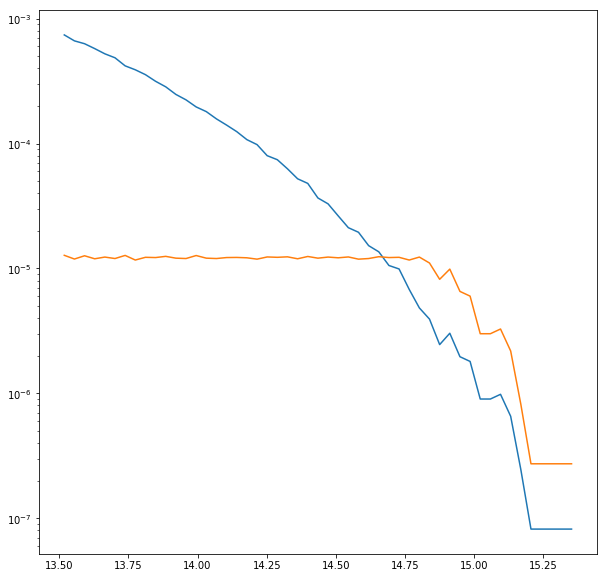

In [16]:
f,ax = plt.subplots()

_ = matt.histplot(np.log10(dat_mich['Mtot'][dat_mich['intest']==1]), 
                  log=1, n=50, box=True, label='test', ax=ax)

_ = matt.histplot(np.log10(dat_mich['Mtot'][dat_mich['intrain']==1]), 
                  log=1, n=50, box=True, label='train', ax=ax)

In [24]:
dat_mich[0][['vlos','Rproj']][0]

array([4., 5., 6., ..., 0., 0., 0.], dtype=float32)

In [25]:
i = np.random.randint(len(pure_cat))

dat_mich['vlos'][i][0:pure_cat.prop.loc[i,'Ngal']] = pure_cat.gal[i]['vlos']

In [45]:
len(dat_mich[(dat_mich['intrain'] + dat_mich['intest']) > 0])

213426

In [41]:
dat_mich['intest']

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

In [28]:
np.log10(pure_cat.prop.head(1000).loc[np.random.randint(0,10,1000)>=5,'M200c'])

2      13.610000
3      13.556001
5      13.608248
6      14.364664
7      13.830127
9      14.185542
12     13.605014
14     13.985292
20     14.259211
25     13.641623
26     13.606854
27     13.891370
28     13.816095
30     13.548303
32     14.004708
38     14.108159
39     13.919930
41     13.638609
42     14.094751
43     13.846628
44     13.854622
45     14.327727
46     13.603826
47     13.588260
50     13.682614
51     13.825919
52     13.744481
54     13.780915
59     14.094820
65     13.540417
         ...    
937    13.501935
939    13.820740
942    13.963675
944    13.935915
949    13.764019
952    13.720664
953    13.539139
957    13.912169
958    13.760083
959    14.085326
960    13.523499
961    13.743964
962    13.743949
963    13.991084
965    13.746961
967    14.070924
969    13.660600
970    13.552534
971    14.445402
972    13.984064
977    13.922700
981    14.078312
982    13.993105
984    13.754379
985    14.153540
990    13.753568
991    13.568037
993    13.8829

In [29]:
fold_ind = pd.Series(np.random.randint(0, 10, len(pure_cat.prop['rockstarId'].unique())), 
                  index = pure_cat.prop['rockstarId'].unique())

fold = fold_ind[pure_cat.prop['rockstarId']]

fold_assign = np.zeros(shape=(len(pure_cat),10))

In [39]:
i =  5

print('fold:',i)
    
fold_assign[fold==i, i] = 2 # Assign test members

log_m = np.log10(pure_cat.prop.loc[(fold!=i).values, 'M200c'])

fold: 5


In [12]:
x = np.random.rand(100,10)

x[np.sum(x,axis=1) > 5,:]

array([[4.91834262e-01, 9.83726930e-01, 4.64804155e-01, 5.02983188e-01,
        8.00174995e-01, 9.96017757e-01, 7.82082049e-01, 7.59405651e-01,
        9.99649778e-01, 9.23876093e-01],
       [3.17706861e-01, 6.20087689e-01, 3.54088720e-01, 1.43073632e-02,
        4.61390197e-01, 9.95599595e-01, 4.52246400e-01, 9.71715672e-01,
        7.42175582e-01, 6.76209682e-01],
       [7.48589861e-01, 1.35139800e-01, 5.61364050e-01, 6.03652547e-01,
        7.91599866e-01, 1.58901212e-01, 9.93074637e-01, 7.87131484e-01,
        1.60720412e-01, 3.03036560e-01],
       [4.47359707e-01, 3.36593600e-01, 2.63415280e-01, 9.79106887e-01,
        2.65199726e-01, 8.22672163e-01, 2.39579810e-01, 9.25049728e-01,
        5.41490935e-01, 8.41777635e-01],
       [7.16626209e-01, 7.31927617e-01, 7.55815936e-01, 4.64926555e-01,
        5.91885211e-01, 8.37211878e-01, 3.40995938e-01, 6.24630022e-01,
        7.48888743e-01, 7.92213632e-01],
       [8.26837011e-01, 1.86359134e-01, 2.02483084e-01, 7.81472530e-01,
   

In [16]:
pure_cat.gal[pure_cat.prop['M200c']<10**14][0:5]

array([array([(-0.7409272 ,  0.61007535,  -130.62466  , 1, 3.3277737e+09),
       (-0.21380475, -0.12470785,  -176.20277  , 1, 6.2085294e+09),
       (-0.04759076,  0.22205958,   102.95274  , 1, 2.1548472e+10),
       (-0.11261609,  0.33832392,   217.37215  , 1, 4.6981480e+10),
       (-0.6573167 ,  0.703894  ,   418.5552   , 1, 8.0070430e+11),
       ( 0.7527251 , -0.00421873,     2.9858813, 1, 2.2882668e+12),
       (-0.85228586,  0.14482531,    45.22739  , 1, 2.8603001e+10),
       ( 0.35766742,  0.02708277,   426.07816  , 1, 3.2548995e+11),
       ( 0.503366  ,  0.07782778,   231.888    , 1, 2.7388518e+10),
       (-0.73229074,  0.23308787,   235.1231   , 1, 4.3958000e+11),
       (-0.28146222, -0.06109014,   109.529655 , 1, 3.9140999e+10),
       ( 0.37055346, -0.00526014,  -356.79483  , 1, 2.8603001e+10),
       (-0.51720285,  0.11166987,   113.52269  , 1, 4.9679000e+10),
       ( 0.5354171 , -0.19989935,    98.76597  , 1, 1.2992000e+12),
       (-0.36681226,  0.30228075,  -783.3

In [7]:
[i for i in true_memb if i not in pillar_ind]

[1174822,
 3356131,
 2711668,
 3063547,
 2153460,
 3222173,
 1982275,
 4382662,
 4506260,
 4076137,
 4009190,
 4549183,
 1550693,
 2881937,
 3611584,
 2152235,
 4656914,
 4470798,
 1537537,
 3067805,
 1647420,
 4437902,
 463962,
 3587966,
 1601902,
 178464,
 3489712,
 116973,
 3090421,
 2652872,
 2415620,
 3600306,
 285281,
 2131797,
 2737875,
 1535599,
 915602,
 1843887,
 1582929,
 3090644,
 3064791,
 4073488,
 1529063,
 4160669,
 4172923,
 1136944,
 1545193,
 3718321,
 1533147,
 1332051,
 380006,
 3797227,
 3963668,
 4710185,
 1972558,
 477288,
 4070649,
 2872063,
 2171457,
 3958614,
 3053258,
 3036784,
 1643930,
 1027403,
 1619625,
 4705177,
 799847,
 705299,
 832188,
 3589129,
 2453836,
 1766714,
 1296545,
 2204928,
 1445158,
 1596037,
 3044156,
 2329224,
 1018905,
 3600404,
 1931167,
 3088284,
 3357687,
 4148467,
 2837434,
 121113,
 1325677,
 4236989,
 428074,
 4480217,
 2800696,
 1813092,
 4190276,
 2324345,
 2391928,
 931442,
 2711633,
 1398775,
 2662503,
 2864582,
 1890270,
 40

In [67]:


x = 'd'*(10**9)
t0 = time.time()
y = [None]*100
y[3] = x
t1 = time.time()
y = [None]*100
y.append(x)
t2 = time.time()
print(t1-t0)
print(t2-t0)

0.10101199150085449
0.10110712051391602


gal = np.array(contam_cat.gal)

In [16]:
x = np.array([1,4,5,6])
x[1:4] = [4,6,7]

In [18]:
np.ndarray(shape=(48,))

array([ 5.69788486e-315, -4.46794005e-009, -1.26285260e+018,
        1.24477644e+078, -3.69656133e+000,  5.40437492e-315,
        1.44459542e-008, -4.48844484e+019,  1.07927129e+082,
       -1.14536777e-001,  5.72447764e-315,  6.03442149e-007,
        4.81710377e+024,  1.33147934e+084, -1.46672459e-006,
        3.74541436e-314, -1.50196576e-002,  1.83321183e+025,
        3.73380276e+082, -1.27625327e-007,  2.66918933e-314,
       -1.39067376e-008,  2.53773380e+025,  1.17280202e+076,
       -1.40711292e-012,  2.68023665e-314, -3.52925569e-009,
        3.69093298e+019,  1.20369586e+087,  1.97976495e-010,
        2.68881921e-314, -1.76822064e-007, -9.31566592e+015,
        3.60936118e+087, -3.87285864e-007,  2.67965157e-314,
        1.12166901e-012,  1.49233332e+018,  2.35484723e+085,
        6.02382409e-009,  2.67569148e-314, -5.22643094e-007,
        3.05196884e+018,  1.53480695e+081, -6.40937243e-004,
        5.72688877e-315,  1.09368450e+000,  8.33220867e+024])

In [71]:
pad_regions = []
pad_directions = (None, False, True)

for i in pad_directions:
    for j in pad_directions:
        for k in pad_directions:
            pad_regions.append((i,j,k))

            
pad_regions

[(None, None, None),
 (None, None, False),
 (None, None, True),
 (None, False, None),
 (None, False, False),
 (None, False, True),
 (None, True, None),
 (None, True, False),
 (None, True, True),
 (False, None, None),
 (False, None, False),
 (False, None, True),
 (False, False, None),
 (False, False, False),
 (False, False, True),
 (False, True, None),
 (False, True, False),
 (False, True, True),
 (True, None, None),
 (True, None, False),
 (True, None, True),
 (True, False, None),
 (True, False, False),
 (True, False, True),
 (True, True, None),
 (True, True, False),
 (True, True, True)]

In [38]:
pad_gal_data = pd.DataFrame(np.zeros(shape=(100, dat_UM.shape[1])), 
                            columns = dat_UM.columns)

pad_gal_data.values[0:5,:] = dat_UM.iloc[5:10].values
# print(pad_gal_data.head(10))
# print(dat_UM.head(5))
pad_gal_data

,x,y,z,vx,vy,vz,upid,id,mvir,mpeak,obs_sm,obs_sfr
0,3.700108,16.225718,91.832970,-658.988281,-31.404678,151.654938,1.182156e+10,3.500001e+16,3.324754e+10,2.980700e+11,2.395962e+10,0.068386
1,3.471246,16.180105,91.995720,-532.088745,-598.383484,284.099426,1.182156e+10,2.500001e+16,1.520150e+11,1.190800e+12,5.593840e+10,0.401510
2,2.977862,16.408745,91.987038,-236.450409,79.963394,924.542480,1.182156e+10,6.800000e+16,5.085003e+09,6.623800e+10,3.207689e+09,0.003328
3,3.137563,16.505594,91.956978,-196.435181,-270.985626,-21.743271,1.182156e+10,5.400000e+16,1.033524e+11,2.089500e+12,3.278440e+10,2.158500
4,4.140018,16.731819,92.002434,-575.110413,-390.126129,293.410706,1.182156e+10,4.800000e+16,7.068176e+09,1.911900e+11,6.648070e+09,0.002949
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000


In [13]:
dat_MD.iloc[1].index

Index(['row_id', 'rockstarId', 'upId', 'pId', 'descId', 'breadthFirstId',
       'M200b', 'Rvir', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'M500c', 'Rs', 'Macc',
       'Vacc', 'Mvir', 'M200c', 'scale'],
      dtype='object')

In [95]:
dat_UM.shape
x = pd.DataFrame(np.zeros(shape=(13,dat_UM.shape[1])), columns = dat_UM.columns)
x.iloc[0] = dat_UM.iloc[0]
y = x

y.append(x)

,x,y,z,vx,vy,vz,upid,id,mvir,mpeak,obs_sm,obs_sfr
0,3.40585,16.63718,91.84906,-208.309998,-186.809998,242.970001,-1.0,1.182156e+10,1.726200e+14,1.728100e+14,1.194319e+12,1.024768
1,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
2,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
3,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
4,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
5,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
6,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
7,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
8,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
9,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000


In [9]:
dat_MD.sort_values(by=['rockstarId'], axis=0).head(10)

,Unnamed: 0.1,row_id,rockstarId,upId,pId,descId,breadthFirstId,M200b,Rvir,x,...,vx,vy,vz,M500c,Rs,Macc,Vacc,Mvir,M200c,scale
42,42,43,11821523287,-1,-1,11972151404,4185086937,4.501200e+11,158.102,29.15900,...,83.77,6.57,-414.23,3.025900e+11,9.002,4.139900e+11,141.36,4.139900e+11,3.733400e+11,0.8951
654386,654386,654387,11821523288,11830111836,11830111836,11972151405,6773350480,1.083900e+11,100.673,30.06720,...,-563.00,94.89,-88.72,9.935700e+10,5.067,1.580700e+11,100.13,1.068800e+11,1.038700e+11,0.8951
2617569,2617569,2617570,11821523289,-1,-1,11972151406,4867230843,2.529100e+11,130.317,48.48210,...,63.33,-129.05,-229.49,1.595700e+11,8.713,2.318300e+11,119.68,2.318300e+11,2.017200e+11,0.8951
1968660,1968660,1968661,11821523292,-1,-1,11972151409,6140198119,1.174200e+11,102.983,68.11470,...,-47.25,-81.84,50.30,7.677600e+10,13.392,1.144100e+11,83.36,1.144100e+11,9.634600e+10,0.8951
981872,981872,981873,11821523295,11821523412,11821523412,11972151412,5784653325,1.866700e+11,120.582,4.20388,...,-671.59,-8.93,-852.89,1.475300e+11,6.506,2.363500e+11,139.60,1.836600e+11,1.776400e+11,0.8951
1309030,1309030,1309031,11821523303,-1,-1,11972151420,4728946489,2.800100e+11,135.990,5.14392,...,-358.24,-313.09,-588.38,2.032300e+11,5.436,2.634500e+11,132.80,2.634500e+11,2.423700e+11,0.8951
327499,327499,327500,11821523316,11821523412,11821523412,11972151432,6003314357,1.731200e+11,115.422,4.57579,...,-157.18,328.03,-635.48,1.098900e+11,20.552,2.920500e+11,162.09,1.610800e+11,1.400000e+11,0.8951
2617839,2617839,2617840,11821523319,11821523412,11821523412,11972151435,7868188715,7.376500e+10,88.966,4.64085,...,-506.75,-273.80,-47.78,6.774300e+10,2.542,1.400000e+11,128.92,7.376500e+10,7.226000e+10,0.8951
2617841,2617841,2617842,11821523329,-1,-1,11972151445,6140198187,1.249500e+11,103.878,4.85800,...,-541.07,613.90,-713.66,9.484100e+10,5.488,1.174200e+11,104.33,1.174200e+11,1.098900e+11,0.8951
1309031,1309031,1309032,11821523333,11821523334,11821523334,11972151449,7020026982,9.183000e+10,94.648,4.94306,...,-102.89,380.13,-883.46,5.118400e+10,5.687,1.836600e+11,94.70,8.881900e+10,7.677600e+10,0.8951


In [2]:
from collections import OrderedDict

In [4]:
par = OrderedDict()

In [17]:
par1 = OrderedDict([
    ('wdir', '/home/mho1/scratch/halo_cnn/')
])
par2 = OrderedDict([
    ('model_name', 'halo_cnn1d_r')
])

In [13]:
for key in par.keys():
    print(key + ' : ' + str(par[key]))

wdir : /home/mho1/scratch/halo_cnn/
model_name : halo_cnn1d_r


In [18]:
par1.update(par2)

In [23]:
par1

OrderedDict([('wdir', '/home/mho1/scratch/halo_cnn/'),
             ('model_name', 'halo_cnn1d_r')])

In [4]:
from bs4 import BeautifulSoup

In [6]:
xml = '''<uws:job xmlns:uws="http://www.ivoa.net/xml/UWS/v1.0" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" version="1.1">
  <uws:jobId>1528838918683310284</uws:jobId>
  <uws:runId xsi:nil="true"/>
  <uws:ownerId>maho3</uws:ownerId>
  <uws:phase>PENDING</uws:phase>
  <uws:quote xsi:nil="true"/>
  <uws:creationTime>2018-06-12T23:28:38+02:00</uws:creationTime>
  <uws:startTime xsi:nil="true"/>
  <uws:endTime xsi:nil="true"/>
  <uws:executionDuration>0</uws:executionDuration>
  <uws:destruction xsi:nil="true"/>
  <uws:parameters/>
  <uws:results/>
</uws:job>
'''

In [11]:
soup = BeautifulSoup(xml,'xml')

In [15]:
soup.find('uws:jobId').getText()

'1528838918683310284'

In [40]:
host_drop = ['row_id','upId','pId','descId','breadthFirstId','scale']

dat_MD.head()[[i for i in dat_MD.columns.values if i not in host_drop]]

,rockstarId,M200b,Rvir,x,y,z,vx,vy,vz,M500c,Rs,Macc,Vacc,Mvir,M200c
0,11821536357,1.806500e+11,117.540,13.806758,-8.653011,-1.584917,-474.57,-86.47,-185.71,1.189300e+11,7.774,1.701100e+11,102.52,1.701100e+11,1.460200e+11
1,11821538117,1.746300e+11,117.540,13.727866,-1.552345,-5.152065,-542.60,-142.91,-76.36,1.219400e+11,13.374,1.701100e+11,100.19,1.701100e+11,1.550600e+11
2,11821536297,1.339800e+11,107.729,12.737955,-0.326572,-7.172156,-652.79,-187.36,-54.90,6.774300e+10,18.702,1.309700e+11,82.89,1.309700e+11,1.174200e+11
3,11821537517,1.354900e+11,106.897,15.285599,0.735671,-7.876349,-631.40,-151.32,-55.96,8.279800e+10,10.505,1.279600e+11,91.76,1.279600e+11,1.098900e+11
4,11821542837,1.174200e+11,102.072,26.513309,1.767421,-15.034870,-403.86,-100.01,83.13,3.010800e+10,34.640,1.114000e+11,73.04,1.114000e+11,6.623800e+10


In [4]:
dir_name = os.path.join(wdir,'data_query','subsets')
f1 = os.path.join(dir_name,'MDPL2_Rockstar_snap:120_x:[0,250]_1529097112172024553.csv')
f2 = os.path.join(dir_name,'MDPL2_Rockstar_snap:120_x:[250,500]_1529097114379758456.csv')
dat = pd.read_csv(f1)
print(len(dat))
dat=dat.append(pd.read_csv(f2))
print(len(dat))

9475580
18988741


In [7]:
d = {'M':[12,4,5], 'vlos':[np.array([12,34,5]),np.array([235,7])]}
print(d)
df = pd.DataFrame(data=d)

{'M': [12, 4, 5], 'vlos': [array([12, 34,  5]), array([235,   7])]}


ValueError: arrays must all be same length

In [10]:
d = dict( A = np.array([1,2]), B = np.array([1,2,3,4]) )
df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d.items() ]))


In [4]:
x = 'm.csv'
print(x[-4:])

.csv
